<h1><center><font size="6">PROJET 7 : Implementez un modèle de scoring </font></center></h1>

L'objectif de ce projet est mettre en place un outils **Dashboard Interactif** à la destination des gestionnaires de compte , qui s'appuiera sur un modèle que nous auront établi pour identifier les clients en defaut de paiement ainsi choisir d'accorder ou non un prêt aux clients.


L'organigramme ci-dessous illustre l'ensemble des tables de données à notre ainsi que la relation entre ces différentes tables 

<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" width="800"></img>

Dans ce notebook il sera question pour nous dans un premier temps de preprocesser les données , les traiter ensuite de réaliser un Benschmark sur plusieurs modèles et de choisir le modèle sera le plus performant. Les données d'entrée pour la construction du modèle se baseront sur le dataset **Application_train.csv** 

Le fichier *application_train* donne de multiples informations sur des clients qui ont effectué un emprunt ainsi que la mention le statut des différents clients (*Etiquette*).

Le fichier *application_test* a la même structure que *application_train* mais ne poccède pas d'etiquettes.

Les autres fichiers apportent un complément d'information sur  des emprunts antérieurs qui ont été accordés soit par d'autres institutions soit par la même banque.

### Definissons de maniere plus précise les différentes tables de données

**bureau.csv**
    Tous les crédits précédents des clients fournis par d'autres institutions financières qui ont été signalés au Bureau de Crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt dans notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait au Bureau de Crédit avant la date de la demande.

**bureau_balance.csv**
    Soldes mensuels des crédits précédents au Bureau de Crédit. Cette table a une ligne pour chaque mois de l'historique de chaque crédit précédent signalé au Bureau de Crédit - c'est-à-dire que la table a 
    (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons une certaine historique observable pour les crédits précédents) lignes.

**POS_CASH_balance.csv**
    Instantanés mensuels des soldes des crédits précédents (POS - points de vente et prêts en espèces) que le demandeur avait avec Home Credit. Cette table a une ligne pour chaque mois de l'historique de chaque crédit précédent chez Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c'est-à-dire que la table a 
    (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois pour lesquels nous avons une certaine historique observable pour les crédits précédents) lignes.

**credit_card_balance.csv**
    Instantanés mensuels des soldes des cartes de crédit précédentes que le demandeur a chez Home Credit. Cette table a une ligne pour chaque mois de l'historique de chaque crédit précédent chez Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c'est-à-dire que la table a (# de prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois pour lesquels nous avons une certaine historique observable pour la carte de crédit précédente) lignes.

**previous_application.csv**
    
Toutes les demandes antérieures de prêts Home Credit des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données

**installments_payments.csv**
    
Historique des remboursements pour les crédits précédemment octroyés chez Home Credit liés aux prêts de notre échantillon.
     Il y a a) une ligne pour chaque paiement effectué plus
     b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'une échéance ou à une échéance correspondant à un paiement d'un crédit précédent de Home Credit lié aux prêts de notre échantillon."

**HomeCredit_columns_description.csv**
    Ce fichier contient des descriptions pour les colonnes dans les différents fichiers de données."


# Librairies

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import numpy as np
import glob
import pickle
import os
import shap
import joblib
import matplotlib.pyplot as plt
from tools import data_description, post_treatment
import glob
import seaborn as sns
from tqdm import tqdm
import phik

In [3]:
pd.set_option("display.max_rows", 250)

In [4]:
def conf_mat(data_unseen, predict_unseen):
    unique_label = data_unseen["TARGET"].unique()
    cmtx = pd.DataFrame(
        confusion_matrix(data_unseen["TARGET"],
                         predict_unseen["prediction_label"],
                         labels=unique_label), 
        index=['{:}'.format(x) for x in unique_label], 
        columns=['{:}'.format(x) for x in unique_label]
    )
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target');
    ax.set_title("Predict Unseen Confusion Matrix", size=14);

In [5]:
def dataframe_compare(df1, df2):
    # Comparaison des colonnes, ici identifier les colonnes différentes l'une de l'autre
    cols_df1 = set(df1.select_dtypes(include='object').columns)
    cols_df2 = set(df2.select_dtypes(include='object').columns)

    # Colonnes communes
    common_cols = cols_df1.intersection(cols_df2)

    dif_cols = cols_df1.difference(cols_df2).union(cols_df2.difference(cols_df1))

    # Nombres de colonnes communes et différentes
    num_common_cols = len(common_cols)
    num_different_cols = len(dif_cols)

    # Créer un graphique à barres
    fig1, ax1 = plt.subplots()
    ax1.bar(['common', 'differents'], [num_common_cols, num_different_cols], color=['blue', 'orange'])
    ax1.set_ylabel('Nombre de colonnes')
    ax1.set_title('Comparaison % colonnes')
    plt.show()
    print('Number of different columns:', num_different_cols)
    print('Different columns:', dif_cols)
    print('#####' * 20)

    different_occurrences = {}
    for col in common_cols:
        values_df1 = set(df1[col])
        values_df2 = set(df2[col])

        # Comparaison des occurrences
        if values_df1 != values_df2:
            print(col)

            if len(values_df1.difference(values_df2)) != 0:
                print(f'Nombre d\'attributs de {col} dans df1 est {len(values_df1)} , dans df2 est {len(values_df2)}')
                different_occurrences[col] = list(values_df1.difference(values_df2))

                print('*#*#'*25)

                print('L\'élément dans df1 qui est absent dans df2 est', different_occurrences[col])

                n_val_df1 = df1[col].value_counts()
                n_val_df2 = df2[col].value_counts()

                print(f'df1 {col}:\n{n_val_df1}')
                print(f'df2 {col}:\n{n_val_df2}')

            elif len(values_df2.difference(values_df1)) != 0:
                print(f'Nombre d\'attributs de {col} dans df1 est {len(values_df1)} , dans df2 est {len(values_df2)}')
                different_occurrences[col] = list(values_df2.difference(values_df1))

                print('*#*#'*25)

                print('L\'élément dans df2 qui est absent dans df1 est', different_occurrences[col])

                n_val_df1 = df1[col].value_counts()
                n_val_df2 = df2[col].value_counts()

                print(' ')
                print(f'df1 {col}:\n{n_val_df1}')
                print(' ')
                print(f'df2 {col}:\n{n_val_df2}')

    return different_occurrences

In [6]:
def plot_correlation_matrix(data, quant_vars=None, cat_vars=None, figsize=(10, 8)):
   

    if quant_vars:
        
        # Calculer la matrice de corrélation pour les variables quantitatives
        quant_corr_matrix = data[quant_vars].corr()
        
        # Tracer la matrice de corrélation pour les variables quantitatives
        plt.figure(figsize=figsize)
        sns.heatmap(quant_corr_matrix, annot=False, cmap='viridis', fmt=".2f", linewidths=.5)
        plt.title("Matrice de corrélation pour les variables quantitatives")
        plt.show()

    if cat_vars:
        
        # Calculer la matrice de corrélation pour les variables catégorielles
        cat_corr_matrix = data[cat_vars].phik_matrix()

        # Tracer la matrice de corrélation pour les variables catégorielles
        plt.figure(figsize=figsize)
        sns.heatmap(cat_corr_matrix, annot=False, cmap='viridis', fmt=".2f",  square=True, linewidths=.5)
        plt.title("phi_k corrélation pour les variables catégorielles")
        plt.show()


In [7]:
def plot_numerical_bylabel(data, col, size=[12, 6]):
    # Set up the subplot
    fig, axes = plt.subplots(1, 2, figsize=size)
    
    # Plot the distribution for target == 0 and target == 1 using seaborn kdeplot
    sns.kdeplot(data.loc[data['TARGET'] == 0, col], label='TARGET == 0', fill=True, ax=axes[0])
    sns.kdeplot(data.loc[data['TARGET'] == 1, col], label='TARGET == 1', fill=True, ax=axes[0])
    
    # Add boxplots to show median and quartiles
    sns.boxplot(x='TARGET', y=col, data=data, showfliers=False, palette='viridis', ax=axes[1])
    
    # Label the plot
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Density')
    axes[0].set_title('%s Distribution' % col)
    
    # Print out the correlation and average values
    corr = data['TARGET'].corr(data[col])
    avg_repaid = data.loc[data['TARGET'] == 0, col].median()
    avg_not_repaid = data.loc[data['TARGET'] == 1, col].median()
    
    print('The correlation between %s and the TARGET is %0.4f' % (col, corr))
    print('Median value for repaid loans: %0.4f' % avg_repaid)
    print('Median value for not repaid loans: %0.4f' % avg_not_repaid)
    
    # Show the plots
    plt.show()

In [8]:
def plot_categorical(df, categorical_column, kind='pie', figsize=(5,5)):
    """
    Trace un pie plot ou un bar plot pour une variable catégorielle dans un DataFrame.

    Paramètres :
    - df : DataFrame pandas
    - categorical_column : str, le nom de la colonne catégorielle dans le DataFrame
    - kind : str, le type de plot ('pie' ou 'bar')
    """
    category_counts = df[categorical_column].value_counts()

    if kind == 'pie':
        # Calculer l'espacement pour chaque catégorie
        explode_values = [0.05] * len(category_counts)  # Vous pouvez ajuster la valeur pour contrôler l'espacement

        # Tracer le pie plot avec l'espacement
        plt.figure(figsize=figsize)
        plt.pie(category_counts, labels=category_counts.keys(), autopct='%1.1f%%', startangle=90, explode=explode_values)
        plt.title(f'Pie Plot - {categorical_column}')
        plt.show()
    elif kind == 'bar':
        # Tracer le bar plot
        plt.figure(figsize=figsize)
        category_counts.plot(kind='bar')
        plt.title(f'Bar Plot - {categorical_column}')
        plt.xlabel(categorical_column)
        plt.ylabel('Count')
        plt.show()
    else:
        print("Type de plot non pris en charge. Utilisez 'pie' ou 'bar'.")

In [9]:
def plot_categorical_bylabel(data, col, size=[12, 6], xlabel_angle=0, title='', kind=None):
    '''use it to compare the distribution between label 1 and label 0'''
    if kind=='bar':
        plt.figure(figsize=size)
        l1 = data.loc[data.TARGET == 1, col].value_counts()
        l0 = data.loc[data.TARGET == 0, col].value_counts()
        plt.subplot(1, 2, 1)
        
        # Utiliser sns.barplot avec la palette de couleurs spécifiée
        sns.barplot(x=l1.index, y=l1.values, palette='viridis')
        plt.title('Default: ' + title)
        plt.xlabel(title, fontsize=12)
        plt.xticks(rotation=xlabel_angle)
        plt.subplot(1, 2, 2)
        
        # Utiliser sns.barplot avec la palette de couleurs spécifiée
        sns.barplot(x=l0.index, y=l0.values, palette='viridis')
        plt.title('Non-default: ' + title)
        plt.xlabel(title, fontsize=12)
        plt.xticks(rotation=xlabel_angle)
        plt.show()
    else: 
        plt.figure(figsize=size)
        l1 = data.loc[data.TARGET == 1, col].value_counts()
        l0 = data.loc[data.TARGET == 0, col].value_counts()
        
        plt.subplot(1, 2, 1)       
        # Utiliser plt.pie avec autopct pour ajuster automatiquement les labels
        plt.pie(l1.values, labels=l1.index, autopct=lambda p: '{:.1f}%'.format(p) if p > 1 else '', startangle=90)
        plt.xlabel(title, fontsize=12)
        plt.title('Default: ' + title)
        plt.xticks(rotation=xlabel_angle)
        
        plt.subplot(1, 2, 2)
        # Utiliser plt.pie avec autopct pour ajuster automatiquement les labels
        plt.pie(l0.values, labels=l0.index, autopct=lambda p: '{:.1f}%'.format(p) if p > 1 else '', startangle=90)
        plt.xlabel(title, fontsize=12)
        plt.title('Non-default: ' + title)
        plt.xticks(rotation=xlabel_angle)
        plt.show()


# Chargement des différents datasets

In [10]:
# initialisation du seed et du repertoire principal

SEED = 123

directory = "./input/"

In [11]:
description = pd.read_csv(directory + 'HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
description

Unnamed: 0                         Table                           Row  \
0             1  application_{train|test}.csv                    SK_ID_CURR   
1             2  application_{train|test}.csv                        TARGET   
2             5  application_{train|test}.csv            NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv                   CODE_GENDER   
4             7  application_{train|test}.csv                  FLAG_OWN_CAR   
5             8  application_{train|test}.csv               FLAG_OWN_REALTY   
6             9  application_{train|test}.csv                  CNT_CHILDREN   
7            10  application_{train|test}.csv              AMT_INCOME_TOTAL   
8            11  application_{train|test}.csv                    AMT_CREDIT   
9            12  application_{train|test}.csv                   AMT_ANNUITY   
10           13  application_{train|test}.csv               AMT_GOODS_PRICE   
11           14  application_{train|test}.csv               NAME_TYPE_SUITE   
12           15  application_{train|test}.csv              NAME_INCOME_TYPE   
13           16  application_{train|test}.csv           NAME_EDUCATION_TYPE   
14           17  application_{train|test}.csv            NAME_FAMILY_STATUS   
15           18  application_{train|test}.csv             NAME_HOUSING_TYPE   
16           19  application_{train|test}.csv    REGION_POPULATION_RELATIVE   
17           20  application_{train|test}.csv                    DAYS_BIRTH   
18           21  application_{train|test}.csv                 DAYS_EMPLOYED   
19           22  application_{train|test}.csv             DAYS_REGISTRATION   
20           23  application_{train|test}.csv               DAYS_ID_PUBLISH   
21           24  application_{train|test}.csv                   OWN_CAR_AGE   
22           25  application_{train|test}.csv                    FLAG_MOBIL   
23           26  application_{train|test}.csv                FLAG_EMP_PHONE   
24           27  application_{train|test}.csv               FLAG_WORK_PHONE   
25           28  application_{train|test}.csv              FLAG_CONT_MOBILE   
26           29  application_{train|test}.csv                    FLAG_PHONE   
27           30  application_{train|test}.csv                    FLAG_EMAIL   
28           31  application_{train|test}.csv               OCCUPATION_TYPE   
29           32  application_{train|test}.csv               CNT_FAM_MEMBERS   
30           33  application_{train|test}.csv          REGION_RATING_CLIENT   
31           34  application_{train|test}.csv   REGION_RATING_CLIENT_W_CITY   
32           35  application_{train|test}.csv    WEEKDAY_APPR_PROCESS_START   
33           36  application_{train|test}.csv       HOUR_APPR_PROCESS_START   
34           37  application_{train|test}.csv    REG_REGION_NOT_LIVE_REGION   
35           38  application_{train|test}.csv    REG_REGION_NOT_WORK_REGION   
36           39  application_{train|test}.csv   LIVE_REGION_NOT_WORK_REGION   
37           40  application_{train|test}.csv        REG_CITY_NOT_LIVE_CITY   
38           41  application_{train|test}.csv        REG_CITY_NOT_WORK_CITY   
39           42  application_{train|test}.csv       LIVE_CITY_NOT_WORK_CITY   
40           43  application_{train|test}.csv             ORGANIZATION_TYPE   
41           44  application_{train|test}.csv                  EXT_SOURCE_1   
42           45  application_{train|test}.csv                  EXT_SOURCE_2   
43           46  application_{train|test}.csv                  EXT_SOURCE_3   
44           47  application_{train|test}.csv                APARTMENTS_AVG   
45           48  application_{train|test}.csv              BASEMENTAREA_AVG   
46           49  application_{train|test}.csv   YEARS_BEGINEXPLUATATION_AVG   
47           50  application_{train|test}.csv               YEARS_BUILD_AVG   
48           51  application_{train|test}.csv                COMMONAREA_AVG   
49           52  application_{train|test}.csv          

In [12]:
files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]

In [13]:
data_description(folder= files )

Rows  Columns   %NaN  \
./input/application_test.csv                   48744      121  23.81   
./input/application_test_prepro.csv            48744      117  15.59   
./input/application_train.csv                 307511      122  24.40   
./input/bureau.csv                           1716428       17  13.50   
./input/bureau_balance.csv                  27299925        3   0.00   
./input/credit_card_balance.csv              3840312       23   6.65   
./input/HomeCredit_columns_description.csv       219        5  12.15   
./input/installments_payments.csv           13605401        8   0.01   
./input/POS_CASH_balance.csv                10001358        8   0.07   
./input/previous_application.csv             1670214       37  17.98   
./input/sample_submission.csv                  48744        2   0.00   

                                            %Duplicate  Object Dtype  \
./input/application_test.csv                       0.0            16   
./input/application_test_prepro.csv                0.0            15   
./input/application_train.csv                      0.0            16   
./input/bureau.csv                                 0.0             3   
./input/bureau_balance.csv                         0.0             1   
./input/credit_card_balance.csv                    0.0             1   
./input/HomeCredit_columns_description.csv         0.0             4   
./input/installments_payments.csv                  0.0             0   
./input/POS_CASH_balance.csv                       0.0             1   
./input/previous_application.csv                   0.0            16   
./input/sample_submission.csv                      0.0             0   

                                            Float Dtype  Int Dtype  \
./input/application_test.csv                         65         40   
./input/application_test_prepro.csv                  61         40   
./input/application_train.csv                        65         41   
./input/bureau.csv                                    8          6   
./input/bureau_balance.csv                            0          2   
./input/credit_card_balance.csv                      15          7   
./input/HomeCredit_columns_description.csv            0          1   
./input/installments_payments.csv                     5          3   
./input/POS_CASH_balance.csv                          2          5   
./input/previous_application.csv                     15          6   
./input/sample_submission.csv                         1          1   

                                            Bool Dtype  Memory (MB)  
./input/application_test.csv                         0       84.735  
./input/application_test_prepro.csv                  1       81.176  
./input/application_train.csv                        0      536.692  
./input/bureau.csv                                   0      512.111  
./input/bureau_balance.csv                           0     1926.608  
./input/credit_card_balance.csv                      0      875.688  
./input/HomeCredit_columns_description.csv           0        0.080  
./input/installments_payments.csv                    0      830.408  
./input/POS_CASH_balance.csv                         0     1137.250  
./input/previous_application.csv                     0     1900.632  
./input/sample_submission.csv                        0        0.744

In [14]:
del(files)
del(description)

## Analyse Sommaire de application_train.csv et application_test.csv

In [15]:
application_train = pd.read_csv(directory + "application_train.csv" , encoding = "ISO-8859-1")
application_test = pd.read_csv(directory + "application_test.csv" , encoding = "ISO-8859-1")

In [16]:
# Taille des different datasets
print('Train shape' , application_train.shape)
print('Test shape' , application_test.shape)

Train shape (307511, 122)
Test shape (48744, 121)


Text(0.5, 1.0, 'TARGET distribution')

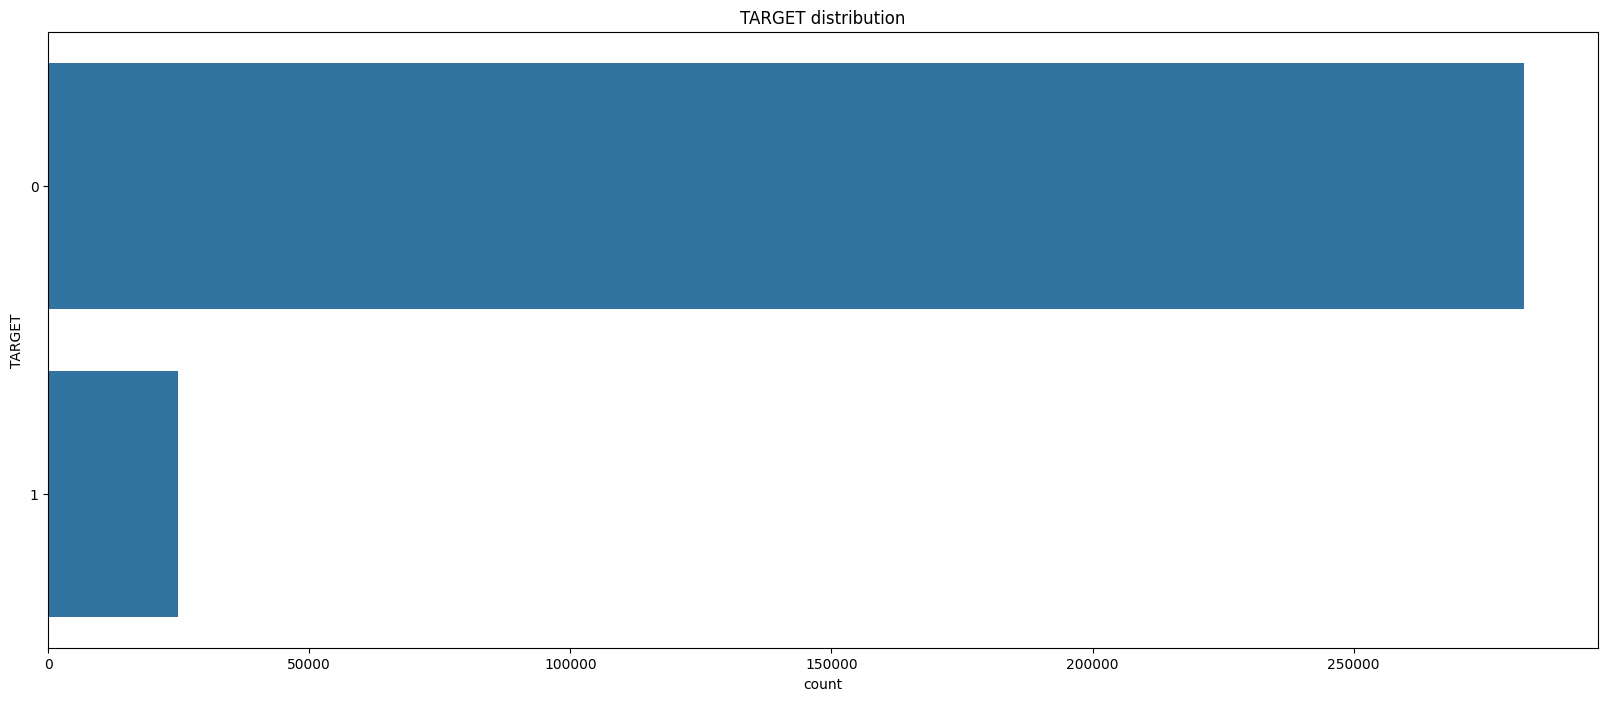

In [17]:
# Analyse de la variable Target dans Application _train
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='TARGET', data=application_train)
ax.set_title("TARGET distribution")

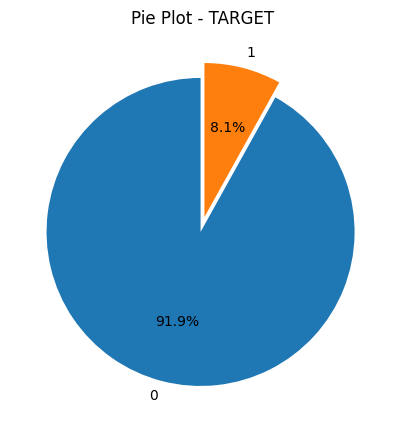

In [18]:
plot_categorical(application_train, "TARGET",kind='pie', figsize=(5,5))

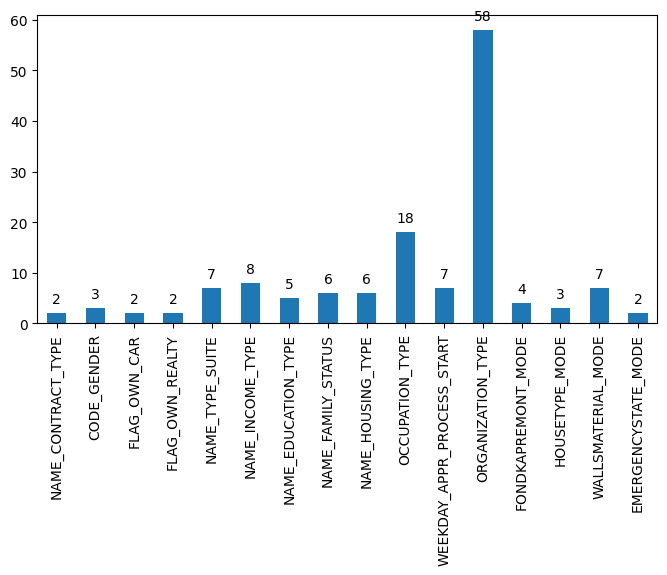

In [19]:
# Sélectionnez les colonnes de type 'object'
categorical_columns = application_train.select_dtypes('object')

# Calculez le nombre de valeurs uniques dans chaque colonne
nunique_values = categorical_columns.nunique()

# Tracer le graphique en barres
ax = nunique_values.plot(kind='bar', figsize=(8, 4))

# Ajoutez les valeurs au-dessus de chaque barre
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Affichez le graphique
plt.show()

In [20]:
application_train['EMERGENCYSTATE_MODE'].value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

les variables categoriels avec 2 valeurs peuvent être assimilés à des booleens

### Comparaison des variables catégorielles entre les 2 datasets , train et test

In [21]:
application_train.columns.difference(application_test.columns)

Index(['TARGET'], dtype='object')

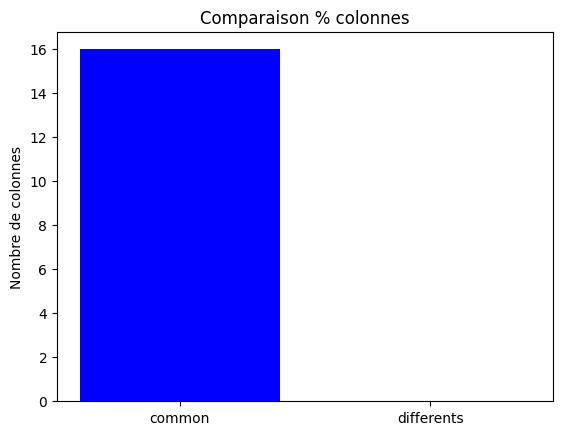

Number of different columns: 0
Different columns: set()
####################################################################################################
CODE_GENDER
Nombre d'attributs de CODE_GENDER dans df1 est 2 , dans df2 est 3
*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#
L'élément dans df2 qui est absent dans df1 est ['XNA']
 
df1 CODE_GENDER:
F    32678
M    16066
Name: CODE_GENDER, dtype: int64
 
df2 CODE_GENDER:
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
NAME_FAMILY_STATUS
Nombre d'attributs de NAME_FAMILY_STATUS dans df1 est 5 , dans df2 est 6
*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#
L'élément dans df2 qui est absent dans df1 est ['Unknown']
 
df1 NAME_FAMILY_STATUS:
Married                 32283
Single / not married     7036
Civil marriage           4261
Separated                2955
Widow                    2209
Name: NAME_FAMI

In [22]:
diff_cate = dataframe_compare(application_test, application_train)

## Imputation locale des variables catégorielles

In [23]:
def local_imputatation(df, diff):
    from scipy.stats import mode
    data = df.copy()
    for name, val_to_replace in diff.items():
        mode_value = mode(data[name])[0][0]
        data[name] = data[name].replace(val_to_replace,mode_value)
    return data

In [24]:
application_train = local_imputatation(application_train, diff_cate)
application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

### Visualisons les valeurs manquantes

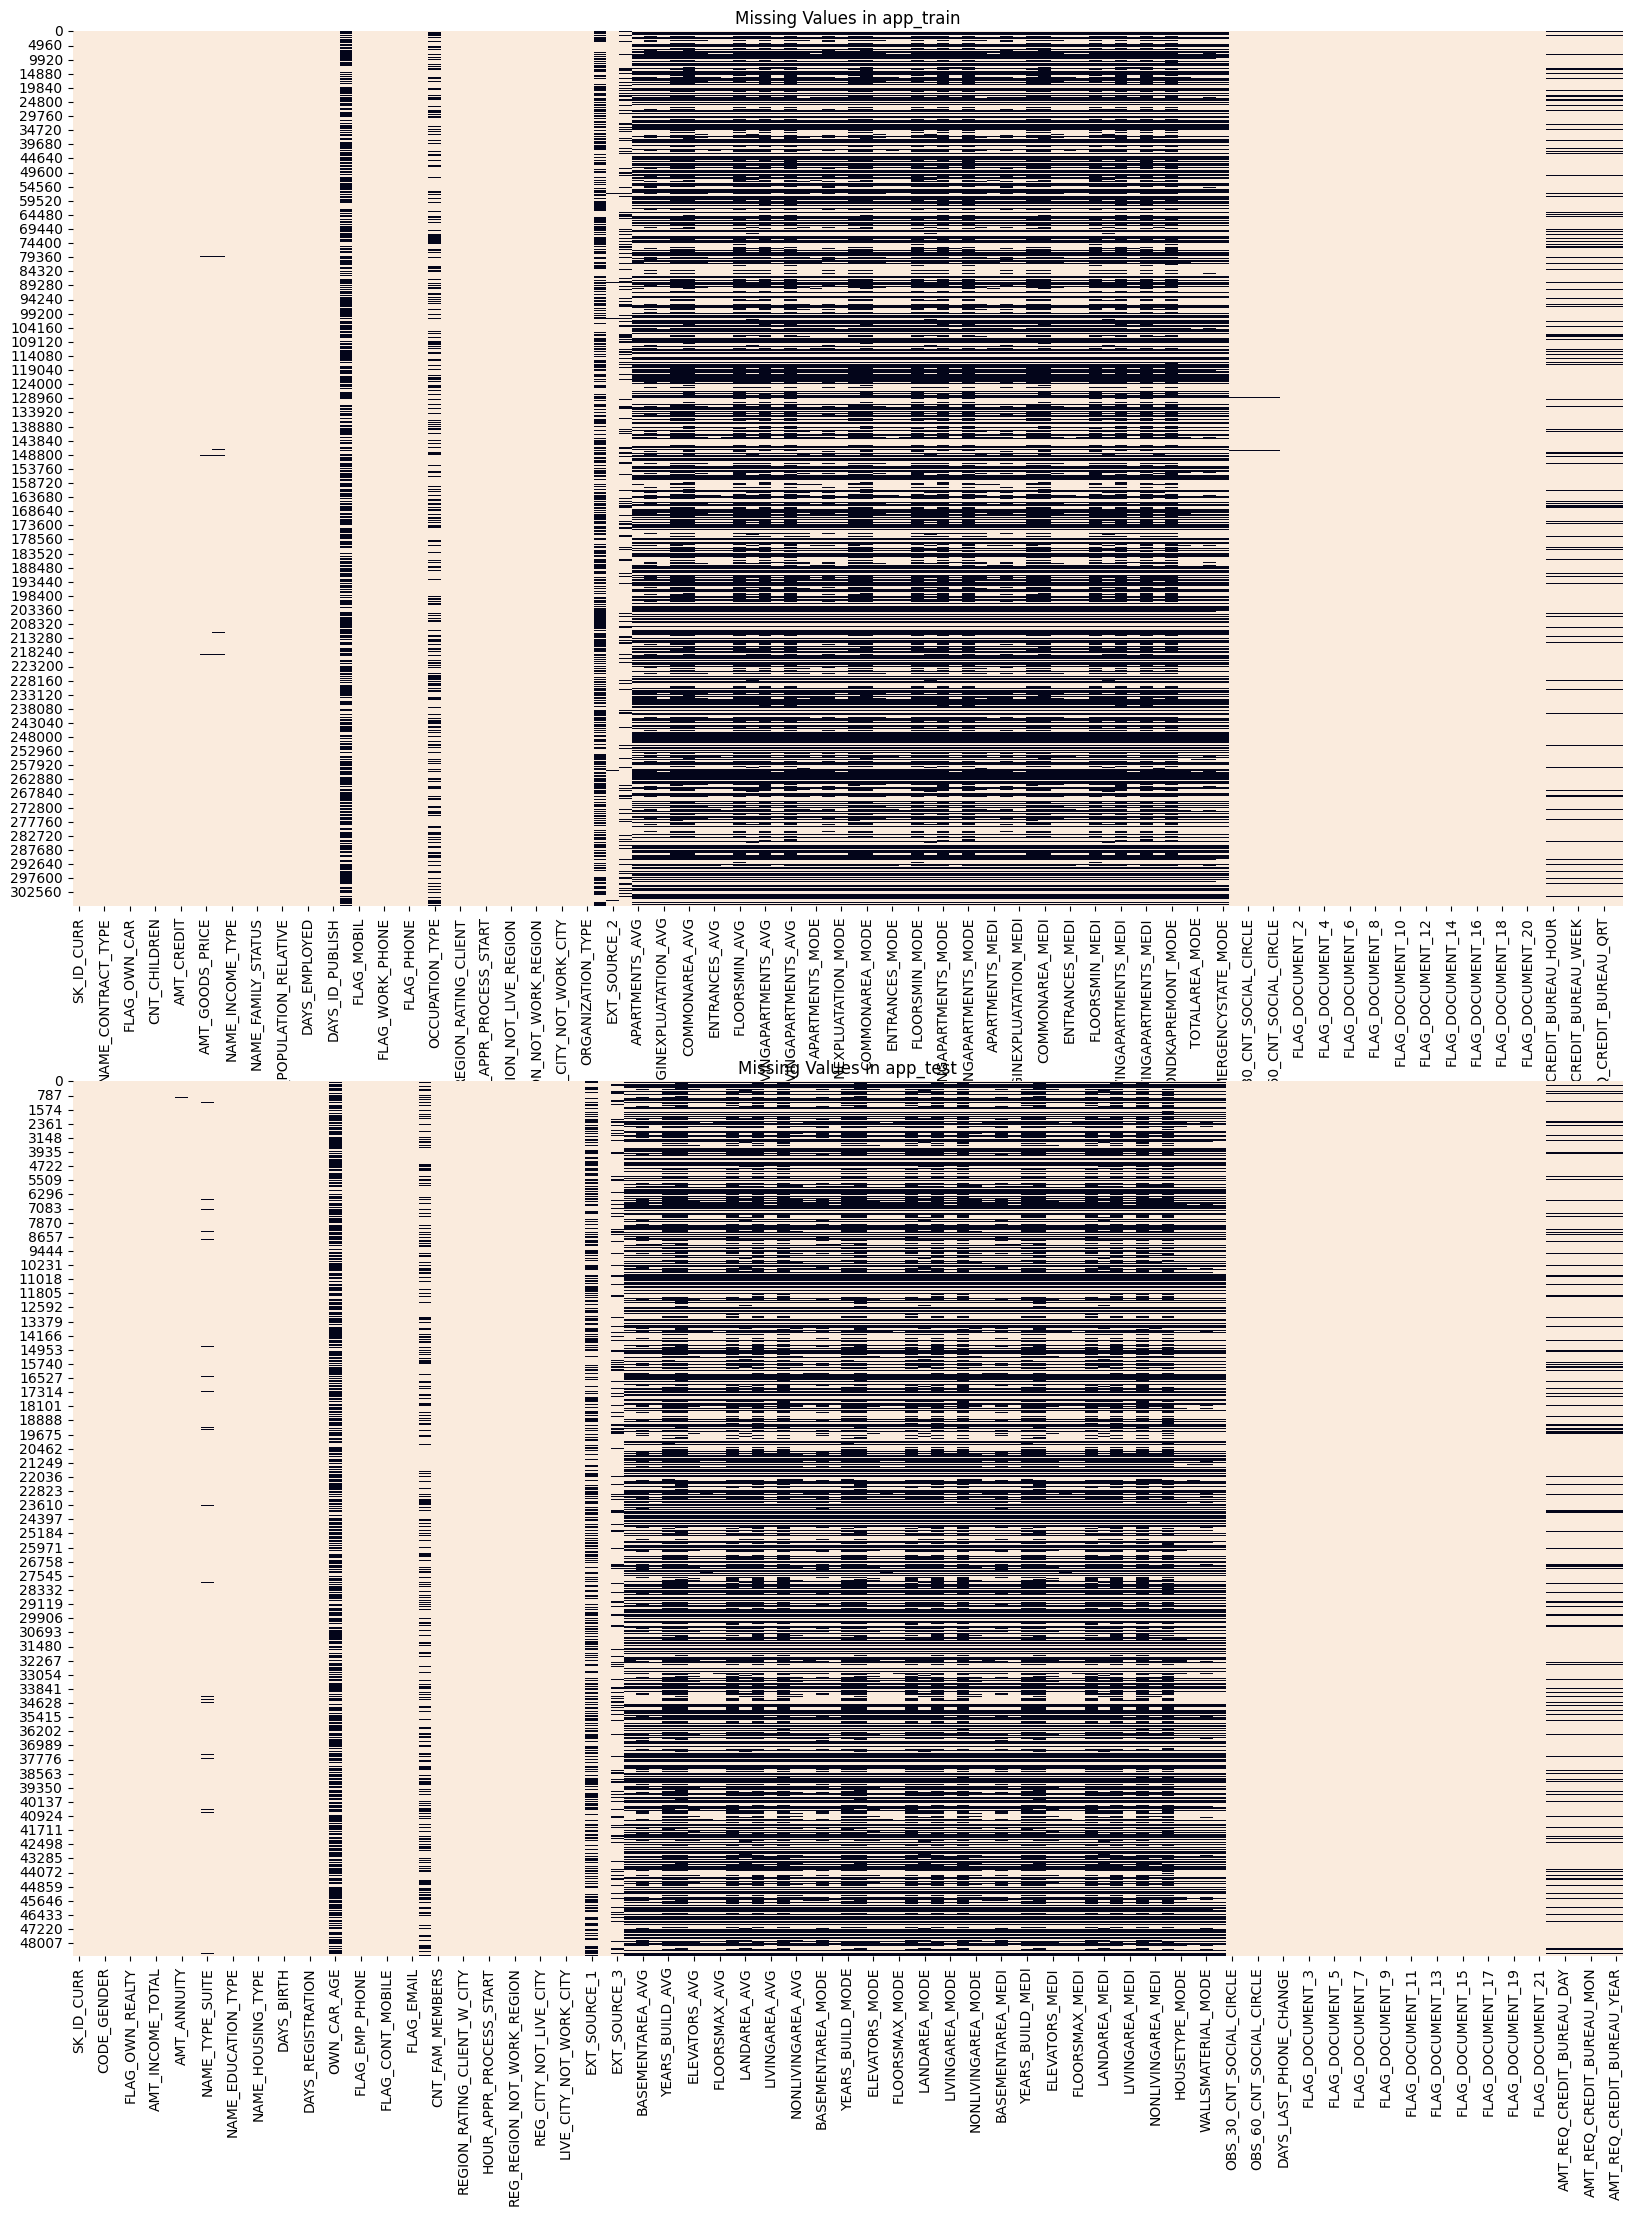

In [25]:
#Global view of the missing values (black)
fig , ax = plt.subplots(2,1 , figsize=(20,25))
ax= ax.ravel()
sns.heatmap(application_train.notna(), cbar=False, ax= ax[0])
ax[0].set_title("Missing Values in app_train")
sns.heatmap(application_test.notna(), cbar=False, ax= ax[1])
ax[1].set_title("Missing Values in app_test")
plt.show()

l'on remarque que la distribution des valeurs manquantes est quasiment la même dans app_train que dans app_test 
de ce fait pour mettre en place notre modelè soit nous opterons pour un modèle qui fera des imputations sur les valeurs manquantes , 
avant ses prédictions soit un modèle qui tolère les valeurs manquantes

#### Réalisons un zoom sur les valeurs manquantes de d'app_train dataset


In [26]:
def top_missing_data(df):
    
    # Calculer le nombre total de valeurs manquantes par colonne
    total_missing = df.isna().sum()
    
    # Calculer le pourcentage de valeurs manquantes par colonne
    percent_missing = (df.isna().mean()) * 100
    
    # Créer le DataFrame avec deux colonnes : 'Total' et 'Percent'
    missing_data = pd.DataFrame({'Total': total_missing, 'Percent': percent_missing})
    
    # Trier le DataFrame par pourcentage de valeurs manquantes en ordre descendant
    missing_data = missing_data.sort_values(by='Percent', ascending=False).reset_index()

    return missing_data

In [27]:
missing_data = top_missing_data(application_train)
missing_data.head(20)

index   Total    Percent
0            COMMONAREA_MEDI  214865  69.872297
1             COMMONAREA_AVG  214865  69.872297
2            COMMONAREA_MODE  214865  69.872297
3   NONLIVINGAPARTMENTS_MODE  213514  69.432963
4    NONLIVINGAPARTMENTS_AVG  213514  69.432963
5   NONLIVINGAPARTMENTS_MEDI  213514  69.432963
6         FONDKAPREMONT_MODE  210295  68.386172
7      LIVINGAPARTMENTS_MODE  210199  68.354953
8       LIVINGAPARTMENTS_AVG  210199  68.354953
9      LIVINGAPARTMENTS_MEDI  210199  68.354953
10             FLOORSMIN_AVG  208642  67.848630
11            FLOORSMIN_MODE  208642  67.848630
12            FLOORSMIN_MEDI  208642  67.848630
13          YEARS_BUILD_MEDI  204488  66.497784
14          YEARS_BUILD_MODE  204488  66.497784
15           YEARS_BUILD_AVG  204488  66.497784
16               OWN_CAR_AGE  202929  65.990810
17             LANDAREA_MEDI  182590  59.376738
18             LANDAREA_MODE  182590  59.376738
19              LANDAREA_AVG  182590  59.376738

In [28]:
# Quelles est la part des colonnes avec valeurs manquantes
mask = missing_data['Total']!=0
print(f'Nombre de colonnes dans application_train, {len(mask)} , le nombre de colonnes avec valeurs manquantes est de {mask.sum()}')

Nombre de colonnes dans application_train, 122 , le nombre de colonnes avec valeurs manquantes est de 67


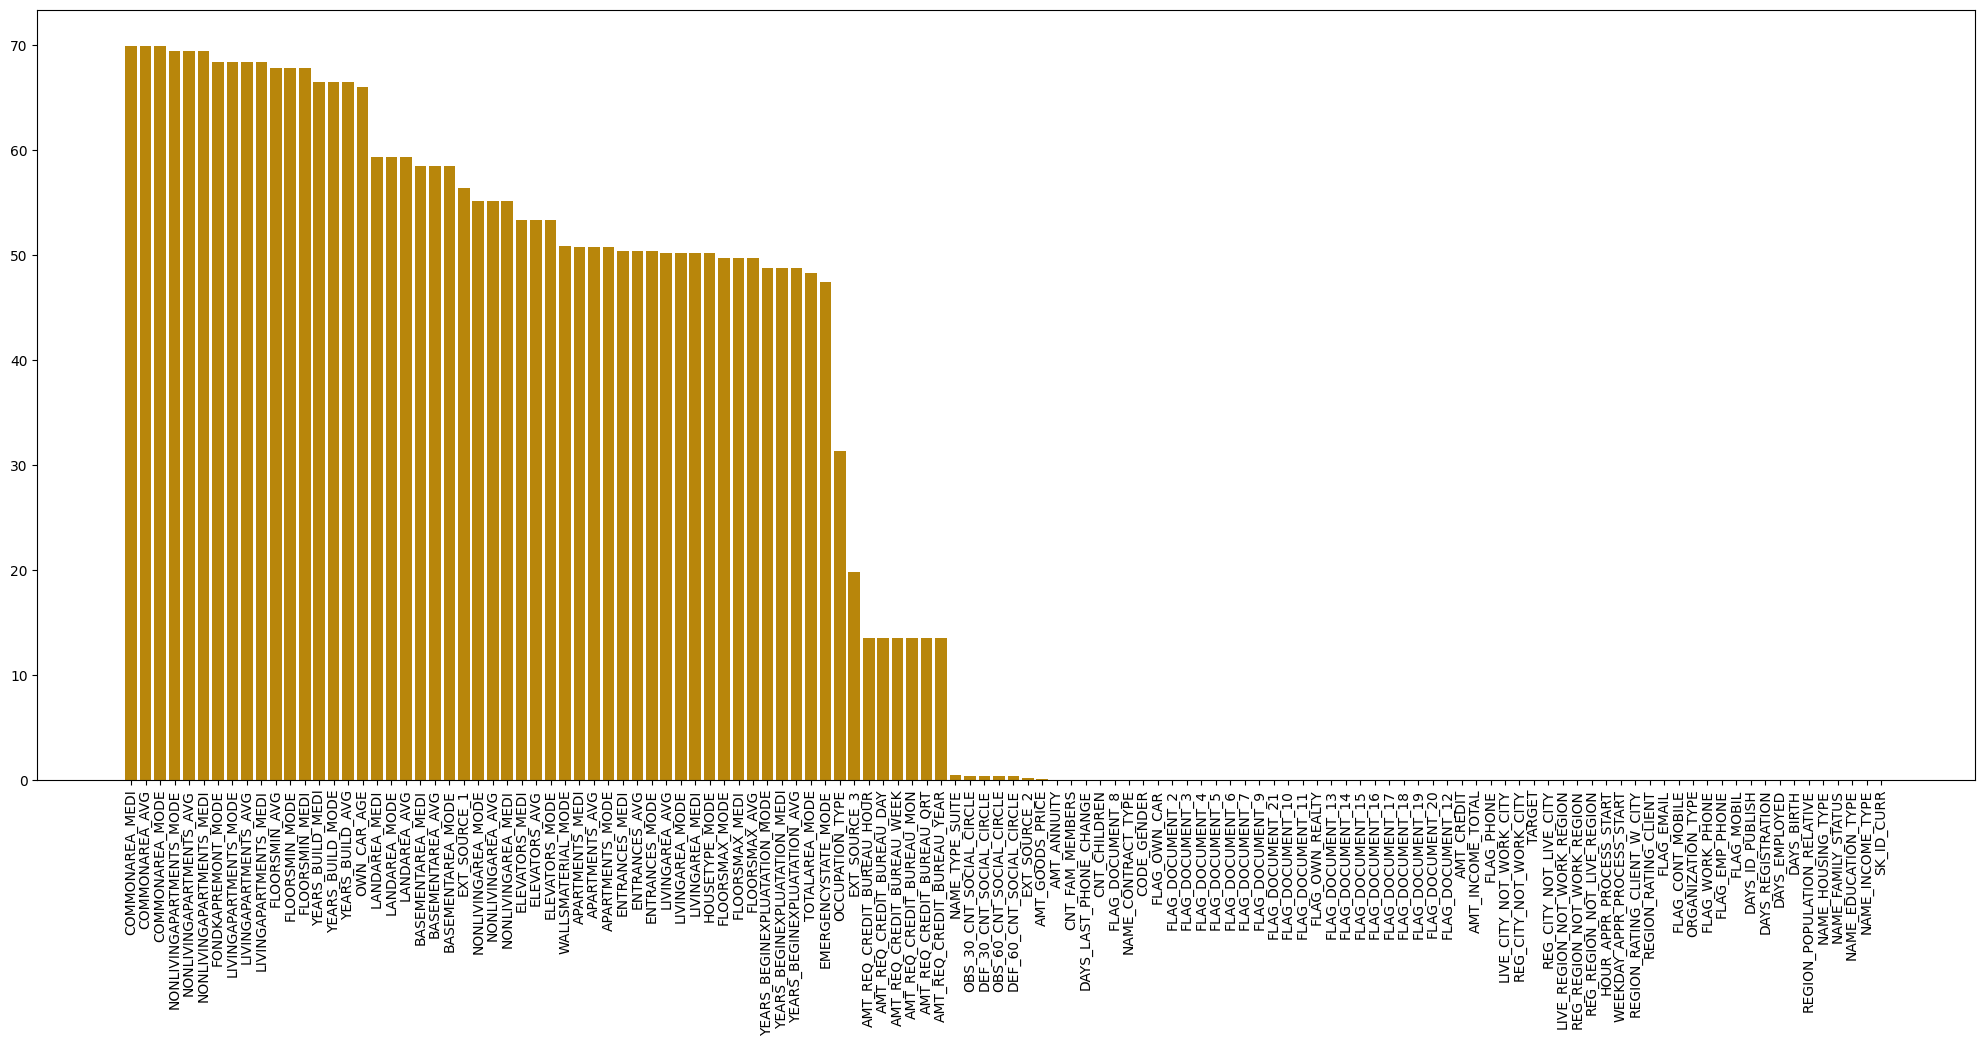

In [29]:
plt.figure(figsize=(25,10))
plt.bar(x=missing_data['index'], height =missing_data['Percent'], color='darkgoldenrod')
plt.xticks(rotation=90 )
plt.show()

In [30]:
pd.DataFrame(application_train.dtypes).value_counts()

float64    65
int64      41
object     16
dtype: int64

### Identification des outliers

In [31]:
application_train.select_dtypes(['float64', 'int64']).shape

(307511, 106)

In [32]:
def plot_numerical_data(df ,boxplot = True ):
    # Sélectionner les colonnes numériques
    data = df.select_dtypes(['float64', 'int64'])
    
    # Calculer le nombre de lignes nécessaires pour le sous-tracé
    n, m = data.shape
    numb = int(np.floor(m / 4)) + 1

    # Créer la disposition des sous-tracés
    fig, ax = plt.subplots(numb, 4, figsize=(15, numb * 3))
    ax = ax.ravel()

    # Tracer l'histogramme pour chaque colonne numérique
    if not boxplot:
        
        for i, name in enumerate(data.columns):
            ax[i].hist(data[name], bins=20)  # Vous pouvez ajuster le nombre de bacs selon vos préférences
            ax[i].set_title(name)
            ax[i].set_xlabel('Value')
            ax[i].set_ylabel('Frequency')
            fig.suptitle('Histogram Distribution', fontsize=16, y=1.005)
    else:
        for i, name in enumerate(data.columns):
            ax[i].boxplot(data[name])  # Vous pouvez ajuster le nombre de bacs selon vos préférences
            ax[i].set_title(name)
            ax[i].set_xlabel('Value')
            ax[i].set_ylabel('Frequency')
            fig.suptitle('Boxplot Distribution', fontsize=16, y=1.005)

    # Supprimer les sous-tracés non utilisés
    for j in range(numb * 4):
        if j >= m:
            fig.delaxes(ax[j])

    plt.tight_layout()
    plt.show()

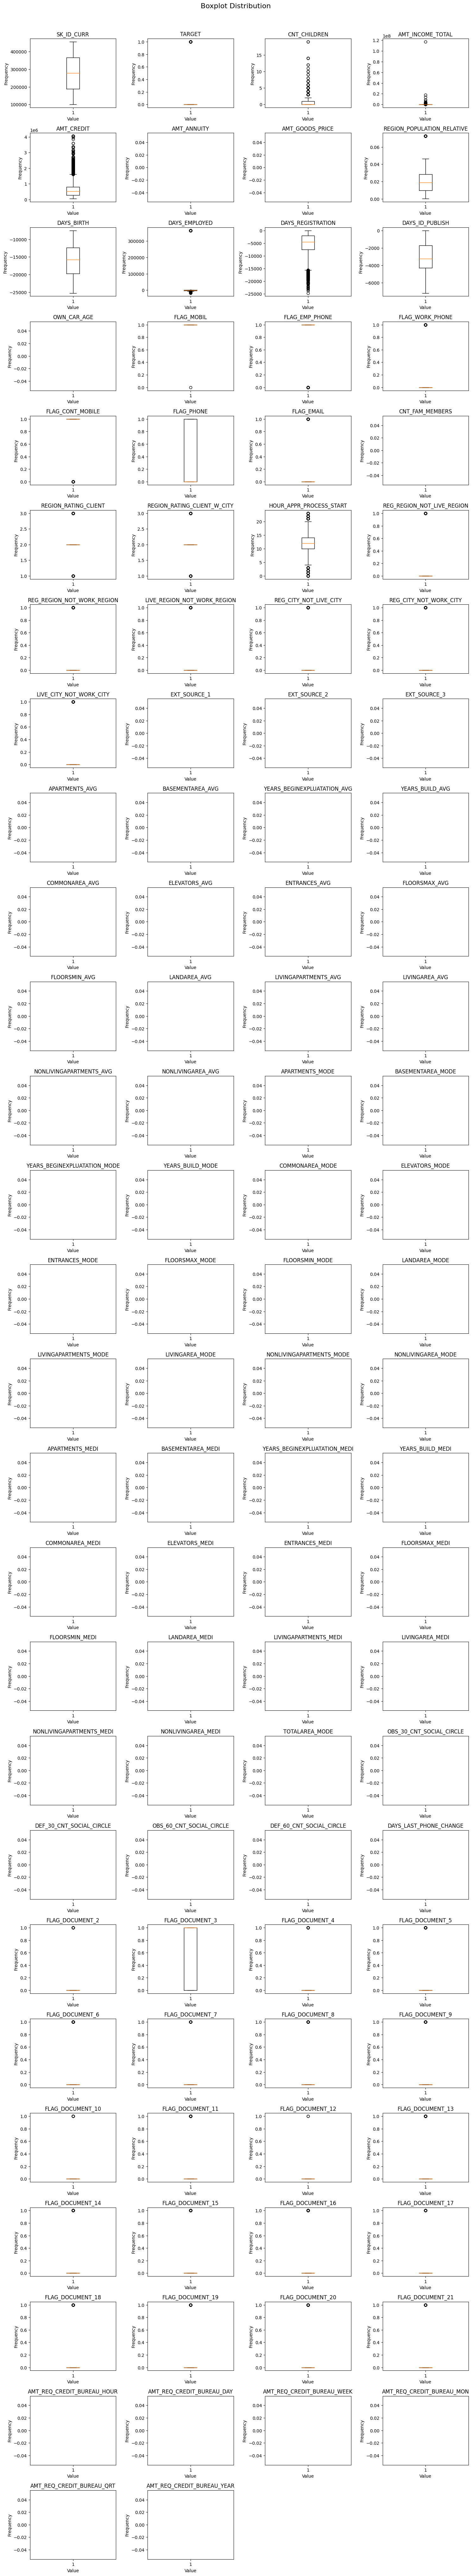

In [33]:
plot_numerical_data(application_train , boxplot= True)

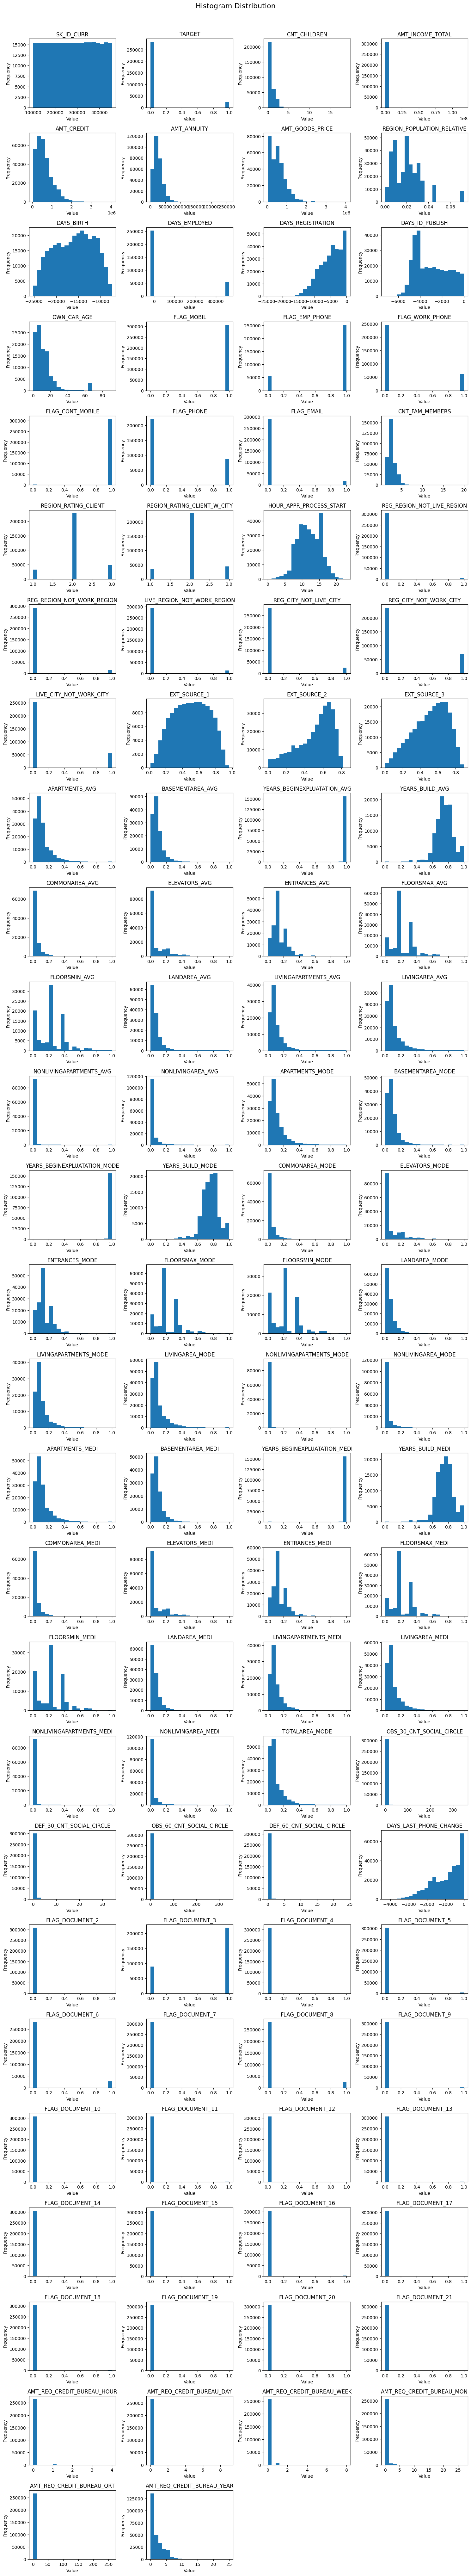

In [34]:
plot_numerical_data(application_train , boxplot= False)

### Zoom sur la variable Days_Birth

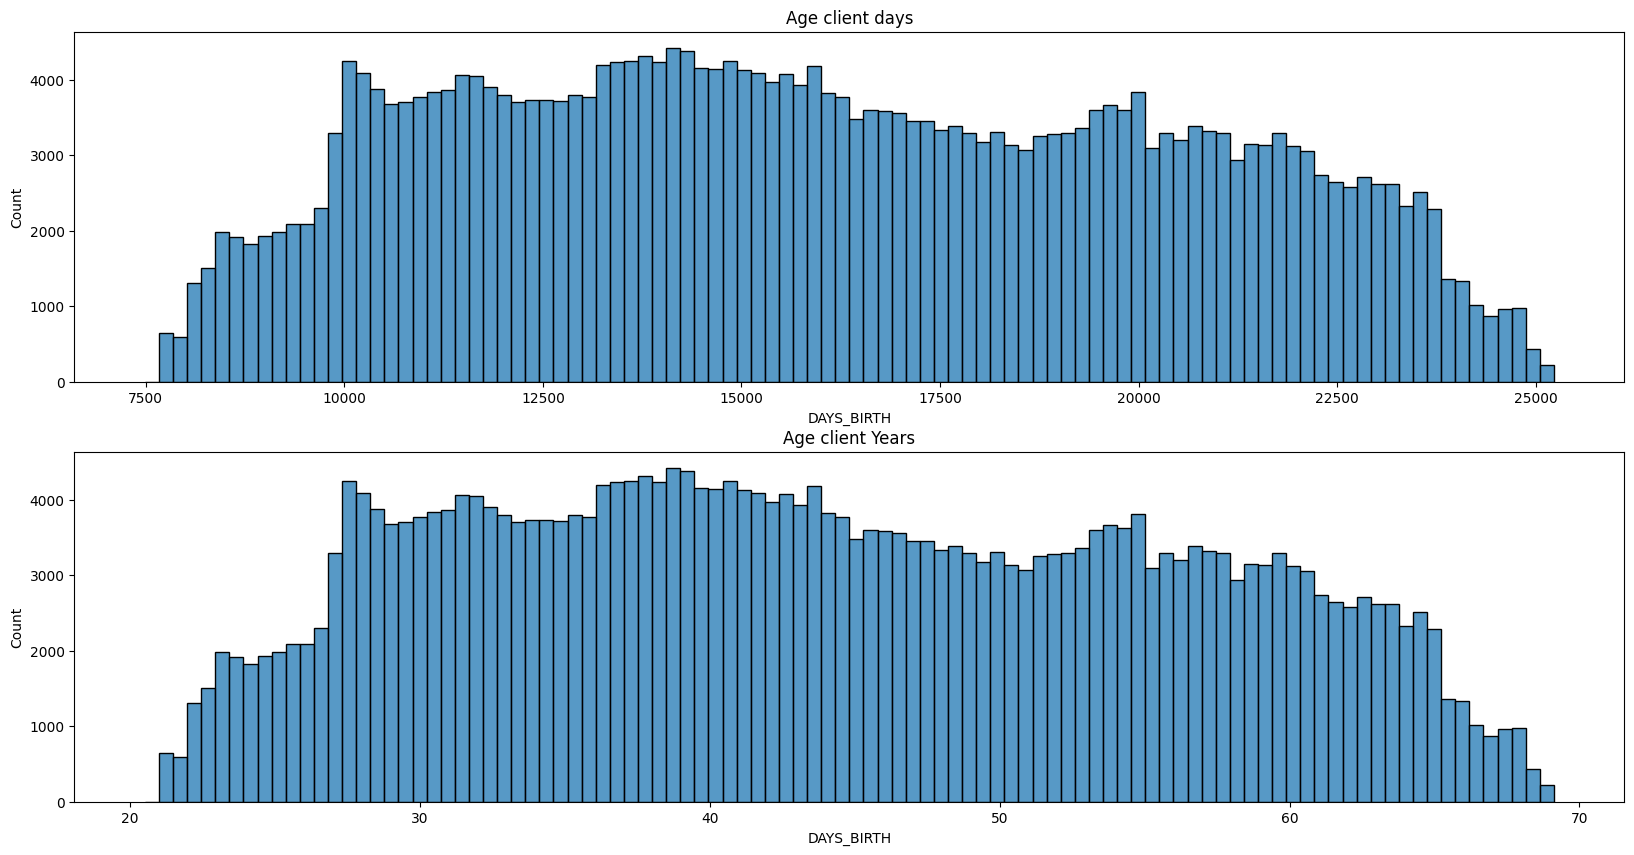

In [35]:
#Days plots en jours
fig , ax =plt.subplots(2,1, figsize=(20,10))
ax = ax.ravel()
sns.histplot(-application_train['DAYS_BIRTH'], ax=ax[0], bins= 100)
ax[0].set_title('Age client days')
sns.histplot(application_train['DAYS_BIRTH']/-365, ax=ax[1], bins=100)
ax[1].set_title('Age client Years')
plt.show()

### Zoom sur la variable Days_Employed

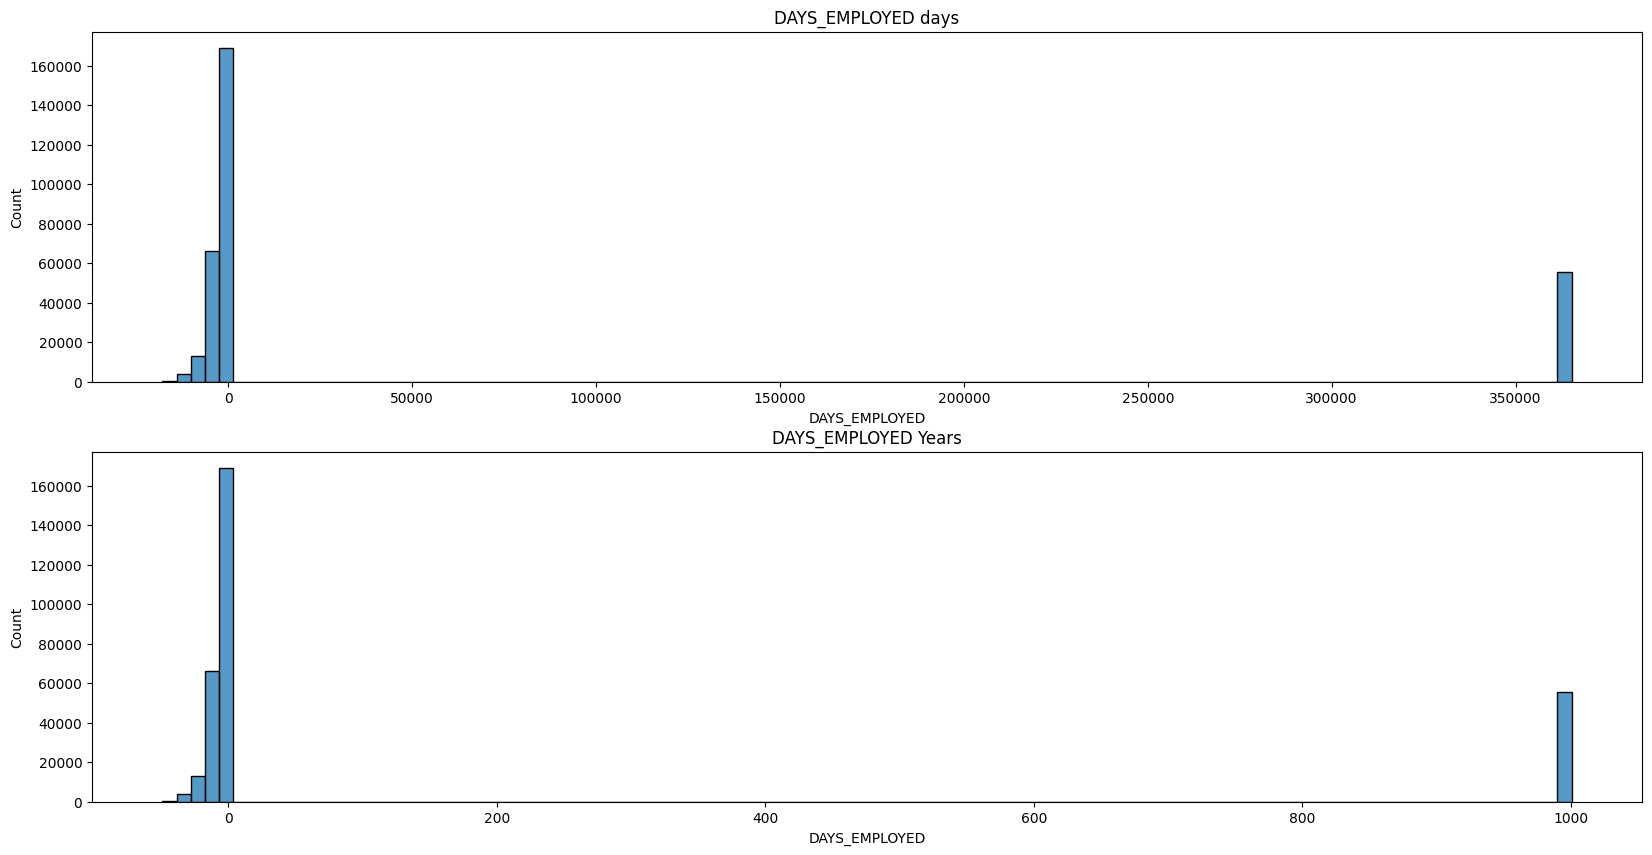

In [36]:
#Days Employed
fig , ax =plt.subplots(2,1, figsize=(20,10))
ax = ax.ravel()
sns.histplot(application_train['DAYS_EMPLOYED'], ax=ax[0], bins= 100)
ax[0].set_title('DAYS_EMPLOYED days')
sns.histplot(application_train['DAYS_EMPLOYED']/365, ax=ax[1], bins=100)
ax[1].set_title('DAYS_EMPLOYED Years')
plt.show()

In [37]:
(application_train['DAYS_EMPLOYED']).describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [38]:
(application_test['DAYS_EMPLOYED']).describe()

count     48744.000000
mean      67485.366322
std      144348.507136
min      -17463.000000
25%       -2910.000000
50%       -1293.000000
75%        -296.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [39]:
# Remplace Traite l'outlier dans Days employer et comvertir l'age en valeur absolue
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])

application_test['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
application_test['DAYS_BIRTH'] = abs(application_test['DAYS_BIRTH'])

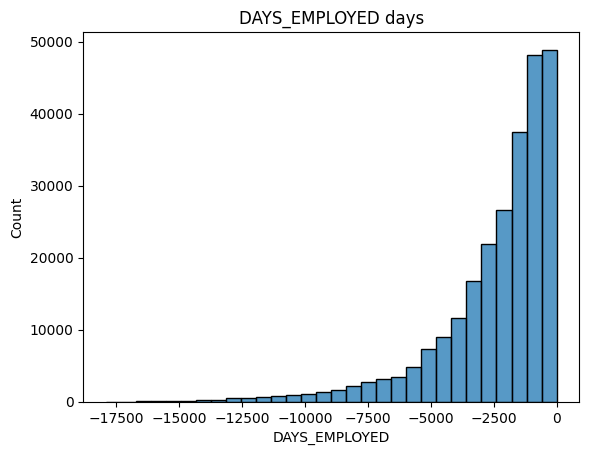

In [40]:
sns.histplot(application_train.loc[:,'DAYS_EMPLOYED'], bins= 30 )
plt.title('DAYS_EMPLOYED days')
plt.show()

In [41]:
### Analyse des 
def plot_data(df, type='object', boxplot=True):
    # Sélectionner les colonnes objet
    data = df.select_dtypes(include=type)
    column_list = data.columns

    # Calculer le nombre de lignes nécessaires pour le sous-tracé
    n, m = data.shape
    numb = int(np.floor(m / 4)) + 1

    # Créer la disposition des sous-tracés
    fig, ax = plt.subplots(numb, 4, figsize=(20,numb*4))
    ax = ax.ravel()

    # Tracer l'histogramme ou le boxplot pour chaque colonne
    for i, name in enumerate(column_list):
        if type == 'object':
            sns.countplot(y=name, data=data, order=data[name].value_counts().index, ax=ax[i])
            ax[i].set_title('Countplot for ' + name)
            ax[i].set_xlabel('Count')
        else:
            if not boxplot:
                ax[i].hist(data[name], bins=20)  # Vous pouvez ajuster le nombre de bacs selon vos préférences
                ax[i].set_title('Histogram for ' + name)
                ax[i].set_xlabel('Value')
                ax[i].set_ylabel('Frequency')
            else:
                ax[i].boxplot(data[name])  # Vous pouvez ajuster le nombre de bacs selon vos préférences
                ax[i].set_title('Boxplot for ' + name)
                ax[i].set_xlabel('Value')
                ax[i].set_ylabel('Frequency')

    # Supprimer les sous-tracés non utilisés
    for j in range(numb * 4):
        if j >= m:
            fig.delaxes(ax[j])

    # Ajouter un titre supérieur à l'ensemble des sous-tracés
    fig.suptitle('Distribution Plot for ' + type.capitalize() + ' features', fontsize=16, y=1.005)

    plt.tight_layout()
    plt.show()

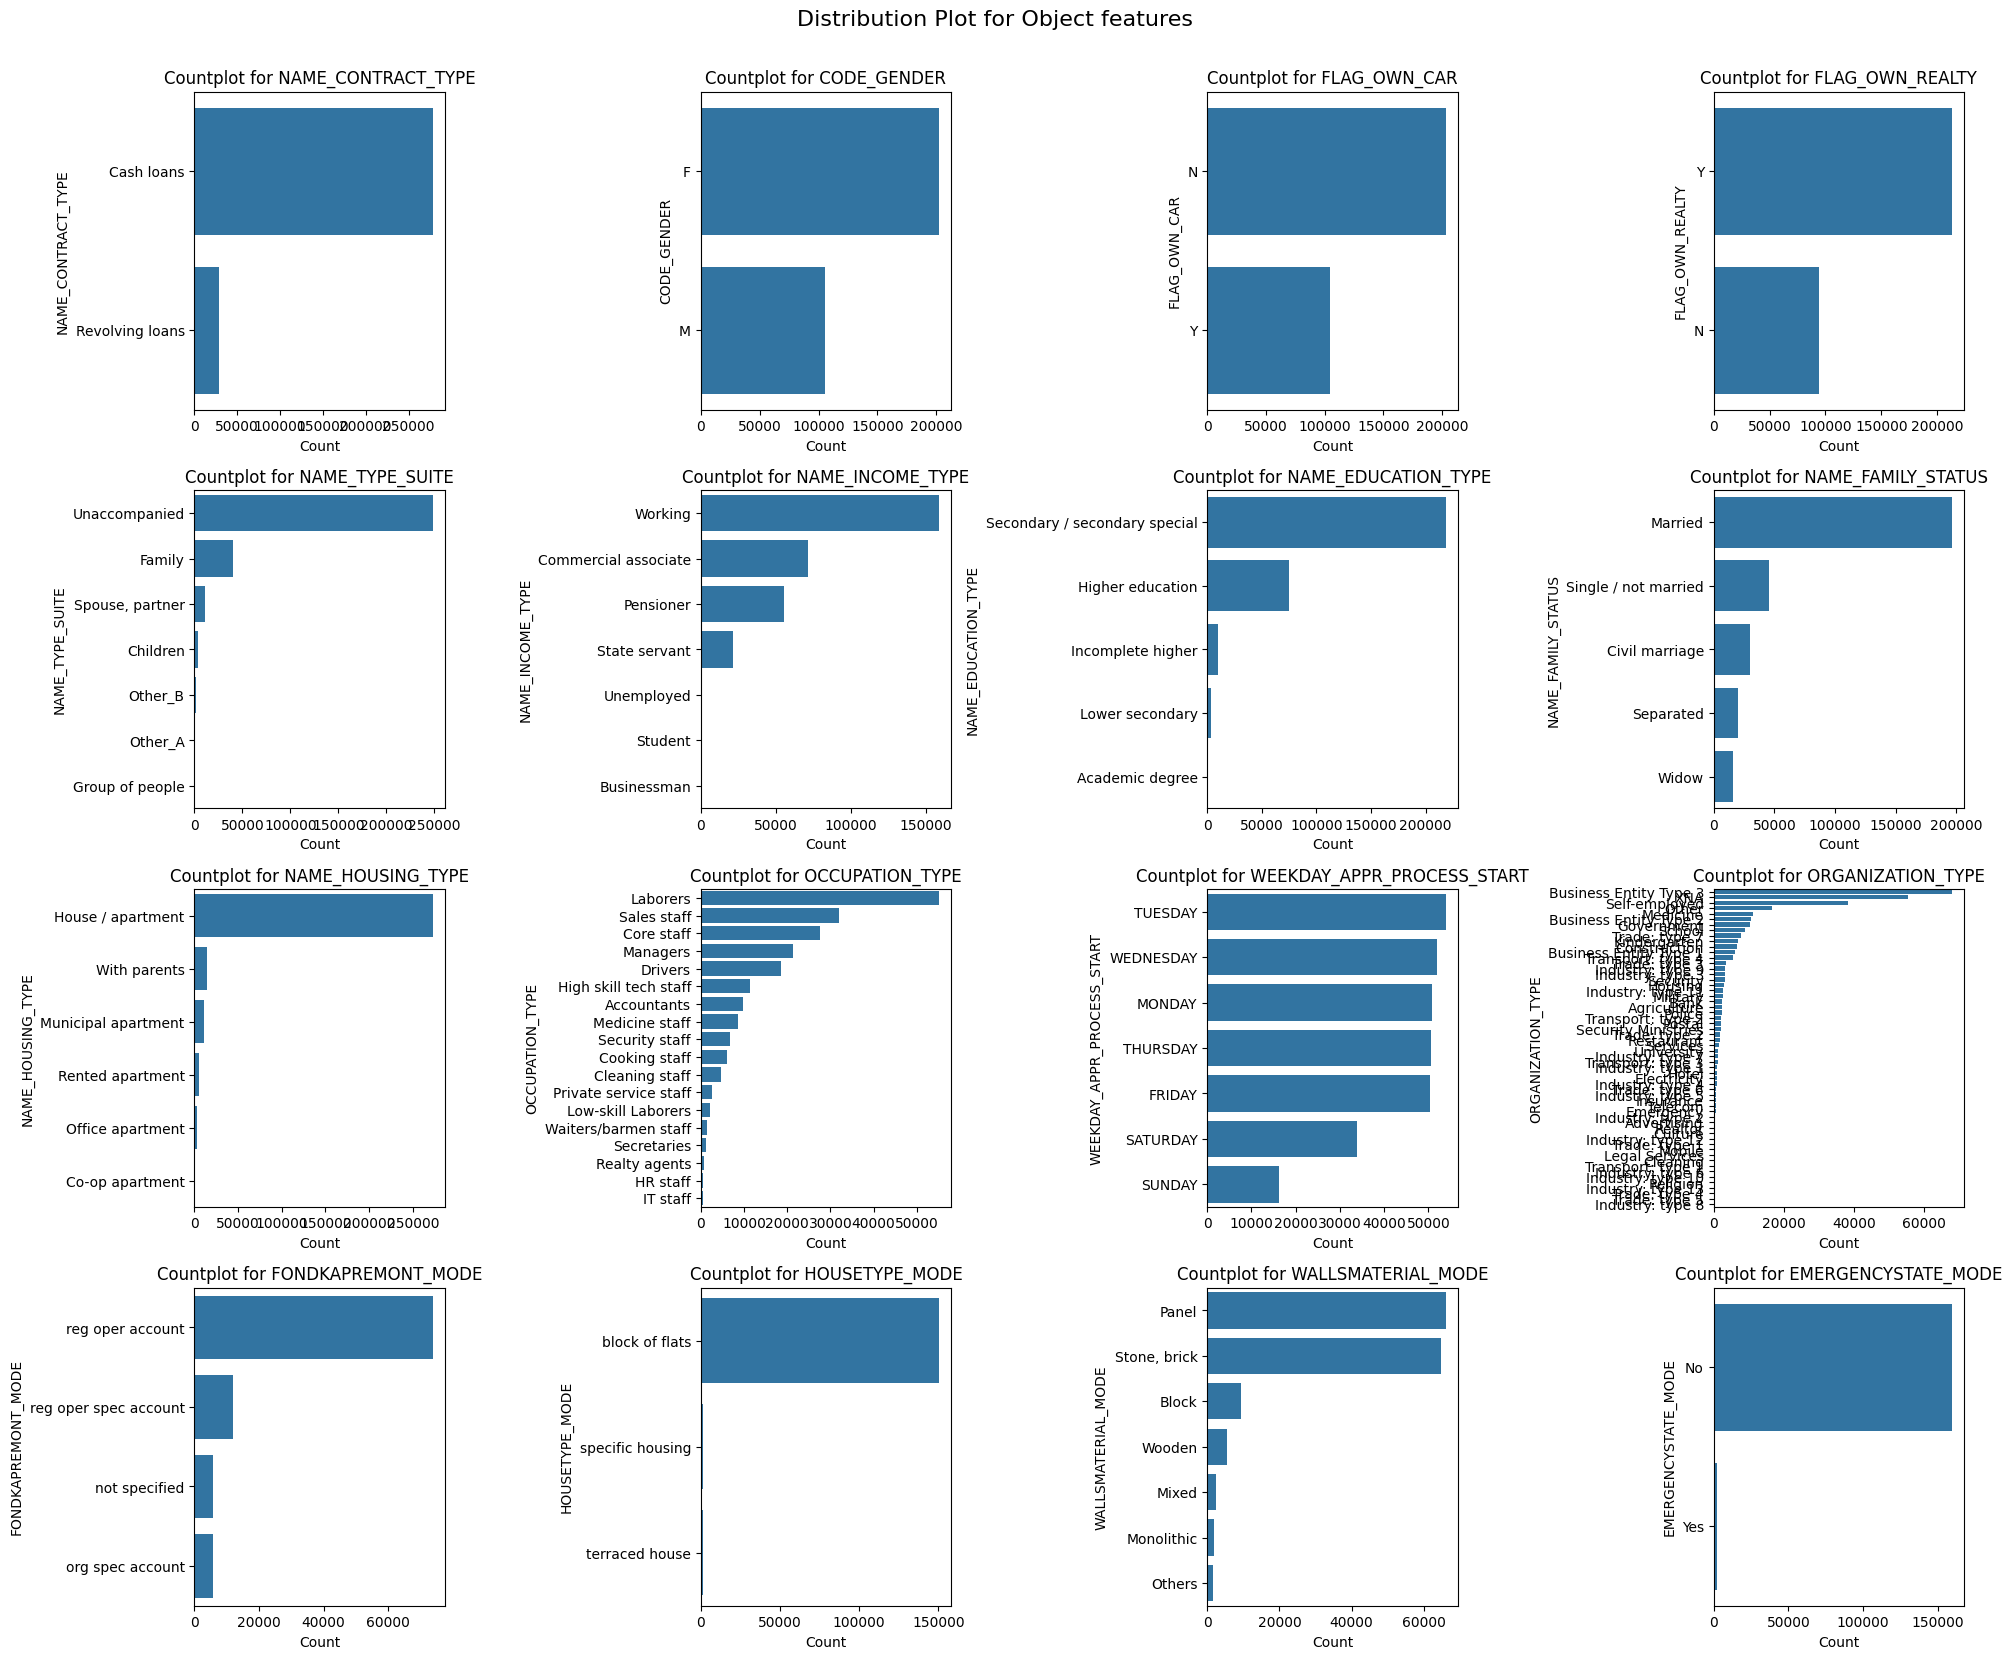

In [42]:
plot_data(application_train, type='object', boxplot=True)

# Analyse sommaire des autres dataframes

## Bureau 

In [43]:
bureau = pd.read_csv(directory + "bureau.csv" , encoding = "ISO-8859-1")
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [44]:
bureau.describe(include='all')

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  \
count   1.716428e+06  1.716428e+06       1716428         1716428   
unique           NaN           NaN             4               4   
top              NaN           NaN        Closed      currency 1   
freq             NaN           NaN       1079273         1715020   
mean    2.782149e+05  5.924434e+06           NaN             NaN   
std     1.029386e+05  5.322657e+05           NaN             NaN   
min     1.000010e+05  5.000000e+06           NaN             NaN   
25%     1.888668e+05  5.463954e+06           NaN             NaN   
50%     2.780550e+05  5.926304e+06           NaN             NaN   
75%     3.674260e+05  6.385681e+06           NaN             NaN   
max     4.562550e+05  6.843457e+06           NaN             NaN   

         DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
count   1.716428e+06        1.716428e+06         1.610875e+06   
unique           NaN                 NaN                  NaN   
top              NaN                 NaN                  NaN   
freq             NaN                 NaN                  NaN   
mean   -1.142108e+03        8.181666e-01         5.105174e+02   
std     7.951649e+02        3.654443e+01         4.994220e+03   
min    -2.922000e+03        0.000000e+00        -4.206000e+04   
25%    -1.666000e+03        0.000000e+00        -1.138000e+03   
50%    -9.870000e+02        0.000000e+00        -3.300000e+02   
75%    -4.740000e+02        0.000000e+00         4.740000e+02   
max     0.000000e+00        2.792000e+03         3.119900e+04   

        DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
count        1.082775e+06            5.919400e+05        1.716428e+06   
unique                NaN                     NaN                 NaN   
top                   NaN                     NaN                 NaN   
freq                  NaN                     NaN                 NaN   
mean        -1.017437e+03            3.825418e+03        6.410406e-03   
std          7.140106e+02            2.060316e+05        9.622391e-02   
min         -4.202300e+04            0.000000e+00        0.000000e+00   
25%         -1.489000e+03            0.000000e+00        0.000000e+00   
50%         -8.970000e+02            0.000000e+00        0.000000e+00   
75%         -4.250000e+02            0.000000e+00        0.000000e+00   
max          0.000000e+00            1.159872e+08        9.000000e+00   

        AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
count     1.716415e+06         1.458759e+06          1.124648e+06   
unique             NaN                  NaN                   NaN   
top                NaN                  NaN                   NaN   
freq               NaN                  NaN                   NaN   
mean      3.549946e+05         1.370851e+05          6.229515e+03   
std       1.149811e+06         6.774011e+05          4.503203e+04   
min       0.000000e+00        -4.705600e+06         -5.864061e+05   
25%       5.130000e+04         0.000000e+00          0.000000e+00   
50%       1.255185e+05         0.000000e+00          0.000000e+00   
75%       3.150000e+05         4.015350e+04          0.000000e+00   
max       5.850000e+08         1.701000e+08          4.705600e+06   

        AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  \
count             1.716428e+06          1716428        1.716428e+06   
unique                     NaN               15                 NaN   
top                        NaN  Consumer credit                 NaN   
freq                       NaN          1251615                 NaN   
mean              3.791276e+01              NaN       -5.937483e+02   
std               5.937650e+03              NaN        7.207473e+02   
min               0.000000e+00              NaN       -4.194700e+04   
25%               0.000000e+00              NaN       -9.080000e+02   
50%               0.000000e+00              NaN       -3.950000e+02

In [45]:
def summary_describe(df, figsize=(10,6)):
    
    print('\n Columns Values\n')
    print(df.columns.values)
    print('\n Columns Types\n')
    print(df.dtypes)
    
    if df.columns.isin(['SK_ID_CURR']).sum() != 0:
        print('le nombre de client renseigné dans le dataset bureau est de ',df['SK_ID_CURR'].nunique())
    
    elif df.columns.isin(['SK_ID_BUREAU']).sum() != 0:
        print('le nombre de client renseigné dans le dataset bureau est de ',df['SK_ID_BUREAU'].nunique())
    
    elif df.columns.isin(['SK_ID_PREV']).sum() != 0:
        print('le nombre de client renseigné dans le dataset bureau est de ',df['SK_ID_PREV'].nunique())
        
    
    print('*_*/*'*30)
    print('\n')
    print('Description globale du dataset')
    print('********'*18)
    print('\n')
    display(df.describe(include ='all'))
    print('\n')
    print('*_*/*'*30)
    print('\n')
    
    mask = df.isna().mean(axis=0)!=0
    nan_columns= mask[mask].index
    
    # Définir la palette de couleur
    custom_palette = sns.color_palette("muted", n_colors=sum(mask))
    
    # Tracer le graphique avec la palette de couleur
    plt.figure(figsize=figsize)
    sns.barplot(x=df[nan_columns].isna().mean(axis=0).sort_values(ascending=False).index,
                y=df[nan_columns].isna().mean(axis=0).sort_values(ascending=False).values*100,
                palette=custom_palette)
    
    # Ajouter des étiquettes et un titre
    plt.xlabel('Colonnes avec des valeurs manquantes')
    plt.ylabel('Fréquence de valeurs manquantes')
    plt.title(' Percentage of missing values per columns')
    
    # Faire pivoter les étiquettes de l'axe x pour une meilleure lisibilité
    plt.xticks(rotation=45, ha='right')
    
    # Afficher le graphique
    plt.show()


 Columns Values

['SK_ID_CURR' 'SK_ID_BUREAU' 'CREDIT_ACTIVE' 'CREDIT_CURRENCY'
 'DAYS_CREDIT' 'CREDIT_DAY_OVERDUE' 'DAYS_CREDIT_ENDDATE'
 'DAYS_ENDDATE_FACT' 'AMT_CREDIT_MAX_OVERDUE' 'CNT_CREDIT_PROLONG'
 'AMT_CREDIT_SUM' 'AMT_CREDIT_SUM_DEBT' 'AMT_CREDIT_SUM_LIMIT'
 'AMT_CREDIT_SUM_OVERDUE' 'CREDIT_TYPE' 'DAYS_CREDIT_UPDATE' 'AMT_ANNUITY']

 Columns Types

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object
le nombre de client renseigné dans le dataset 

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  \
count   1.716428e+06  1.716428e+06       1716428         1716428   
unique           NaN           NaN             4               4   
top              NaN           NaN        Closed      currency 1   
freq             NaN           NaN       1079273         1715020   
mean    2.782149e+05  5.924434e+06           NaN             NaN   
std     1.029386e+05  5.322657e+05           NaN             NaN   
min     1.000010e+05  5.000000e+06           NaN             NaN   
25%     1.888668e+05  5.463954e+06           NaN             NaN   
50%     2.780550e+05  5.926304e+06           NaN             NaN   
75%     3.674260e+05  6.385681e+06           NaN             NaN   
max     4.562550e+05  6.843457e+06           NaN             NaN   

         DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
count   1.716428e+06        1.716428e+06         1.610875e+06   
unique           NaN                 NaN                  NaN   
top              NaN                 NaN                  NaN   
freq             NaN                 NaN                  NaN   
mean   -1.142108e+03        8.181666e-01         5.105174e+02   
std     7.951649e+02        3.654443e+01         4.994220e+03   
min    -2.922000e+03        0.000000e+00        -4.206000e+04   
25%    -1.666000e+03        0.000000e+00        -1.138000e+03   
50%    -9.870000e+02        0.000000e+00        -3.300000e+02   
75%    -4.740000e+02        0.000000e+00         4.740000e+02   
max     0.000000e+00        2.792000e+03         3.119900e+04   

        DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
count        1.082775e+06            5.919400e+05        1.716428e+06   
unique                NaN                     NaN                 NaN   
top                   NaN                     NaN                 NaN   
freq                  NaN                     NaN                 NaN   
mean        -1.017437e+03            3.825418e+03        6.410406e-03   
std          7.140106e+02            2.060316e+05        9.622391e-02   
min         -4.202300e+04            0.000000e+00        0.000000e+00   
25%         -1.489000e+03            0.000000e+00        0.000000e+00   
50%         -8.970000e+02            0.000000e+00        0.000000e+00   
75%         -4.250000e+02            0.000000e+00        0.000000e+00   
max          0.000000e+00            1.159872e+08        9.000000e+00   

        AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
count     1.716415e+06         1.458759e+06          1.124648e+06   
unique             NaN                  NaN                   NaN   
top                NaN                  NaN                   NaN   
freq               NaN                  NaN                   NaN   
mean      3.549946e+05         1.370851e+05          6.229515e+03   
std       1.149811e+06         6.774011e+05          4.503203e+04   
min       0.000000e+00        -4.705600e+06         -5.864061e+05   
25%       5.130000e+04         0.000000e+00          0.000000e+00   
50%       1.255185e+05         0.000000e+00          0.000000e+00   
75%       3.150000e+05         4.015350e+04          0.000000e+00   
max       5.850000e+08         1.701000e+08          4.705600e+06   

        AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  \
count             1.716428e+06          1716428        1.716428e+06   
unique                     NaN               15                 NaN   
top                        NaN  Consumer credit                 NaN   
freq                       NaN          1251615                 NaN   
mean              3.791276e+01              NaN       -5.937483e+02   
std               5.937650e+03              NaN        7.207473e+02   
min               0.000000e+00              NaN       -4.194700e+04   
25%               0.000000e+00              NaN       -9.080000e+02   
50%               0.000000e+00              NaN       -3.950000e+02



*_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/*




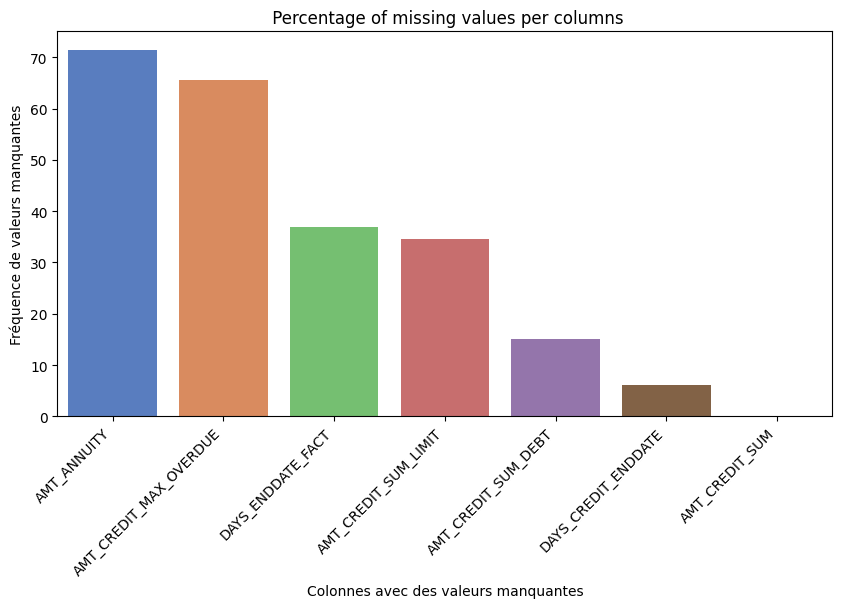

In [46]:
summary_describe(bureau, figsize=(10,5))

## Bureau Balance

In [47]:
bureau_balance = pd.read_csv(directory + "bureau_balance.csv" , encoding = "ISO-8859-1")
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C


 Columns Values

['SK_ID_BUREAU' 'MONTHS_BALANCE' 'STATUS']

 Columns Types

SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object
le nombre de client renseigné dans le dataset bureau est de  817395
*_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/*


Description globale du dataset
************************************************************************************************************************************************




SK_ID_BUREAU  MONTHS_BALANCE    STATUS
count   2.729992e+07    2.729992e+07  27299925
unique           NaN             NaN         8
top              NaN             NaN         C
freq             NaN             NaN  13646993
mean    6.036297e+06   -3.074169e+01       NaN
std     4.923489e+05    2.386451e+01       NaN
min     5.001709e+06   -9.600000e+01       NaN
25%     5.730933e+06   -4.600000e+01       NaN
50%     6.070821e+06   -2.500000e+01       NaN
75%     6.431951e+06   -1.100000e+01       NaN
max     6.842888e+06    0.000000e+00       NaN



*_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/*




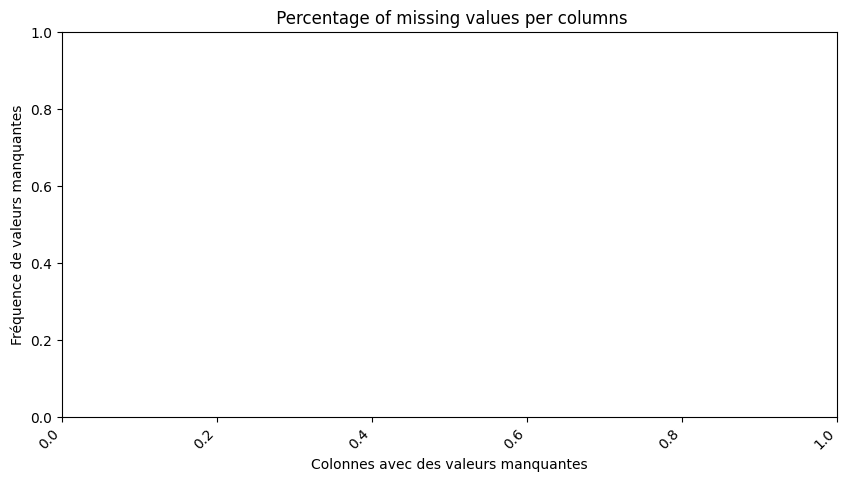

In [48]:
summary_describe(bureau_balance, figsize=(10,5))

## Credit_card_balance

In [49]:
credit_card_balance = pd.read_csv(directory + "credit_card_balance.csv" , encoding = "ISO-8859-1")
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]


 Columns Values

['SK_ID_PREV' 'SK_ID_CURR' 'MONTHS_BALANCE' 'AMT_BALANCE'
 'AMT_CREDIT_LIMIT_ACTUAL' 'AMT_DRAWINGS_ATM_CURRENT'
 'AMT_DRAWINGS_CURRENT' 'AMT_DRAWINGS_OTHER_CURRENT'
 'AMT_DRAWINGS_POS_CURRENT' 'AMT_INST_MIN_REGULARITY'
 'AMT_PAYMENT_CURRENT' 'AMT_PAYMENT_TOTAL_CURRENT'
 'AMT_RECEIVABLE_PRINCIPAL' 'AMT_RECIVABLE' 'AMT_TOTAL_RECEIVABLE'
 'CNT_DRAWINGS_ATM_CURRENT' 'CNT_DRAWINGS_CURRENT'
 'CNT_DRAWINGS_OTHER_CURRENT' 'CNT_DRAWINGS_POS_CURRENT'
 'CNT_INSTALMENT_MATURE_CUM' 'NAME_CONTRACT_STATUS' 'SK_DPD' 'SK_DPD_DEF']

 Columns Types

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT  

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count   3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
unique           NaN           NaN             NaN           NaN   
top              NaN           NaN             NaN           NaN   
freq             NaN           NaN             NaN           NaN   
mean    1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std     5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min     1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%     1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%     1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%     2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max     2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

        AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count              3.840312e+06              3.090496e+06   
unique                      NaN                       NaN   
top                         NaN                       NaN   
freq                        NaN                       NaN   
mean               1.538080e+05              5.961325e+03   
std                1.651457e+05              2.822569e+04   
min                0.000000e+00             -6.827310e+03   
25%                4.500000e+04              0.000000e+00   
50%                1.125000e+05              0.000000e+00   
75%                1.800000e+05              0.000000e+00   
max                1.350000e+06              2.115000e+06   

        AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count           3.840312e+06                3.090496e+06   
unique                   NaN                         NaN   
top                      NaN                         NaN   
freq                     NaN                         NaN   
mean            7.433388e+03                2.881696e+02   
std             3.384608e+04                8.201989e+03   
min            -6.211620e+03                0.000000e+00   
25%             0.000000e+00                0.000000e+00   
50%             0.000000e+00                0.000000e+00   
75%             0.000000e+00                0.000000e+00   
max             2.287098e+06                1.529847e+06   

        AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  \
count               3.090496e+06             3.535076e+06  ...   3.840312e+06   
unique                       NaN                      NaN  ...            NaN   
top                          NaN                      NaN  ...            NaN   
freq                         NaN                      NaN  ...            NaN   
mean                2.968805e+03             3.540204e+03  ...   5.808881e+04   
std                 2.079689e+04             5.600154e+03  ...   1.059654e+05   
min                 0.000000e+00             0.000000e+00  ...  -4.202502e+05   
25%                 0.000000e+00             0.000000e+00  ...   0.000000e+00   
50%                 0.000000e+00             0.000000e+00  ...   0.000000e+00   
75%                 0.000000e+00             6.633911e+03  ...   8.889949e+04   
max                 2.239274e+06             2.028820e+05  ...   1.493338e+06   

        AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count           3.840312e+06              3.090496e+06          3.840312e+06   
unique                   NaN                       NaN                   NaN   
top                      NaN                       NaN                   NaN   
freq                     NaN                       NaN                   NaN   
mean            5.809829e+04              3.094490e-01          7.031439e-01   
std             1.059718e+05              1.100401e+00          3.190347e+00   
min            -4.202502e+05              0.000000e+00          0.000000e+00   
25%             0.000000e+00              0.000000e+00          0.000000e+00   
50%             0.000000e+00              0.00



*_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/*




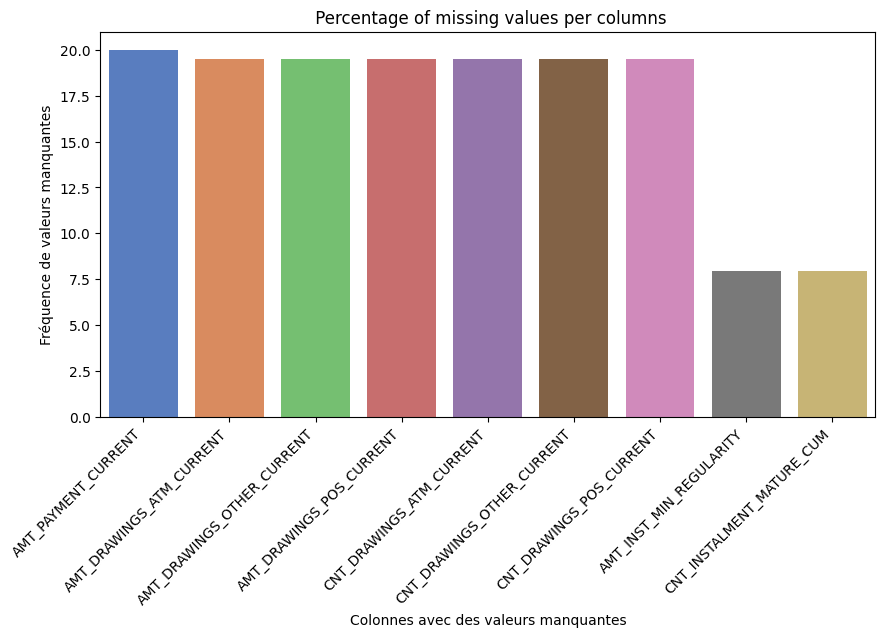

In [50]:
summary_describe(credit_card_balance, figsize=(10,5))

## Installments_payments

In [51]:
installments_payments = pd.read_csv(directory + "installments_payments.csv" , encoding = "ISO-8859-1")
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585


 Columns Values

['SK_ID_PREV' 'SK_ID_CURR' 'NUM_INSTALMENT_VERSION'
 'NUM_INSTALMENT_NUMBER' 'DAYS_INSTALMENT' 'DAYS_ENTRY_PAYMENT'
 'AMT_INSTALMENT' 'AMT_PAYMENT']

 Columns Types

SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object
le nombre de client renseigné dans le dataset bureau est de  339587
*_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/*


Description globale du dataset
************************************************************************************************************************************************




SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.180000e+02       -8.270000e+02   
75%             1.900000e+01    -3.610000e+02       -3.700000e+02   
max             2.770000e+02    -1.000000e+00       -1.000000e+00   

       AMT_INSTALMENT   AMT_PAYMENT  
count    1.360540e+07  1.360250e+07  
mean     1.705091e+04  1.723822e+04  
std      5.057025e+04  5.473578e+04  
min      0.000000e+00  0.000000e+00  
25%      4.226085e+03  3.398265e+03  
50%      8.884080e+03  8.125515e+03  
75%      1.671021e+04  1.610842e+04  
max      3.771488e+06  3.771488e+06



*_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/*




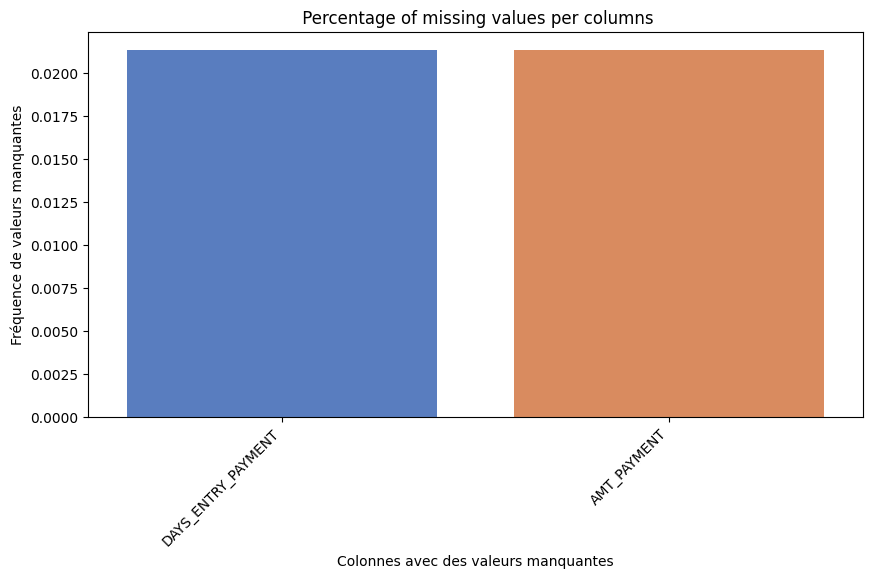

In [52]:
summary_describe(installments_payments, figsize=(10,5))

## POS_CASH_balance

In [53]:
POS_CASH_balance = pd.read_csv(directory + "POS_CASH_balance.csv" , encoding = "ISO-8859-1")
POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0


 Columns Values

['SK_ID_PREV' 'SK_ID_CURR' 'MONTHS_BALANCE' 'CNT_INSTALMENT'
 'CNT_INSTALMENT_FUTURE' 'NAME_CONTRACT_STATUS' 'SK_DPD' 'SK_DPD_DEF']

 Columns Types

SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object
le nombre de client renseigné dans le dataset bureau est de  337252
*_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/*


Description globale du dataset
************************************************************************************************************************************************




SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
count   1.000136e+07  1.000136e+07    1.000136e+07    9.975287e+06   
unique           NaN           NaN             NaN             NaN   
top              NaN           NaN             NaN             NaN   
freq             NaN           NaN             NaN             NaN   
mean    1.903217e+06  2.784039e+05   -3.501259e+01    1.708965e+01   
std     5.358465e+05  1.027637e+05    2.606657e+01    1.199506e+01   
min     1.000001e+06  1.000010e+05   -9.600000e+01    1.000000e+00   
25%     1.434405e+06  1.895500e+05   -5.400000e+01    1.000000e+01   
50%     1.896565e+06  2.786540e+05   -2.800000e+01    1.200000e+01   
75%     2.368963e+06  3.674290e+05   -1.300000e+01    2.400000e+01   
max     2.843499e+06  4.562550e+05   -1.000000e+00    9.200000e+01   

        CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS        SK_DPD    SK_DPD_DEF  
count            9.975271e+06             10001358  1.000136e+07  1.000136e+07  
unique                    NaN                    9           NaN           NaN  
top                       NaN               Active           NaN           NaN  
freq                      NaN              9151119           NaN           NaN  
mean             1.048384e+01                  NaN  1.160693e+01  6.544684e-01  
std              1.110906e+01                  NaN  1.327140e+02  3.276249e+01  
min              0.000000e+00                  NaN  0.000000e+00  0.000000e+00  
25%              3.000000e+00                  NaN  0.000000e+00  0.000000e+00  
50%              7.000000e+00                  NaN  0.000000e+00  0.000000e+00  
75%              1.400000e+01                  NaN  0.000000e+00  0.000000e+00  
max              8.500000e+01                  NaN  4.231000e+03  3.595000e+03



*_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/*




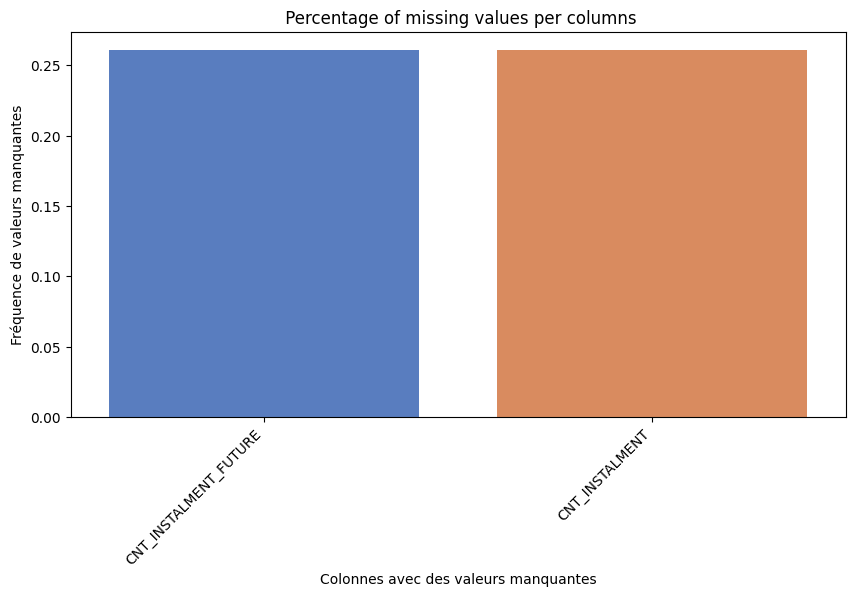

In [54]:
summary_describe(POS_CASH_balance, figsize=(10,5))

## Previous_application

In [55]:
previous_application = pd.read_csv(directory + "previous_application.csv" , encoding = "ISO-8859-1")
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]


 Columns Values

['SK_ID_PREV' 'SK_ID_CURR' 'NAME_CONTRACT_TYPE' 'AMT_ANNUITY'
 'AMT_APPLICATION' 'AMT_CREDIT' 'AMT_DOWN_PAYMENT' 'AMT_GOODS_PRICE'
 'WEEKDAY_APPR_PROCESS_START' 'HOUR_APPR_PROCESS_START'
 'FLAG_LAST_APPL_PER_CONTRACT' 'NFLAG_LAST_APPL_IN_DAY'
 'RATE_DOWN_PAYMENT' 'RATE_INTEREST_PRIMARY' 'RATE_INTEREST_PRIVILEGED'
 'NAME_CASH_LOAN_PURPOSE' 'NAME_CONTRACT_STATUS' 'DAYS_DECISION'
 'NAME_PAYMENT_TYPE' 'CODE_REJECT_REASON' 'NAME_TYPE_SUITE'
 'NAME_CLIENT_TYPE' 'NAME_GOODS_CATEGORY' 'NAME_PORTFOLIO'
 'NAME_PRODUCT_TYPE' 'CHANNEL_TYPE' 'SELLERPLACE_AREA'
 'NAME_SELLER_INDUSTRY' 'CNT_PAYMENT' 'NAME_YIELD_GROUP'
 'PRODUCT_COMBINATION' 'DAYS_FIRST_DRAWING' 'DAYS_FIRST_DUE'
 'DAYS_LAST_DUE_1ST_VERSION' 'DAYS_LAST_DUE' 'DAYS_TERMINATION'
 'NFLAG_INSURED_ON_APPROVAL']

 Columns Types

SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_

SK_ID_PREV    SK_ID_CURR NAME_CONTRACT_TYPE   AMT_ANNUITY  \
count   1.670214e+06  1.670214e+06            1670214  1.297979e+06   
unique           NaN           NaN                  4           NaN   
top              NaN           NaN         Cash loans           NaN   
freq             NaN           NaN             747553           NaN   
mean    1.923089e+06  2.783572e+05                NaN  1.595512e+04   
std     5.325980e+05  1.028148e+05                NaN  1.478214e+04   
min     1.000001e+06  1.000010e+05                NaN  0.000000e+00   
25%     1.461857e+06  1.893290e+05                NaN  6.321780e+03   
50%     1.923110e+06  2.787145e+05                NaN  1.125000e+04   
75%     2.384280e+06  3.675140e+05                NaN  2.065842e+04   
max     2.845382e+06  4.562550e+05                NaN  4.180581e+05   

        AMT_APPLICATION    AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count      1.670214e+06  1.670213e+06      7.743700e+05     1.284699e+06   
unique              NaN           NaN               NaN              NaN   
top                 NaN           NaN               NaN              NaN   
freq                NaN           NaN               NaN              NaN   
mean       1.752339e+05  1.961140e+05      6.697402e+03     2.278473e+05   
std        2.927798e+05  3.185746e+05      2.092150e+04     3.153966e+05   
min        0.000000e+00  0.000000e+00     -9.000000e-01     0.000000e+00   
25%        1.872000e+04  2.416050e+04      0.000000e+00     5.084100e+04   
50%        7.104600e+04  8.054100e+04      1.638000e+03     1.123200e+05   
75%        1.803600e+05  2.164185e+05      7.740000e+03     2.340000e+05   
max        6.905160e+06  6.905160e+06      3.060045e+06     6.905160e+06   

       WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ...  \
count                     1670214             1.670214e+06  ...   
unique                          7                      NaN  ...   
top                       TUESDAY                      NaN  ...   
freq                       255118                      NaN  ...   
mean                          NaN             1.248418e+01  ...   
std                           NaN             3.334028e+00  ...   
min                           NaN             0.000000e+00  ...   
25%                           NaN             1.000000e+01  ...   
50%                           NaN             1.200000e+01  ...   
75%                           NaN             1.500000e+01  ...   
max                           NaN             2.300000e+01  ...   

       NAME_SELLER_INDUSTRY   CNT_PAYMENT  NAME_YIELD_GROUP  \
count               1670214  1.297984e+06           1670214   
unique                   11           NaN                 5   
top                     XNA           NaN               XNA   
freq                 855720           NaN            517215   
mean                    NaN  1.605408e+01               NaN   
std                     NaN  1.456729e+01               NaN   
min                     NaN  0.000000e+00               NaN   
25%                     NaN  6.000000e+00               NaN   
50%                     NaN  1.200000e+01               NaN   
75%                     NaN  2.400000e+01               NaN   
max                     NaN  8.400000e+01               NaN   

        PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
count               1669868       997149.000000  997149.000000   
unique                   17                 NaN            NaN   
top                    Cash                 NaN            NaN   
freq                 285990                 NaN            NaN   
mean                    NaN       342209.855039   13826.269337   
std                     NaN        88916.115833   72444.869708   
min                     NaN        -2922.000000   -2892.000000   
25%                     NaN       365243.000000   -1628.000000   
50%                     NaN       365243.000000    -831.000000   
75%                   



*_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/**_*/*




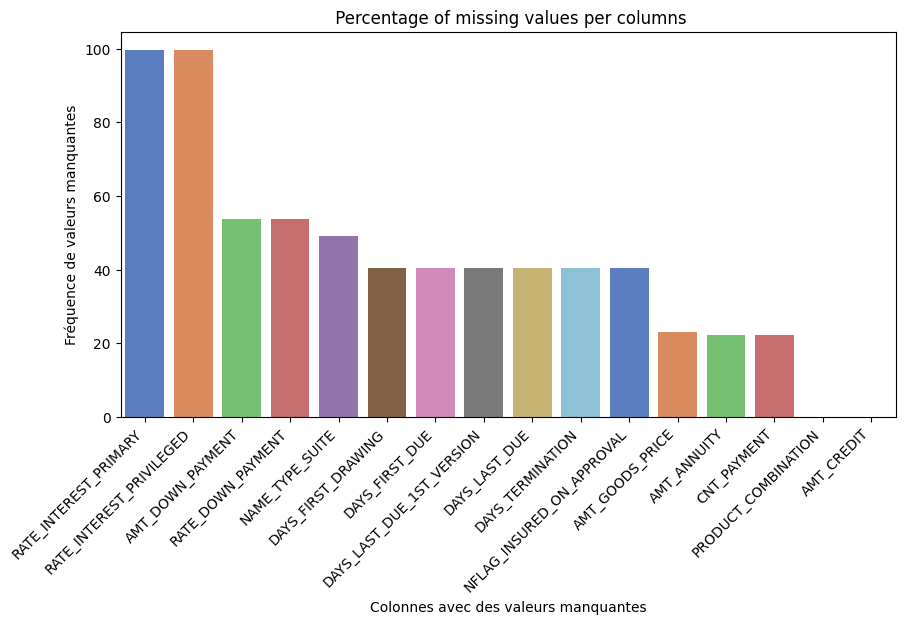

In [56]:
summary_describe(previous_application , figsize=(10,5))

# Analyse exploratoire approfondie sur le dataset ApplicationTrain

## Corrélation entre les variables 

#### split categorical, discrete and numerical features

In [57]:
def feature_type_split(data, special_list=[]):
    cat_list = []
    dis_num_list = []
    num_list = []
    for i in data.columns.tolist():
        if data[i].dtype == 'object':
            cat_list.append(i)
        elif data[i].nunique() < 25:
            dis_num_list.append(i)
        elif i in special_list:     # if you want to add some special cases
            dis_num_list.append(i)
        else:
            num_list.append(i)
    return cat_list, dis_num_list, num_list
cat_list, dis_num_list, num_list = feature_type_split(application_train, special_list=['AMT_REQ_CREDIT_BUREAU_YEAR']) 

In [58]:
print(str(len(cat_list)),'categorical features:', cat_list)
print('-----------------------------------------')
print(str(len(dis_num_list)),'discrete numerical features:',dis_num_list)
print('-----------------------------------------')
print(str(len(num_list)),'continuous numerical features:',num_list)

16 categorical features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
-----------------------------------------
47 discrete numerical features: ['TARGET', 'CNT_CHILDREN', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', '

#### Variables categorielles

Nous allons nous interesser à cat_list 

interval columns not set, guessing: ['TARGET']


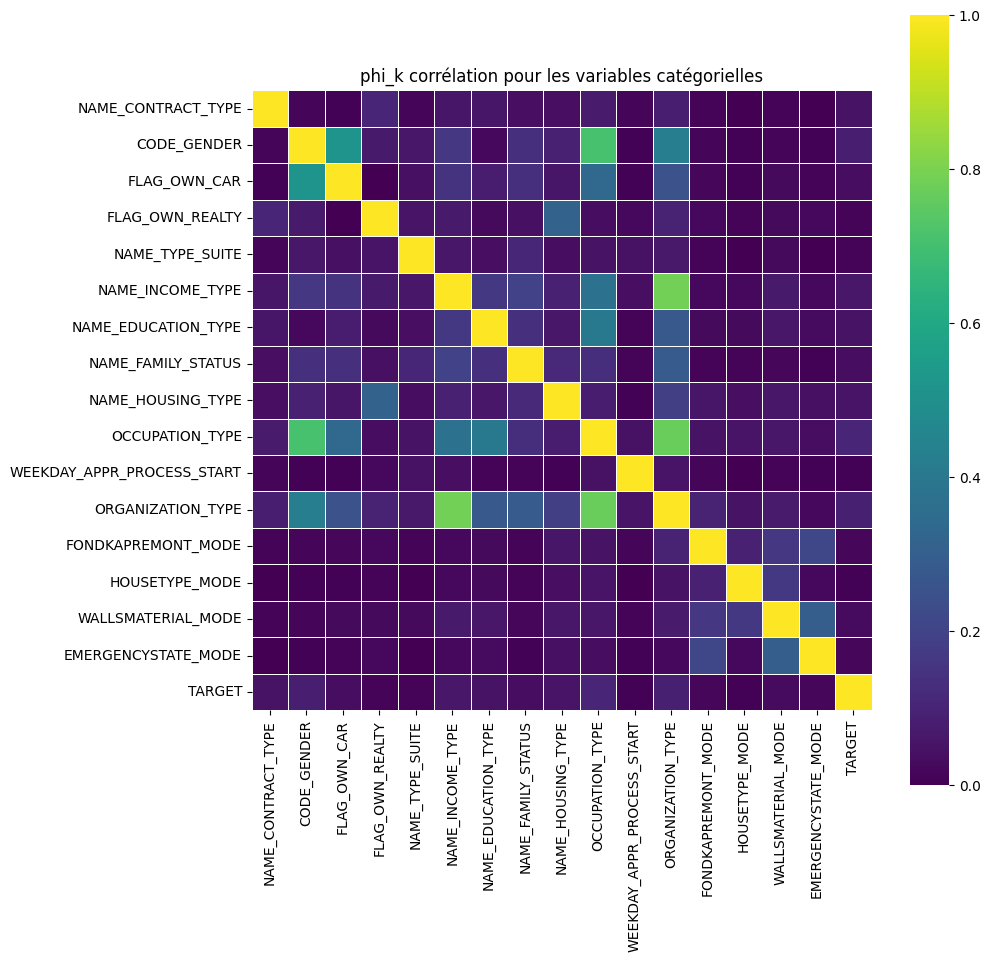

In [59]:
plot_correlation_matrix(application_train, quant_vars= None, cat_vars=cat_list+['TARGET'], figsize=(10,10 ))

In [60]:
# Les variables catégorielles les mieux corréllées avec Target
display(application_train[cat_list+['TARGET']].phik_matrix()['TARGET'].sort_values(ascending=False).head())

interval columns not set, guessing: ['TARGET']


TARGET               1.000000
OCCUPATION_TYPE      0.102846
ORGANIZATION_TYPE    0.089164
CODE_GENDER          0.085770
NAME_INCOME_TYPE     0.059365
Name: TARGET, dtype: float64

#### Variables quantitatives continues

In [61]:
new_num_list= [item for item in num_list if item != 'SK_ID_CURR']

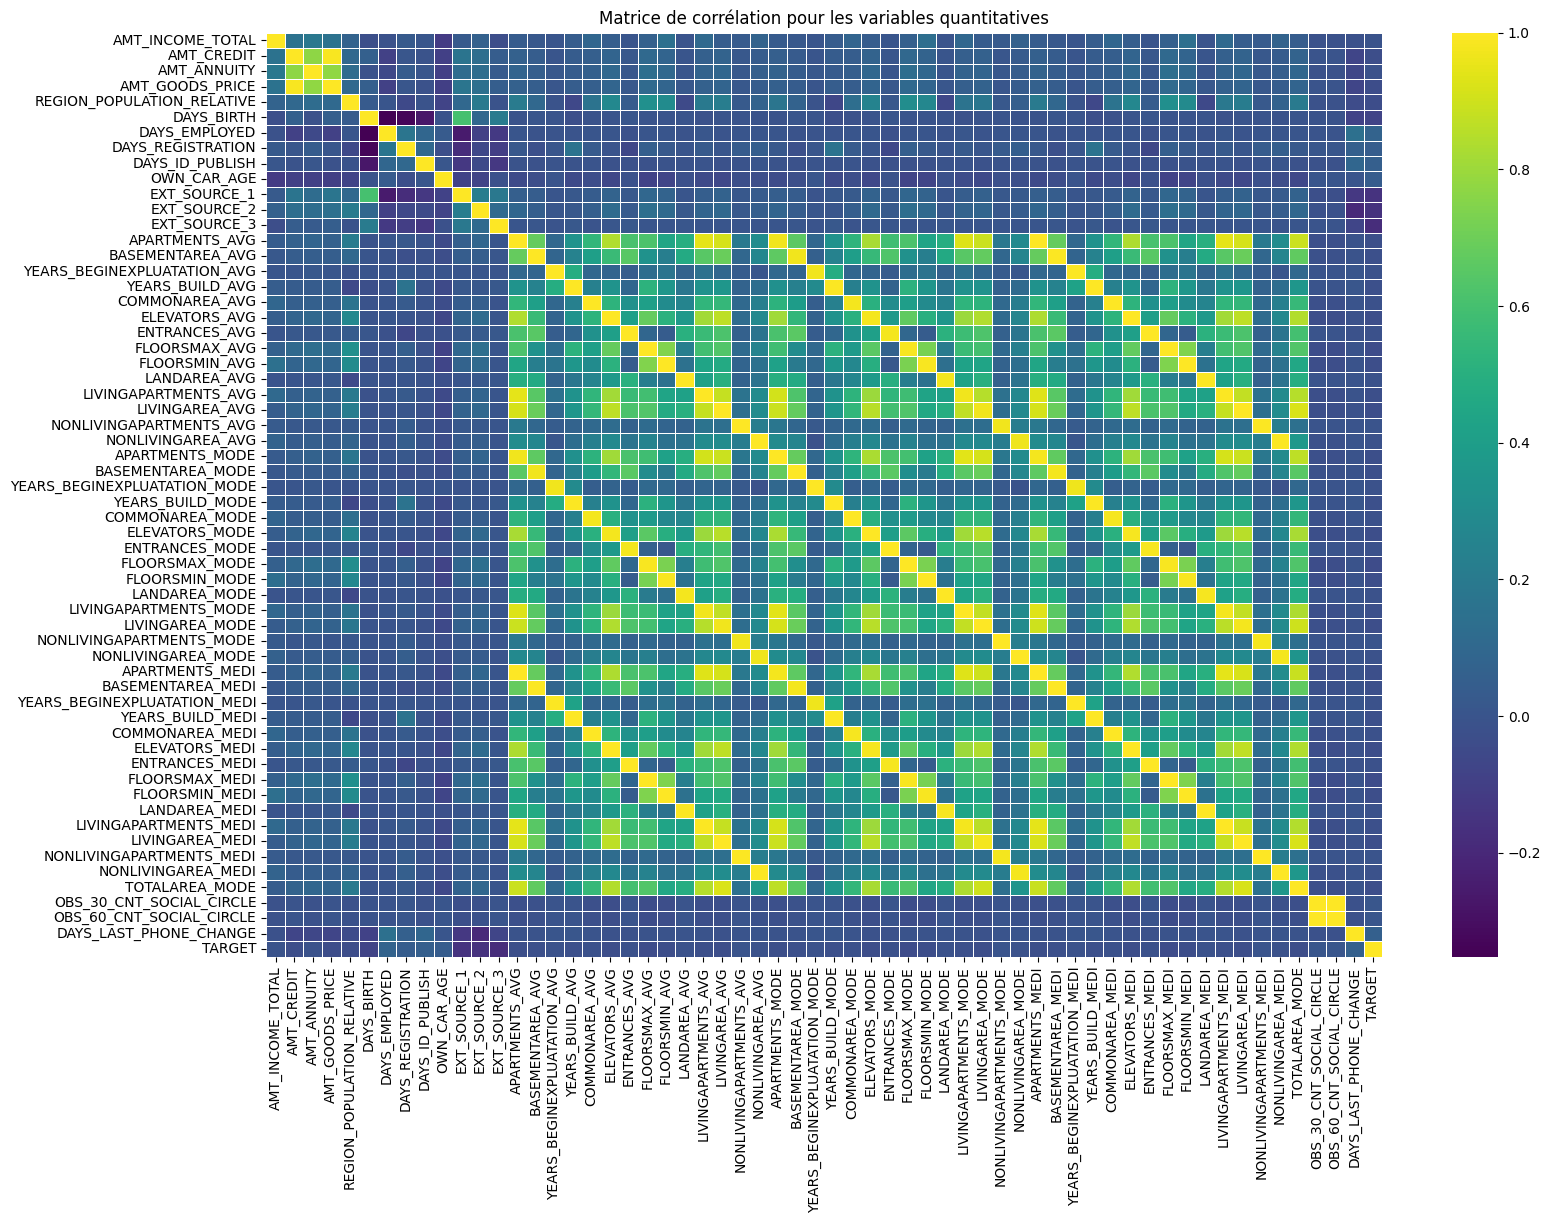

In [62]:
plot_correlation_matrix(application_train, quant_vars= new_num_list+['TARGET'], cat_vars= None, figsize=(18,12 ))

Variables quantitatives les plus correlées avec Target

In [63]:
application_train[new_num_list+['TARGET']].corr()['TARGET'].sort_values(ascending=False).head(10)

TARGET                      1.000000
DAYS_EMPLOYED               0.074958
DAYS_LAST_PHONE_CHANGE      0.055218
DAYS_ID_PUBLISH             0.051457
DAYS_REGISTRATION           0.041975
OWN_CAR_AGE                 0.037612
OBS_30_CNT_SOCIAL_CIRCLE    0.009131
OBS_60_CNT_SOCIAL_CIRCLE    0.009022
NONLIVINGAPARTMENTS_MODE   -0.001557
NONLIVINGAPARTMENTS_MEDI   -0.002757
Name: TARGET, dtype: float64

Variables quantitatives les plus décorrelées avec Target

In [64]:
application_train[new_num_list+['TARGET']].corr()['TARGET'].sort_values(ascending=True).head(10)

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_BIRTH                   -0.078239
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

#### Variables quantitatives discontinues

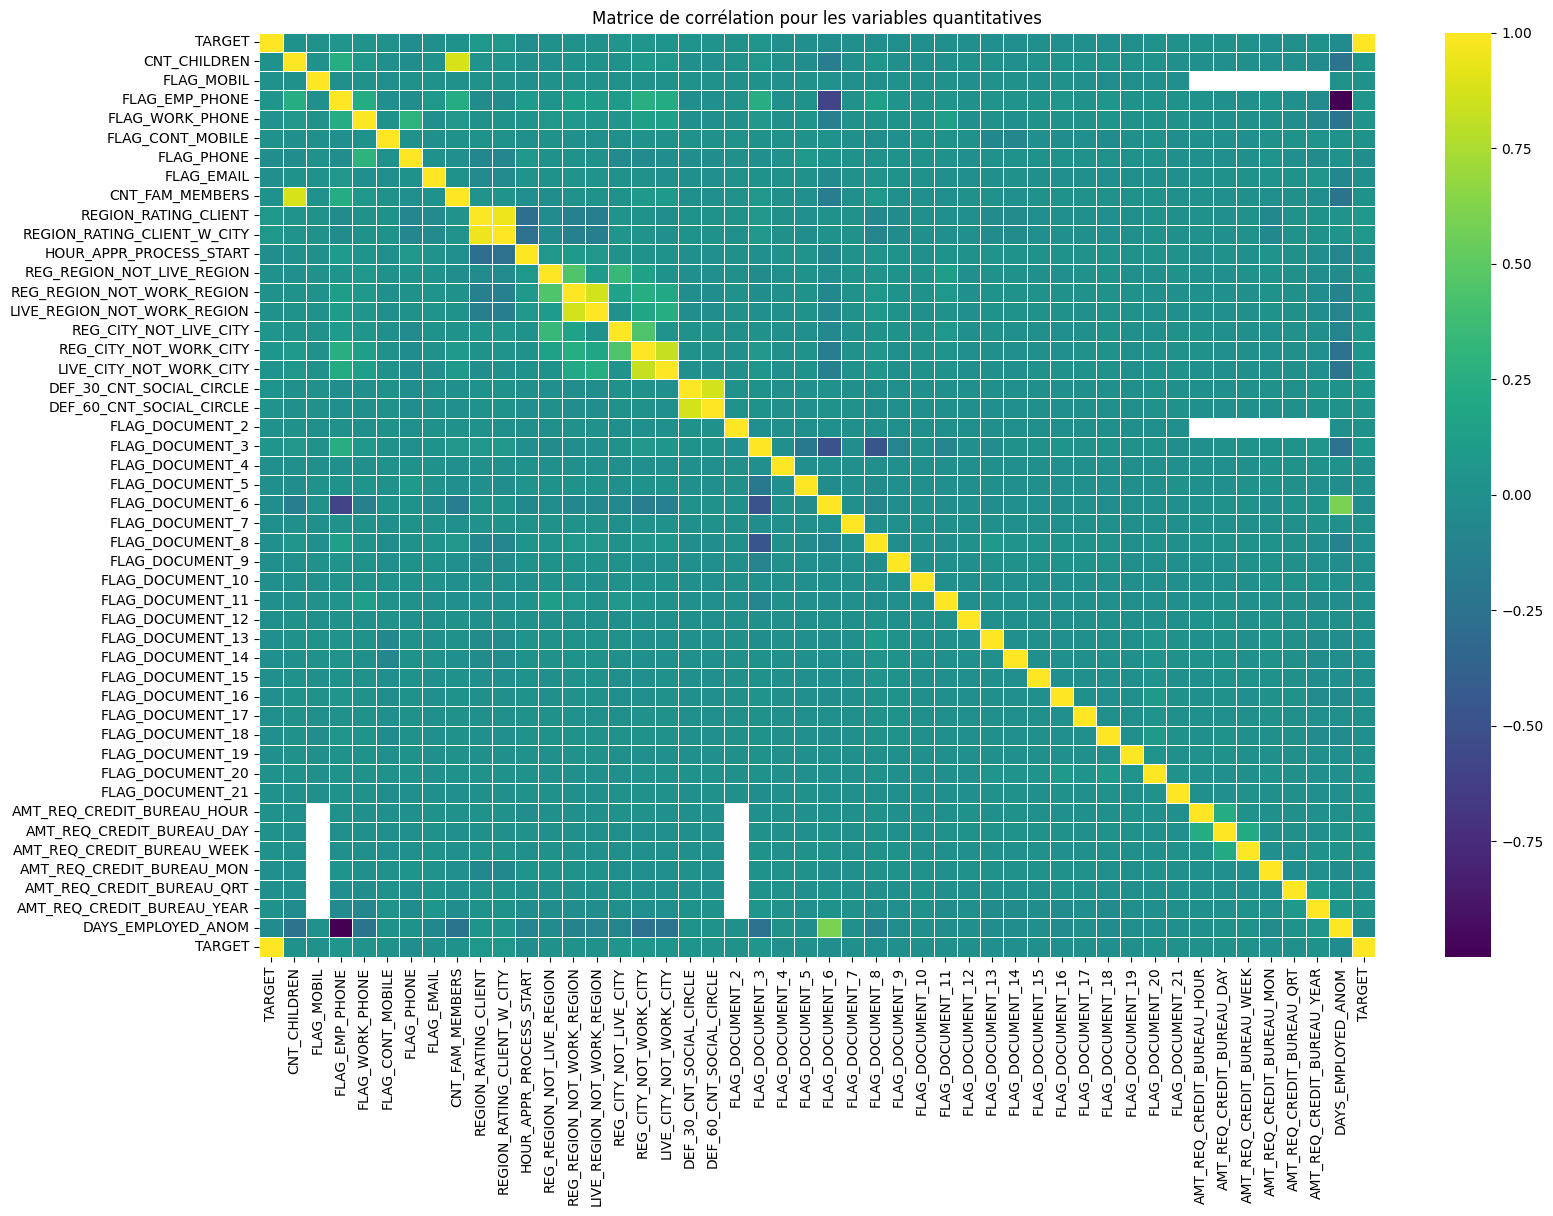

In [65]:
plot_correlation_matrix(application_train, quant_vars= dis_num_list+['TARGET'], cat_vars= None, figsize=(18,12 ))

## Visualisons la distribution de ces variables catégorielles en fonctions du la Target

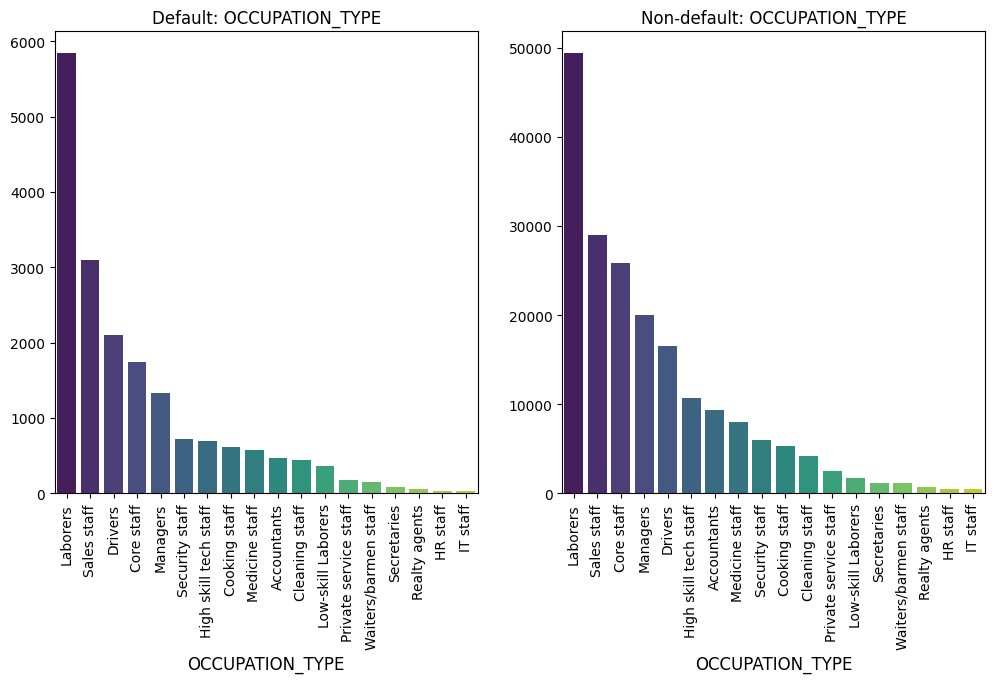

In [66]:
plot_categorical_bylabel(application_train, 'OCCUPATION_TYPE', xlabel_angle=90, title='OCCUPATION_TYPE', kind='bar')

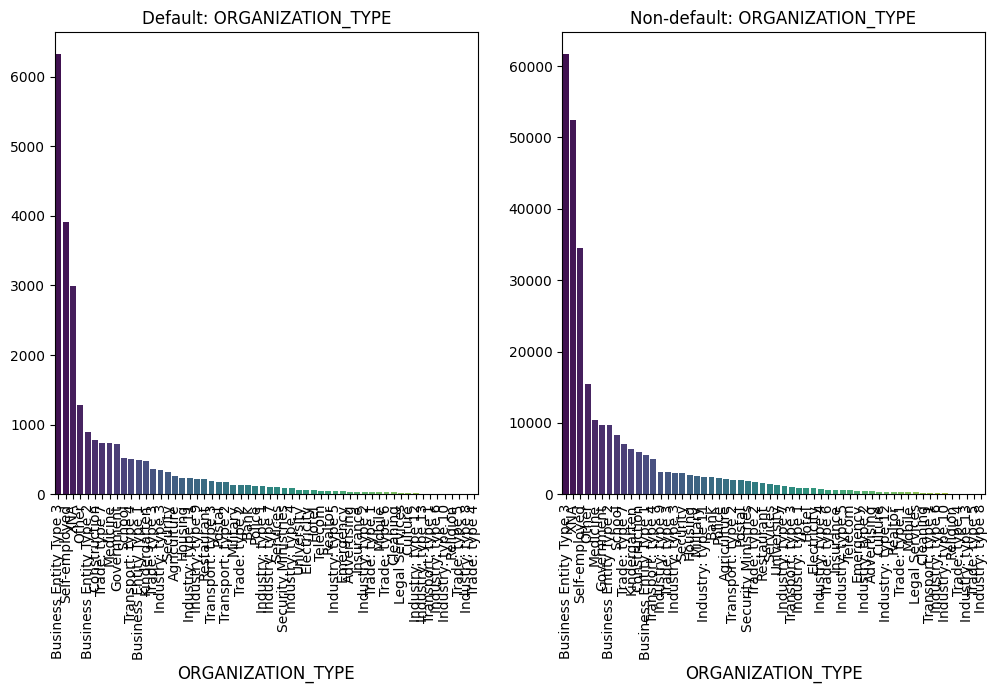

In [67]:
plot_categorical_bylabel(application_train, 'ORGANIZATION_TYPE', xlabel_angle=90, title='ORGANIZATION_TYPE', kind= 'bar')

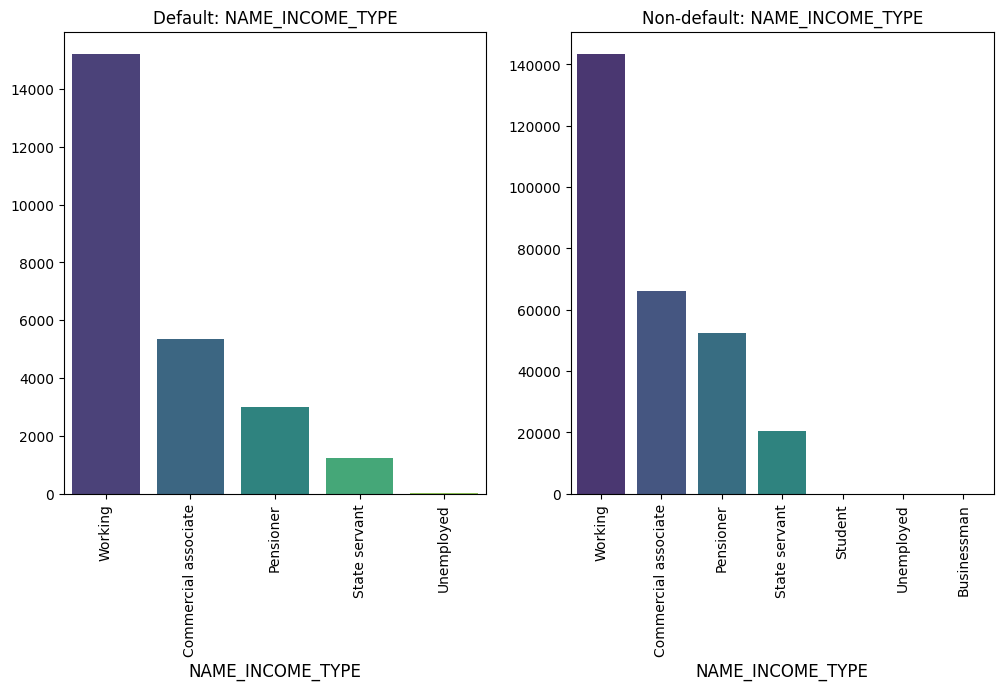

In [68]:
plot_categorical_bylabel(application_train, 'NAME_INCOME_TYPE', xlabel_angle=90, title='NAME_INCOME_TYPE', kind= 'bar')

## Visualisons la distribution de ces variables quantitatives en fonctions du la Target

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for repaid loans: 0.5460
Median value for not repaid loans: 0.3791


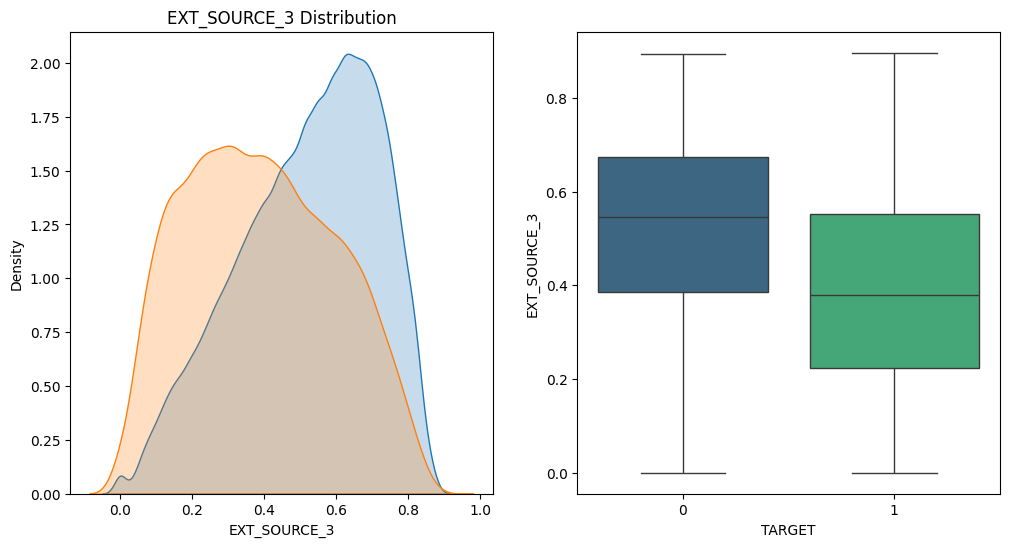

In [69]:
plot_numerical_bylabel(application_train, 'EXT_SOURCE_3')

The correlation between EXT_SOURCE_2 and the TARGET is -0.1605
Median value for repaid loans: 0.5739
Median value for not repaid loans: 0.4404


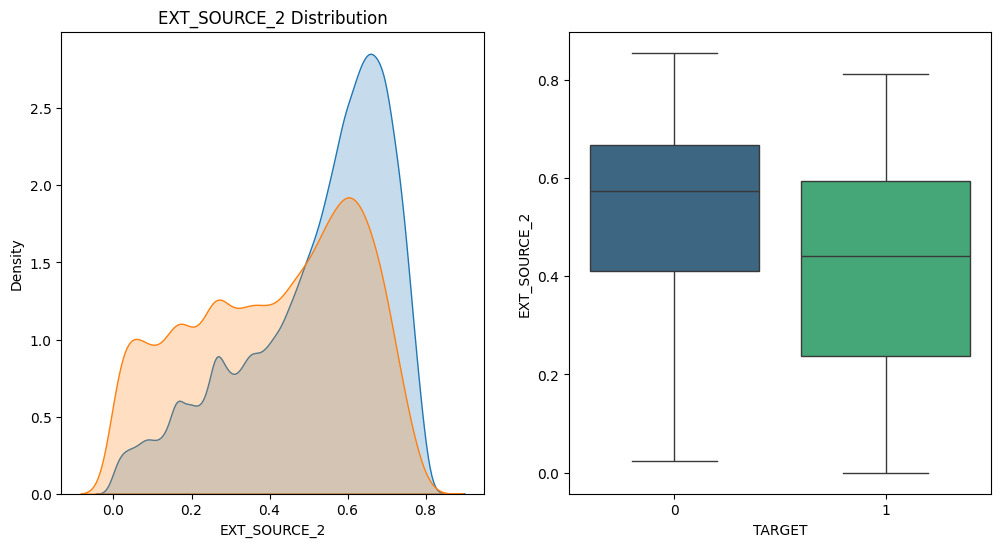

In [70]:
plot_numerical_bylabel(application_train, 'EXT_SOURCE_2')

The correlation between EXT_SOURCE_1 and the TARGET is -0.1553
Median value for repaid loans: 0.5175
Median value for not repaid loans: 0.3617


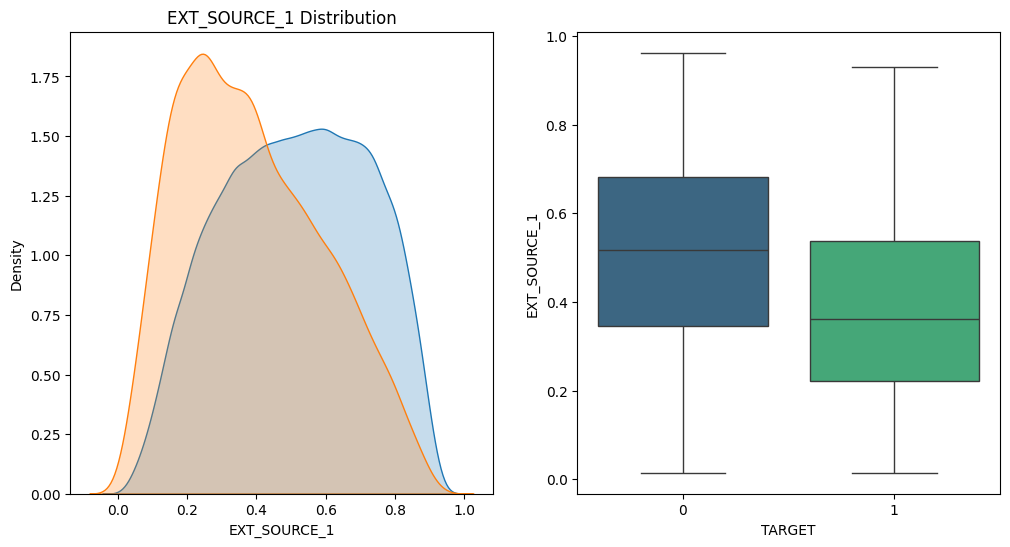

In [71]:
plot_numerical_bylabel(application_train, 'EXT_SOURCE_1')

The correlation between DAYS_BIRTH and the TARGET is -0.0782
Median value for repaid loans: 15877.0000
Median value for not repaid loans: 14282.0000


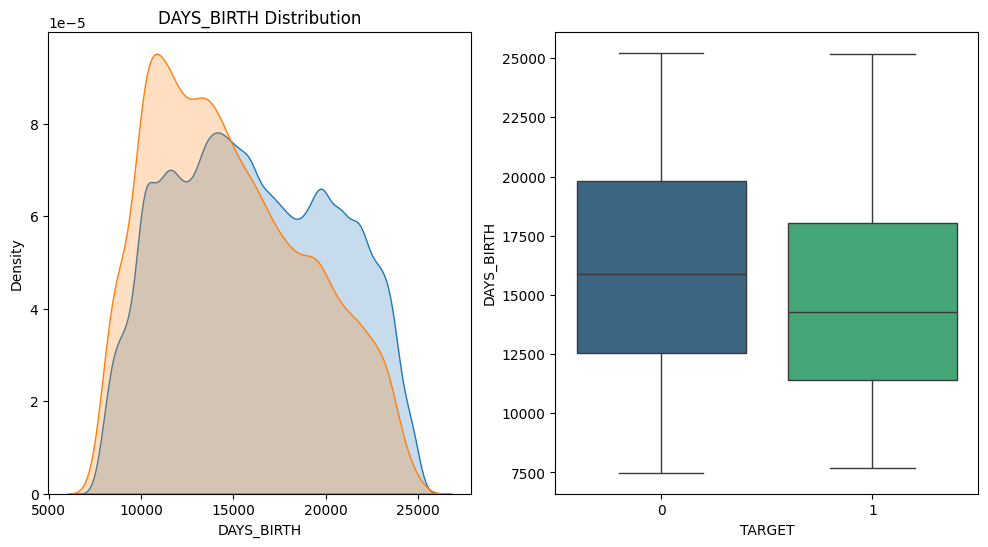

In [72]:
plot_numerical_bylabel(application_train, 'DAYS_BIRTH')

# Creation de nouveaux Features et Jointures avec d'autres tables

## Jointure avec les branches antérieures

### Feature Engineering dans avec la branche Previous_Application et la branche bureau

#### Branche bureau

Realisons un Merge entre bureau et bureau balance 

In [73]:
bureau = bureau.merge(bureau_balance, on='SK_ID_BUREAU', how ='left')

In [74]:
bureau.drop('SK_ID_BUREAU', axis = 1, inplace=True)
bureau.head()

SK_ID_CURR CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
0      215354        Closed      currency 1         -497                   0   
1      215354        Active      currency 1         -208                   0   
2      215354        Active      currency 1         -203                   0   
3      215354        Active      currency 1         -203                   0   
4      215354        Active      currency 1         -629                   0   

   DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0               -153.0             -153.0                     NaN   
1               1075.0                NaN                     NaN   
2                528.0                NaN                     NaN   
3                  NaN                NaN                     NaN   
4               1197.0                NaN                 77674.5   

   CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
0                   0         91323.0                  0.0   
1                   0        225000.0             171342.0   
2                   0        464323.5                  NaN   
3                   0         90000.0                  NaN   
4                   0       2700000.0                  NaN   

   AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  \
0                   NaN                     0.0  Consumer credit   
1                   NaN                     0.0      Credit card   
2                   NaN                     0.0  Consumer credit   
3                   NaN                     0.0      Credit card   
4                   NaN                     0.0  Consumer credit   

   DAYS_CREDIT_UPDATE  AMT_ANNUITY  MONTHS_BALANCE STATUS  
0                -131          NaN             NaN    NaN  
1                 -20          NaN             NaN    NaN  
2                 -16          NaN             NaN    NaN  
3                 -16          NaN             NaN    NaN  
4                 -21          NaN             NaN    NaN

In [75]:
mask= bureau['SK_ID_CURR']==215354
bureau[mask].mean(axis=0)

SK_ID_CURR                215354.000000
DAYS_CREDIT                 -727.818182
CREDIT_DAY_OVERDUE             0.000000
DAYS_CREDIT_ENDDATE         2685.300000
DAYS_ENDDATE_FACT           -889.800000
AMT_CREDIT_MAX_OVERDUE     25891.500000
CNT_CREDIT_PROLONG             0.000000
AMT_CREDIT_SUM            543085.936364
AMT_CREDIT_SUM_DEBT        47410.530000
AMT_CREDIT_SUM_LIMIT       36327.540000
AMT_CREDIT_SUM_OVERDUE         0.000000
DAYS_CREDIT_UPDATE          -367.272727
AMT_ANNUITY                         NaN
MONTHS_BALANCE                      NaN
STATUS                              NaN
dtype: float64

Ecriture de la fonction qui permettra d'aggreger nos  features à chacun des individus identifiés pas leur SK_ID_CURR

In [76]:
def aggregation(x):
    d = {}
    for name in x.columns:
        if name != 'SK_ID_CURR':
            if name in x.select_dtypes(include='object').columns:
                value_counts = x[name].value_counts()
                if not value_counts.empty:
                    d[f'mode_{name}'] = value_counts.index[0]
                else:
                    d[f'mode_{name}'] = None
            if name in x.select_dtypes(include=['int64', 'float']).columns:
                d[f'mean_{name}'] = np.round(x[name].mean(),0)
    return pd.Series(d)
    
def process_data_with_chunks(data, chunk_size, groupby_column):
    agg_result = pd.DataFrame()
    indices = np.arange(0, data.shape[0], chunk_size)

    for i in tqdm(indices, desc='Processing chunks'):
        chunk_result = data.iloc[i:i+chunk_size].groupby(groupby_column).apply(aggregation)
        agg_result = agg_result.append(chunk_result, ignore_index=False)

    return agg_result.reset_index()

In [77]:
bureau.sort_values(by='SK_ID_CURR', ascending=True, inplace=True)
bureau.head()

SK_ID_CURR CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
3795221      100001        Closed      currency 1         -909   
3795251      100001        Closed      currency 1         -879   
3795250      100001        Closed      currency 1         -879   
3795249      100001        Closed      currency 1         -879   
3795248      100001        Closed      currency 1         -879   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
3795221                   0               -179.0             -877.0   
3795251                   0               -514.0             -544.0   
3795250                   0               -514.0             -544.0   
3795249                   0               -514.0             -544.0   
3795248                   0               -514.0             -544.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
3795221                     NaN                   0        279720.0   
3795251                     NaN                   0         91620.0   
3795250                     NaN                   0         91620.0   
3795249                     NaN                   0         91620.0   
3795248                     NaN                   0         91620.0   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
3795221                  0.0                   0.0                     0.0   
3795251                  0.0                   0.0                     0.0   
3795250                  0.0                   0.0                     0.0   
3795249                  0.0                   0.0                     0.0   
3795248                  0.0                   0.0                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  MONTHS_BALANCE  \
3795221  Consumer credit                -155          0.0           -10.0   
3795251  Consumer credit                -155          0.0           -10.0   
3795250  Consumer credit                -155          0.0            -9.0   
3795249  Consumer credit                -155          0.0            -8.0   
3795248  Consumer credit                -155          0.0            -7.0   

        STATUS  
3795221      C  
3795251      C  
3795250      C  
3795249      C  
3795248      C

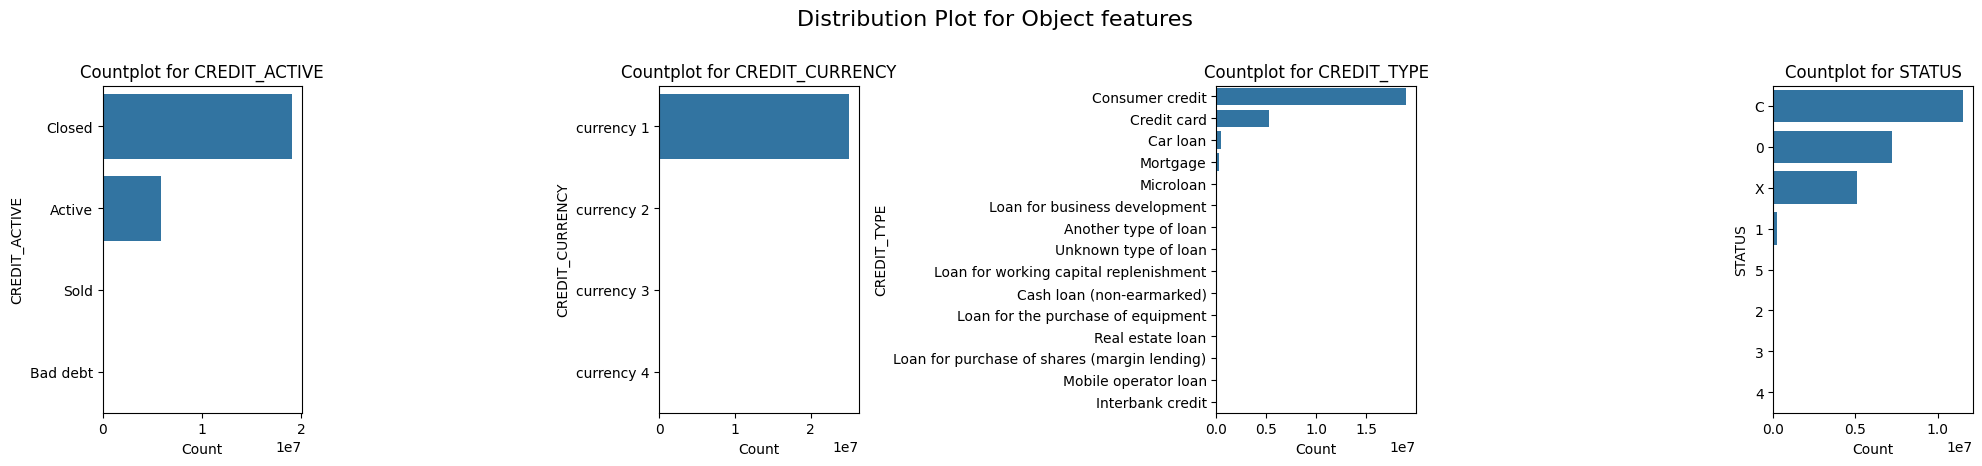

In [78]:
plot_data(bureau, type='object', boxplot=True)

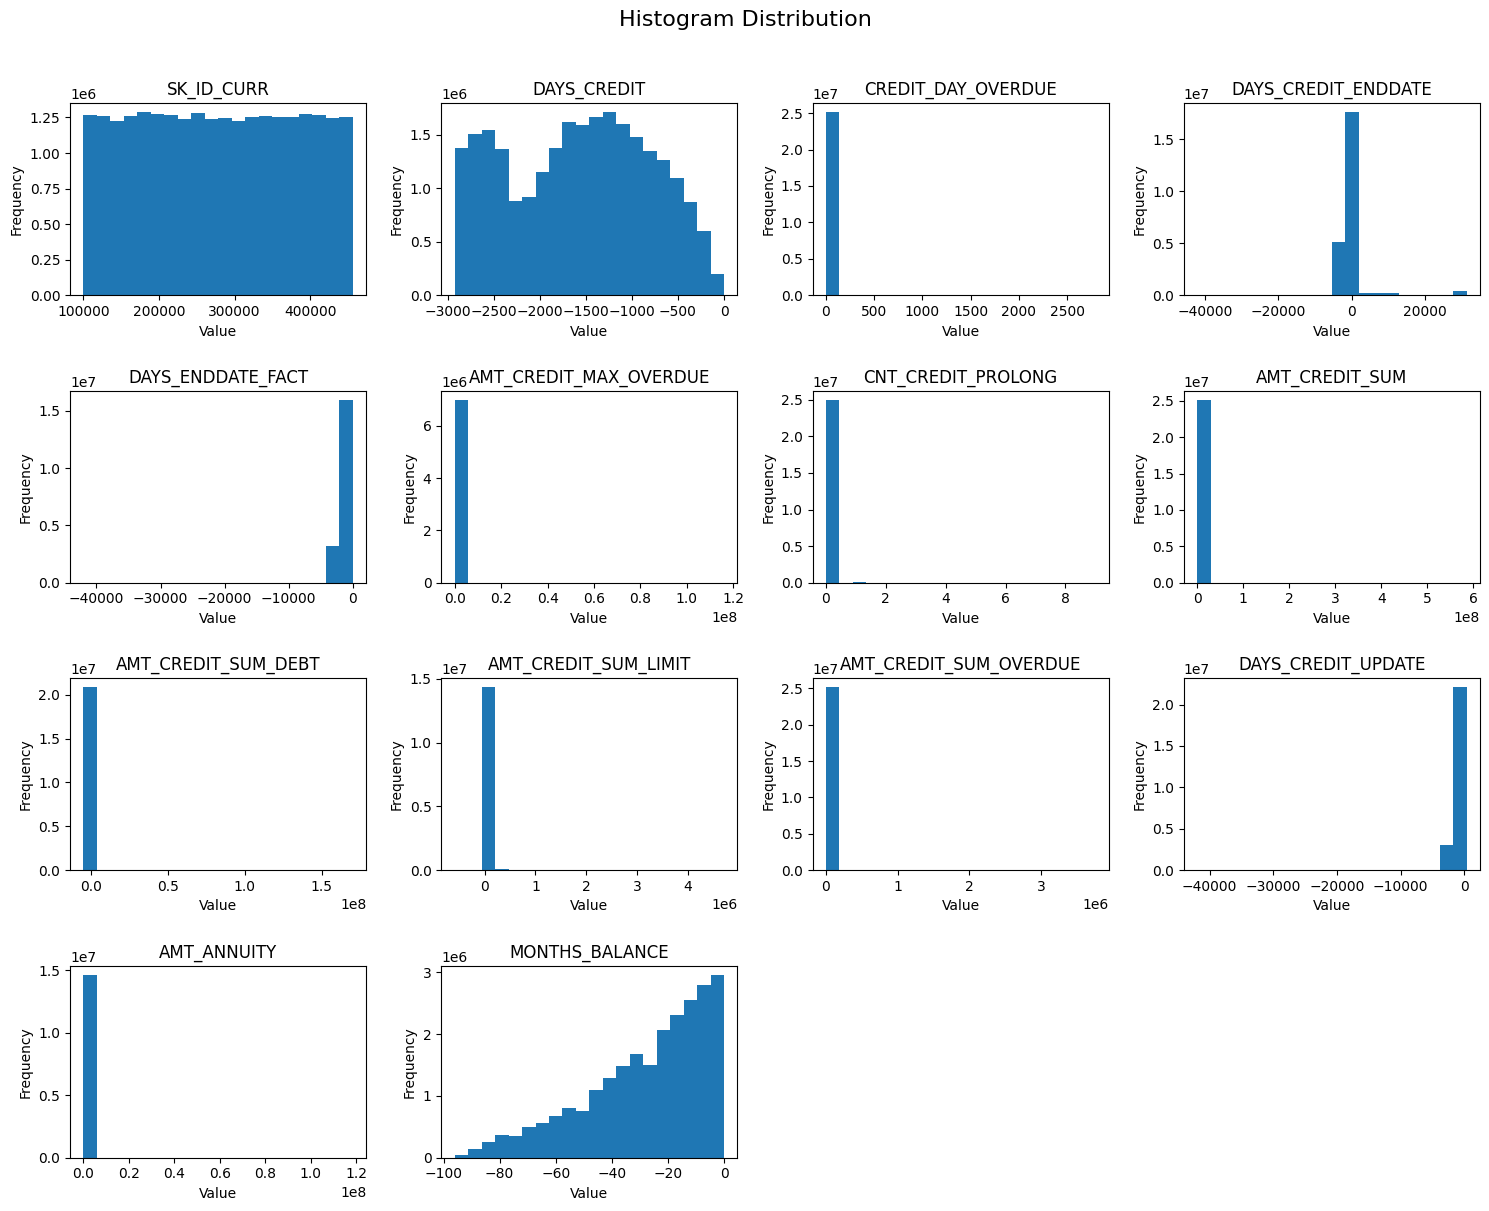

In [79]:
plot_numerical_data(bureau , boxplot=False)

d'après les histogrammes l'on réalise qu'il existe dans valeurs abérantes sur la feature days_credit_update

In [80]:
def impute_outliers(data, column_name):
    
    df=data.copy()
    
    # Calcul du 9ème quantile (Q9) et de la médiane
    Q9 = df[column_name].quantile(0.1)
    median_value = df[column_name].median()

    # Identification des valeurs aberrantes
    outliers_mask = df[column_name] > Q9 if Q9 >= 0 else df[column_name] < Q9

    # Imputation des valeurs aberrantes par la médiane
    df[column_name] = np.where(outliers_mask, median_value, df[column_name])

    return df

In [81]:
bureau = impute_outliers(bureau,'DAYS_CREDIT_UPDATE')

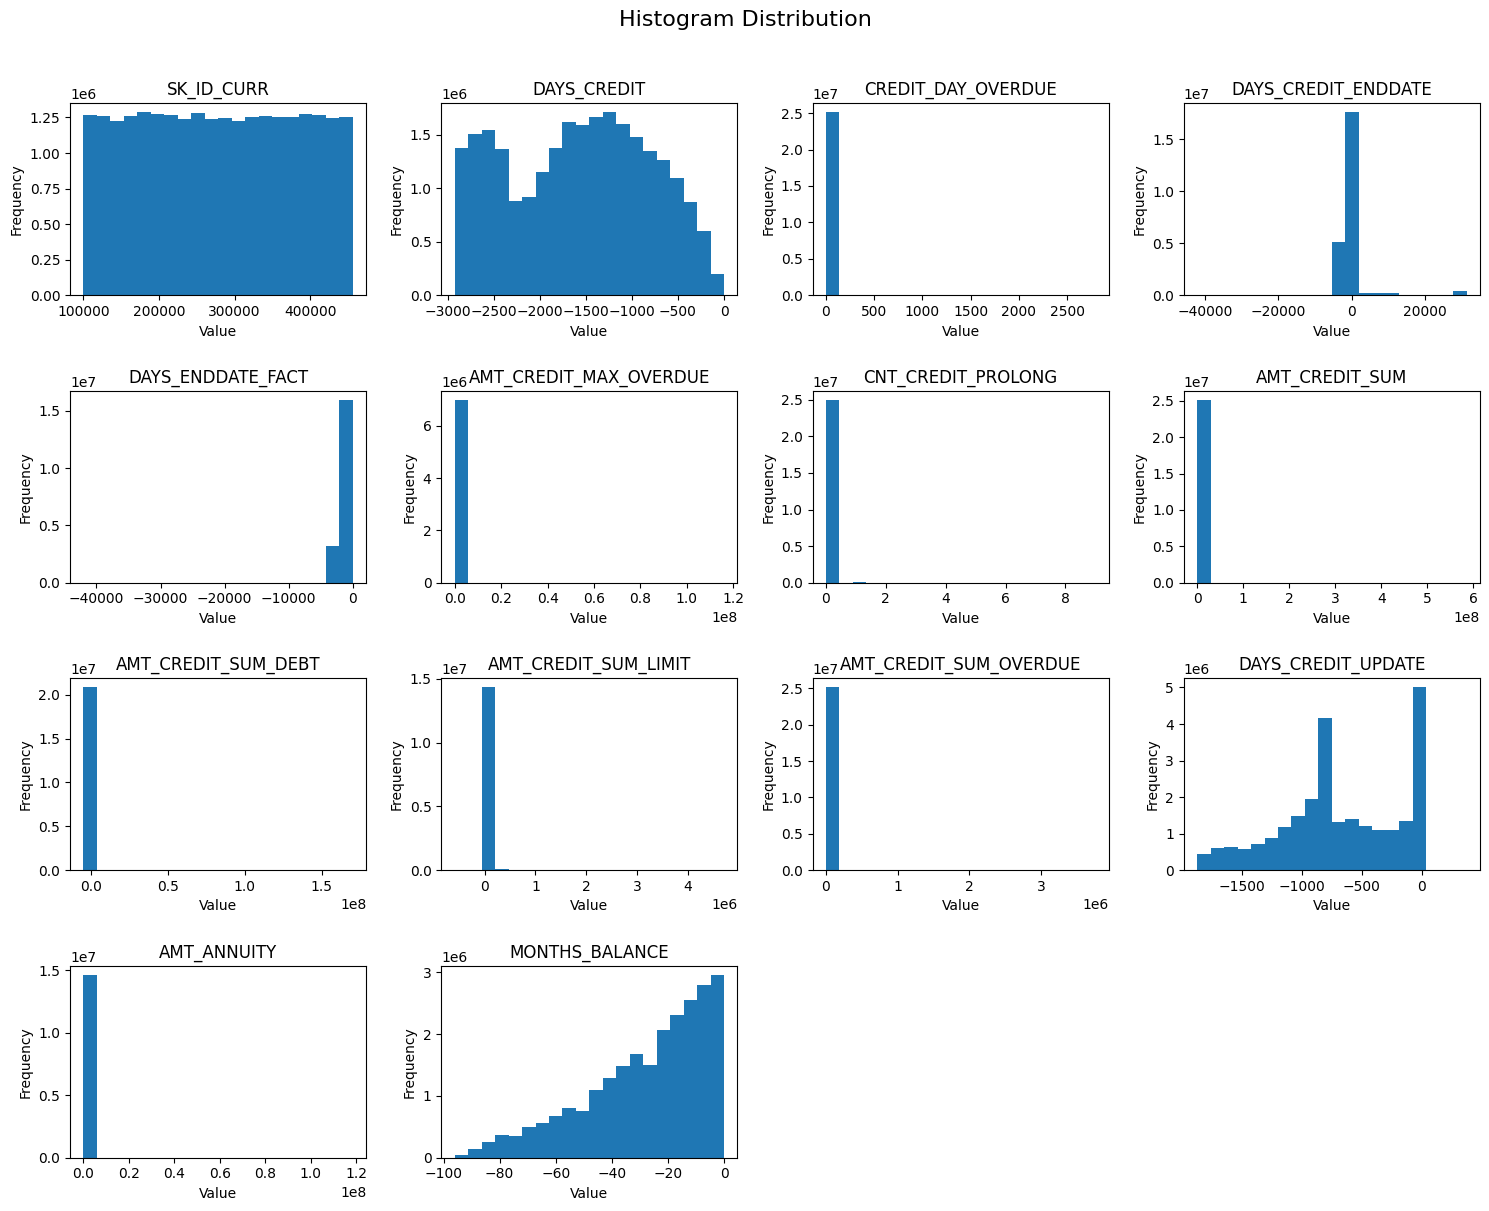

In [82]:
plot_numerical_data(bureau , boxplot=False)

#### Agregeons Bureau

In [83]:
# # Exemple d'utilisation
# chunk_size = 5200000
# groupby_column = 'SK_ID_CURR'
# agg_bureau = process_data_with_chunks(bureau, chunk_size, groupby_column)

In [84]:
# agg_bureau.to_csv('agg_bureau.csv', index=False)

In [85]:
agg_bureau=pd.read_csv('agg_bureau.csv')
agg_bureau.head()

SK_ID_CURR mode_CREDIT_ACTIVE mode_CREDIT_CURRENCY  mean_DAYS_CREDIT  \
0           100001             Closed           currency 1           -1009.0   
1           100002             Closed           currency 1            -997.0   
2           100003             Closed           currency 1           -1401.0   
3           100004             Closed           currency 1            -867.0   
4           100005             Closed           currency 1            -272.0   
...            ...                ...                  ...               ...   
305810      456249             Closed           currency 1           -1667.0   
305811      456250             Active           currency 1            -872.0   
305812      456253             Closed           currency 1            -877.0   
305813      456254             Closed           currency 1           -1104.0   
305814      456255             Closed           currency 1           -1262.0   

        mean_CREDIT_DAY_OVERDUE  mean_DAYS_CREDIT_ENDDATE  \
0                           0.0                    -456.0   
1                           0.0                    -452.8   
2                           0.0                    -544.5   
3                           0.0                    -488.5   
4                           0.0                     253.4   
...                         ...                       ...   
305810                      0.0                   -1232.3   
305811                      0.0                    1187.0   
305812                      0.0                     230.7   
305813                      0.0                    -859.0   
305814                      0.0                    1984.5   

        mean_DAYS_ENDDATE_FACT  mean_AMT_CREDIT_MAX_OVERDUE  \
0                       -908.4                          NaN   
1                       -808.4                       1312.0   
2                      -1097.3                          0.0   
3                       -532.5                          0.0   
4                       -123.0                          0.0   
...                        ...                          ...   
305810                 -1364.8                       6147.0   
305811                  -760.0                          0.0   
305812                  -794.0                          NaN   
305813                  -859.0                          NaN   
305814                  -976.1                      13630.0   

        mean_CNT_CREDIT_PROLONG  mean_AMT_CREDIT_SUM  \
0                           0.0             161516.2   
1                           0.0             111388.8   
2                           0.0             254350.1   
3                           0.0              94518.9   
4                           0.0             175903.7   
...                         ...                  ...   
305810                      0.0             284143.0   
305811                      0.0             971625.2   
305812                      0.0             914615.4   
305813                      0.0              45000.0   
305814                      0.0             342536.5   

        mean_AMT_CREDIT_SUM_DEBT  mean_AMT_CREDIT_SUM_LIMIT  \
0                        23893.8                        0.0   
1                        70223.1                     3198.9   
2                            0.0                   202500.0   
3                            0.0                        0.0   
4                       132923.8                        0.0   
...                          ...                        ...   
305810                   16307.1                        0.0   
305811                  676051.8                    18753.0   
305812                  378608.9                        0.0   
305813                       0.0                        NaN   
305814                  179242.1                        0.0   

        mean_AMT_CREDIT_SUM_OVERDUE mode_CREDIT_TYPE  mean_DAYS_CREDIT_UPDATE  \
0                               0.0  Consumer 

Avant fusion avec les tables principales l'on visualise la distribution des données dans le dataframe bureau aggrégé

In [86]:
agg_bureau.drop_duplicates(subset='SK_ID_CURR', inplace=True)

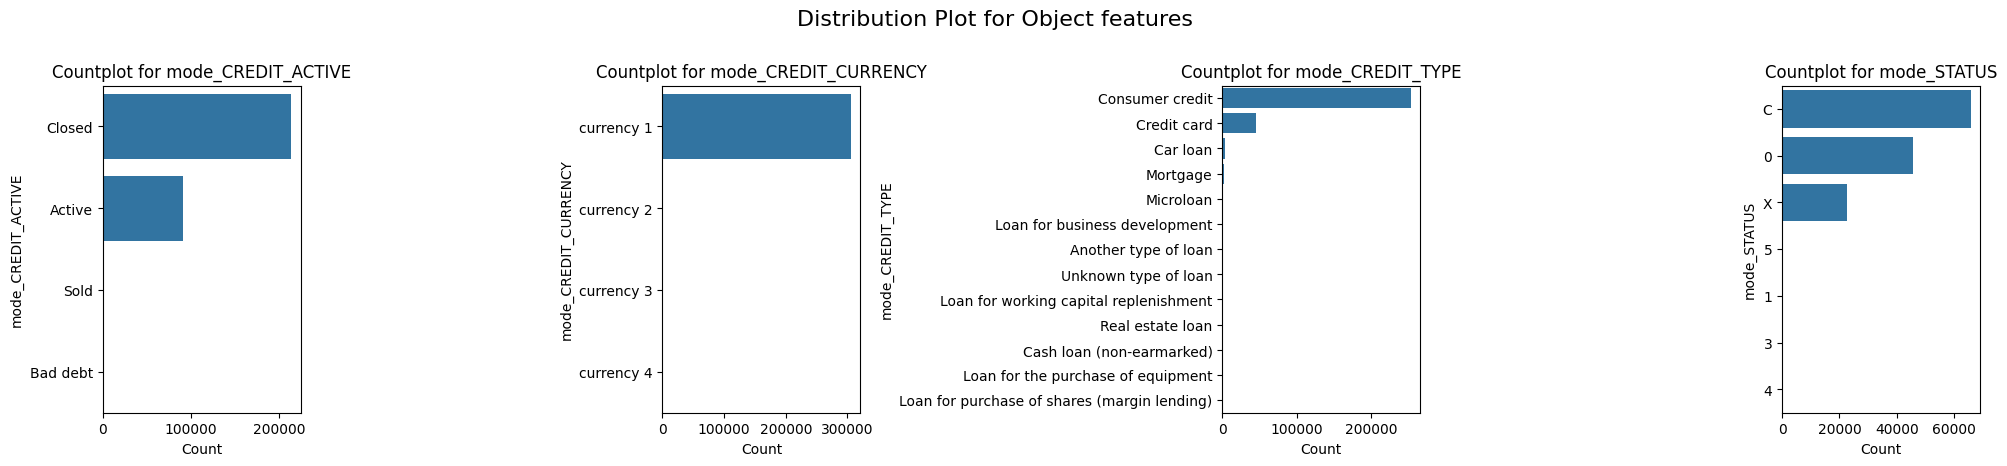

In [87]:
plot_data(agg_bureau, type='object', boxplot=True)

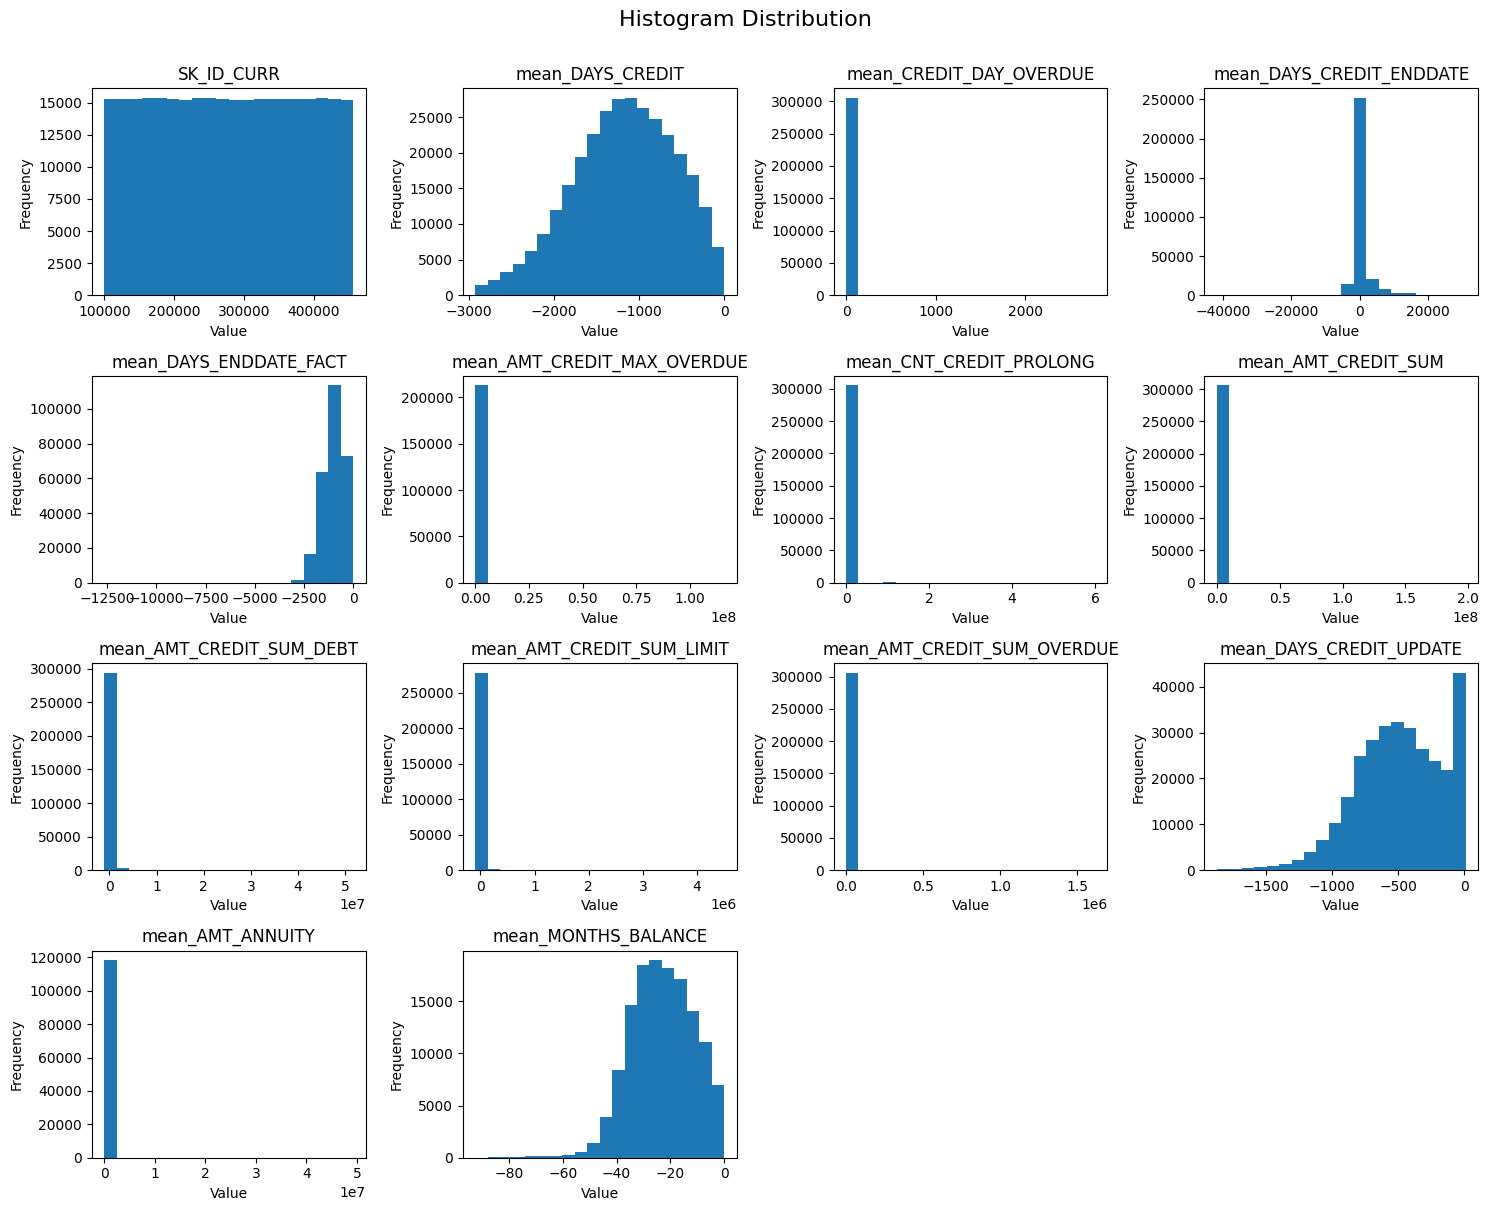

In [88]:
plot_numerical_data(agg_bureau , boxplot=False)

#### Branche Previous_application

verifions s'il existe des features semblables entre credit_card_balance et application_train

In [90]:
credit_card_balance.columns.intersection(application_train.columns)

Index(['SK_ID_CURR'], dtype='object')

verifions s'il existe des features semblables entre installments_payments et application_train

In [91]:
installments_payments.columns.intersection(application_train.columns)

Index(['SK_ID_CURR'], dtype='object')

verifions s'il existe des features semblables entre previous_application et credit_card_balance

In [92]:
previous_application.columns.intersection(credit_card_balance.columns)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'], dtype='object')

verifions s'il existe des features semblables entre previous_application et installments_payments

In [93]:
previous_application.columns.intersection(installments_payments.columns)

Index(['SK_ID_PREV', 'SK_ID_CURR'], dtype='object')

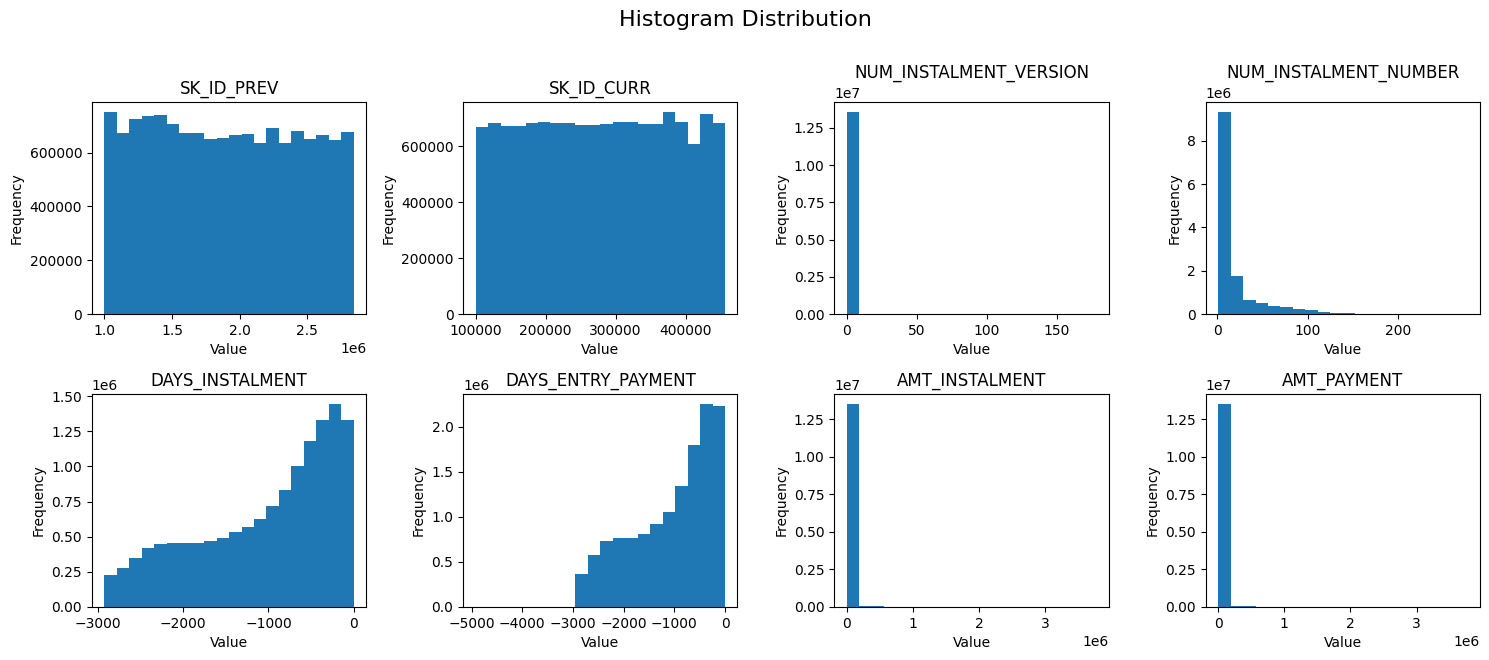

In [94]:
plot_numerical_data(installments_payments, boxplot=False)

visiblement pas de valeurs abérrantes

Jointure entre previous application et installments_payments

In [95]:
previous_application = pd.merge(previous_application,installments_payments.drop(['SK_ID_CURR'], axis=1), how='left', on='SK_ID_PREV')

In [96]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2802425      108129         Cash loans    25188.615         607500.0   
3     2802425      108129         Cash loans    25188.615         607500.0   
4     2802425      108129         Cash loans    25188.615         607500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    679671.0               NaN         607500.0                   THURSDAY   
3    679671.0               NaN         607500.0                   THURSDAY   
4    679671.0               NaN         607500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
0                       15  ...                     300.0          -42.0   
1                       11  ...                     916.0       365243.0   
2                       11  ...                     916.0       365243.0   
3                       11  ...                     916.0       365243.0   
4                       11  ...                     916.0       365243.0   

   DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL  NUM_INSTALMENT_VERSION  \
0             -37.0                        0.0                     2.0   
1          365243.0                        1.0                     1.0   
2          365243.0                        1.0                     1.0   
3          365243.0                        1.0                     1.0   
4          365243.0                        1.0                     1.0   

  NUM_INSTALMENT_NUMBER DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT AMT_INSTALMENT  \
0                   1.0           -42.0               -42.0      17284.275   
1                   2.0          -104.0              -111.0      25188.615   
2                   5.0           -14.0               -24.0      25188.615   
3                   1.0          -134.0              -144.0      25188.615   
4                   4.0           -44.0               -55.0      25188.615   

  AMT_PAYMENT  
0   17284.275  
1   25188.615  
2   25188.615  
3   25188.615  
4   25188.615  

[5 rows x 43 columns]

In [97]:
previous_application.drop(['SK_ID_PREV'], axis=1, inplace=True)

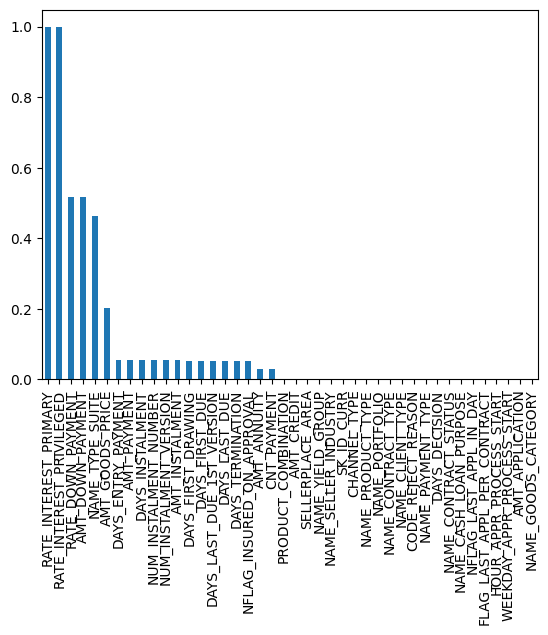

In [98]:
previous_application.isna().mean().sort_values(ascending=False).plot(kind='bar')
plt.show()

l'on va supprimer les features avec des valeurs manquantes superieures à 18%

In [99]:
mask =previous_application.isna().mean()>0.18
drop_list=mask[mask].index
print(drop_list)

Index(['AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_TYPE_SUITE'],
      dtype='object')


In [100]:
mask =previous_application.isna().mean()>0.18
drop_list=mask[mask].index
previous_application.drop(drop_list, axis=1, inplace=True)

In [101]:
def aggregate_numerical(data):
    numerical_list = list(data.drop('SK_ID_CURR', axis=1).select_dtypes(exclude='object').columns)
    result_numerical = data.groupby(by='SK_ID_CURR')[numerical_list].mean().round(0).reset_index()
    return result_numerical

def aggregate_categorical(data):
    categorical_list = list(data.select_dtypes(include='object').columns)
    result_categorical = data.groupby('SK_ID_CURR')[categorical_list].agg('first').reset_index()
    return result_categorical

#### Agregeons Previous_application

In [103]:
# result_numerical = aggregate_numerical(previous_application)
# result_categorical = aggregate_categorical(previous_application)
# agg_previous_application = pd.concat([result_numerical, result_categorical.drop('SK_ID_CURR', axis=1)], axis=1)

In [108]:
agg_previous_application.to_csv('agg_previous_application.csv', index=False)

In [109]:
agg_previous_application=pd.read_csv('agg_previous_application.csv')
agg_previous_application.head()

SK_ID_CURR  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  \
0      100001       3951.0          24836.0     23787.0   
1      100002       9252.0         179055.0    179055.0   
2      100003      46270.0         366029.0    406386.0   
3      100004       5357.0          24282.0     20106.0   
4      100005       4813.0          40156.0     36138.0   

   HOUR_APPR_PROCESS_START  NFLAG_LAST_APPL_IN_DAY  DAYS_DECISION  \
0                     13.0                     1.0        -1740.0   
1                      9.0                     1.0         -606.0   
2                     15.0                     1.0        -1531.0   
3                      5.0                     1.0         -815.0   
4                     11.0                     1.0         -713.0   

   SELLERPLACE_AREA  CNT_PAYMENT  DAYS_FIRST_DRAWING  ...  \
0              23.0          8.0            365243.0  ...   
1             500.0         24.0            365243.0  ...   
2             432.0         11.0            365243.0  ...   
3              30.0          4.0            365243.0  ...   
4              33.0         12.0            365243.0  ...   

       NAME_PAYMENT_TYPE  CODE_REJECT_REASON  NAME_CLIENT_TYPE  \
0  Cash through the bank                 XAP         Refreshed   
1                    XNA                 XAP               New   
2                    XNA                 XAP          Repeater   
3  Cash through the bank                 XAP               New   
4                    XNA                 XAP          Repeater   

   NAME_GOODS_CATEGORY  NAME_PORTFOLIO  NAME_PRODUCT_TYPE  \
0               Mobile             POS                XNA   
1             Vehicles             POS                XNA   
2                  XNA            Cash             x-sell   
3               Mobile             POS                XNA   
4                  XNA             XNA                XNA   

              CHANNEL_TYPE  NAME_SELLER_INDUSTRY  NAME_YIELD_GROUP  \
0             Country-wide          Connectivity              high   
1                    Stone       Auto technology        low_normal   
2  Credit and cash offices                   XNA        low_normal   
3         Regional / Local          Connectivity            middle   
4  Credit and cash offices                   XNA               XNA   

           PRODUCT_COMBINATION  
0     POS mobile with interest  
1      POS other with interest  
2             Cash X-Sell: low  
3  POS mobile without interest  
4                         Cash  

[5 rows x 36 columns]

In [106]:
agg_previous_application[].columns.intersection(application_train.columns)

Index(['SK_ID_CURR', 'AMT_ANNUITY', 'AMT_CREDIT', 'HOUR_APPR_PROCESS_START',
       'NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START'],
      dtype='object')

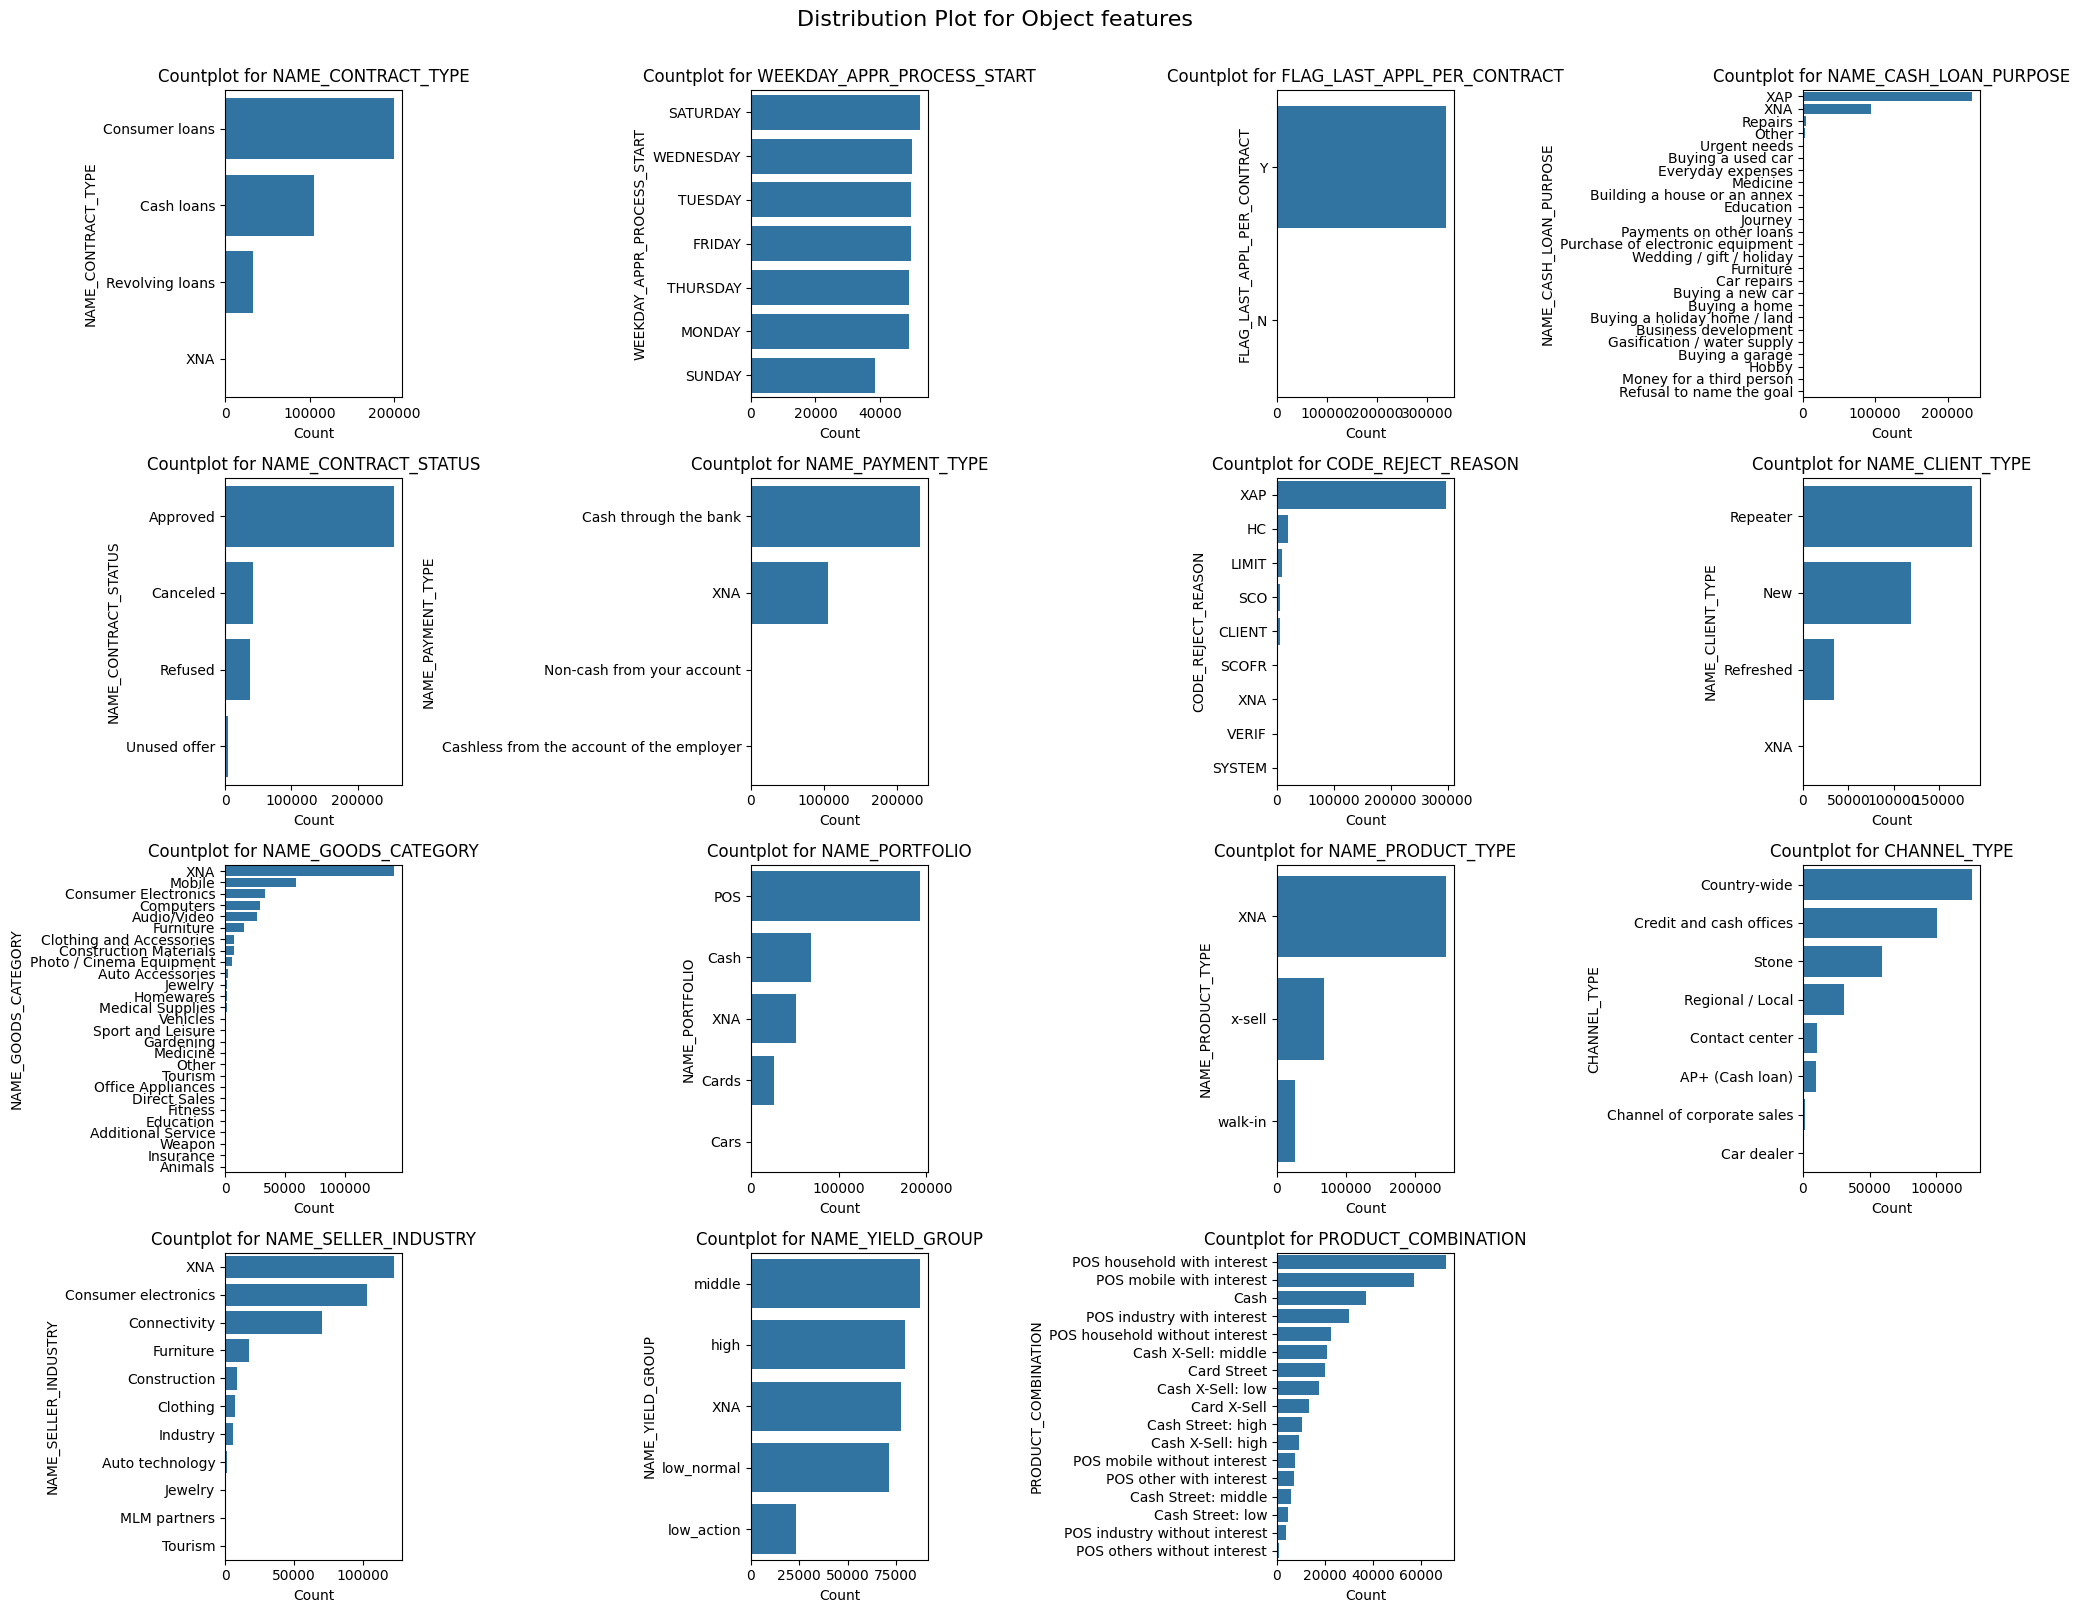

In [107]:
plot_data(agg_previous_application, type='object', boxplot=False)

## Features Engineering

In [111]:
# TERM: total credit / annuity
application_train['TERM'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY']
application_test['TERM'] = application_test['AMT_CREDIT'] / application_test['AMT_ANNUITY']

# OVER_EXPECT_CREDIT: actual credit larger than goods price
application_train['OVER_EXPECT_CREDIT'] = (application_train['AMT_CREDIT'] > application_train['AMT_GOODS_PRICE']).astype(int)
application_test['OVER_EXPECT_CREDIT'] = (application_test['AMT_CREDIT'] > application_test['AMT_GOODS_PRICE']).astype(int)

# AMT_REQ_CREDIT_BUREAU_TOTAL: the total number of enquiries
application_train['AMT_REQ_CREDIT_BUREAU_TOTAL'] = application_train.iloc[:, 116:122].sum(axis=1)
application_test['AMT_REQ_CREDIT_BUREAU_TOTAL'] = application_test.iloc[:, 116:122].sum(axis=1)

# BIRTH_EMPLOYED_INTERVAL: the days between born and employed
application_train['BIRTH_EMPLOYED_INTERVAL'] = application_train['DAYS_EMPLOYED'] + application_train['DAYS_BIRTH']
application_test['BIRTH_EMPLOYED_INTERVAL'] = application_test['DAYS_EMPLOYED'] + application_test['DAYS_BIRTH']

# BIRTH_REGISTRATION_INTERVAL: the days between born and registration
application_train['BIRTH_REGISTRATION_INTERVAL'] = application_train['DAYS_REGISTRATION']+ application_train['DAYS_BIRTH']
application_test['BIRTH_REGISTRATION_INTERVAL'] = application_test['DAYS_REGISTRATION'] + application_test['DAYS_BIRTH']

# FLAG_DOCUMENT_TOTAL: the total number of provided documents
application_train['FLAG_DOCUMENT_TOTAL'] = application_train.iloc[:, 96:116].sum(axis=1)
application_test['FLAG_DOCUMENT_TOTAL'] = application_test.iloc[:, 96:116].sum(axis=1)

# Calcul des moyennes et sommes des scores de bâtiment pour chaque ligne
application_train['MEAN_BUILDING_SCORE_AVG'] = application_train.iloc[:, 44:58].mean(axis=1, skipna=True)
application_train['TOTAL_BUILDING_SCORE_AVG'] = application_train.iloc[:, 44:58].sum(axis=1, skipna=True)
application_test['MEAN_BUILDING_SCORE_AVG'] = application_test.iloc[:, 44:58].mean(axis=1, skipna=True)
application_test['TOTAL_BUILDING_SCORE_AVG'] = application_test.iloc[:, 44:58].sum(axis=1, skipna=True)

# Calcul du revenu par membre de la famille
application_train['INCOME_PER_FAMILY_MEMBER'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']
application_test['INCOME_PER_FAMILY_MEMBER'] = application_test['AMT_INCOME_TOTAL'] / application_test['CNT_FAM_MEMBERS']

# Calcul du revenu restant par saison
application_train['SEASON_REMAINING'] = (application_train['AMT_INCOME_TOTAL'] / 4) - application_train['AMT_ANNUITY']
application_test['SEASON_REMAINING'] = (application_test['AMT_INCOME_TOTAL'] / 4) - application_test['AMT_ANNUITY']

# Calcul du ratio entre le revenu et le prix des biens
application_train['RATIO_INCOME_GOODS'] = application_train['AMT_INCOME_TOTAL'] - application_train['AMT_GOODS_PRICE']
application_test['RATIO_INCOME_GOODS'] = application_test['AMT_INCOME_TOTAL'] - application_test['AMT_GOODS_PRICE']

# Calcul du ratio d'enfants par membre de la famille
application_train['CHILDREN_RATIO'] = application_train['CNT_CHILDREN'] / application_train['CNT_FAM_MEMBERS']
application_test['CHILDREN_RATIO'] = application_test['CNT_CHILDREN'] / application_test['CNT_FAM_MEMBERS']

## Ramenons toutes les branches bureau et previous_application à Applicatation_train et Application_test

In [112]:
application_train = application_train.merge(agg_previous_application, how='left', on='SK_ID_CURR', suffixes=('', '_prev'))
application_test = application_test.merge(agg_previous_application, how='left', on='SK_ID_CURR', suffixes=('', '_prev'))

In [113]:
application_train.columns.intersection(agg_bureau.columns)

Index(['SK_ID_CURR'], dtype='object')

In [114]:
application_train = application_train.merge(agg_bureau, how='left', on='SK_ID_CURR')
application_test = application_test.merge(agg_bureau, how='left', on='SK_ID_CURR')

Verifions le taux de remplissage des features

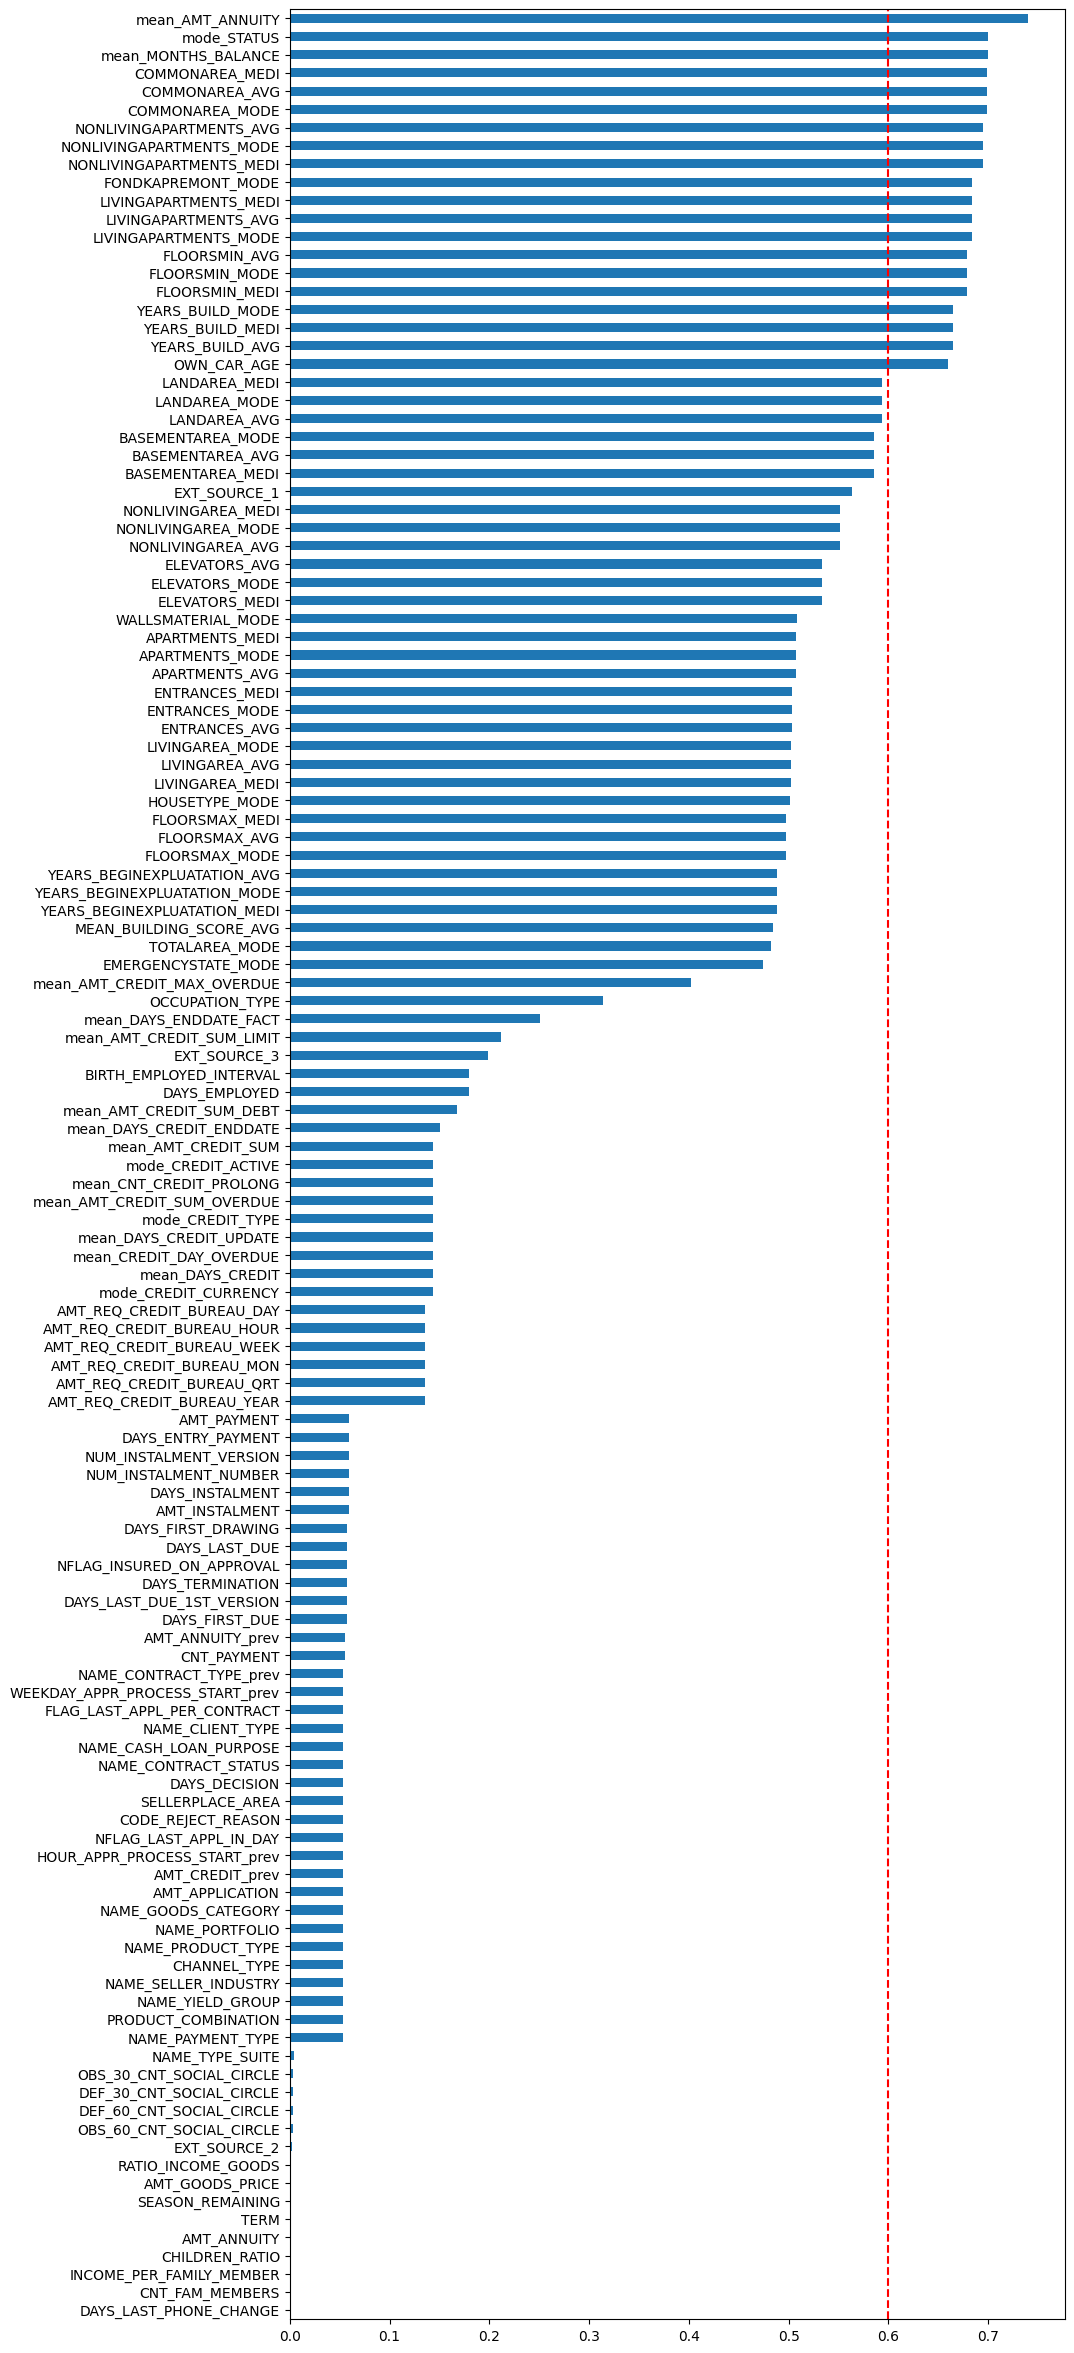

In [115]:
mask = application_train.isna().mean() != 0
na_index = mask[mask].index

fig, ax = plt.subplots(figsize=(10, 30))
application_train[na_index].isna().mean().sort_values(ascending=True).plot(kind='barh', ax=ax)

# Ajouter la ligne verticale à x = 0.6
ax.axvline(x=0.6, color='red', linestyle='--')

plt.show()

Nous supprimons les features avec un taux de valeurs manquantes inférieur à 60%

In [116]:
mask = application_train.isna().mean()>0.6
drop_list = list(mask[mask].index)

In [117]:
application_train.drop(drop_list, axis=1, inplace=True)
application_test.drop(drop_list, axis=1, inplace=True)

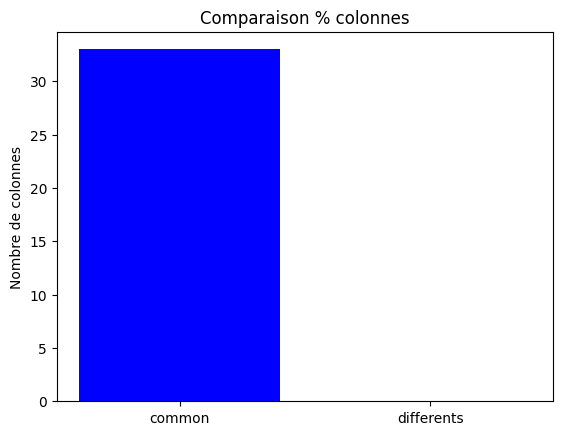

Number of different columns: 0
Different columns: set()
####################################################################################################
mode_CREDIT_TYPE
Nombre d'attributs de mode_CREDIT_TYPE dans df1 est 12 , dans df2 est 14
*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#
L'élément dans df2 qui est absent dans df1 est ['Loan for purchase of shares (margin lending)', 'Loan for the purchase of equipment']
 
df1 mode_CREDIT_TYPE:
Consumer credit                           35256
Credit card                                5903
Car loan                                    573
Mortgage                                    386
Microloan                                   106
Loan for business development                51
Another type of loan                         29
Unknown type of loan                         10
Loan for working capital replenishment        4
Real estate loan                              1
Cash loan (non

In [118]:
diff_cate = dataframe_compare(application_test, application_train)

In [119]:
application_train = local_imputatation(application_train, diff_cate)

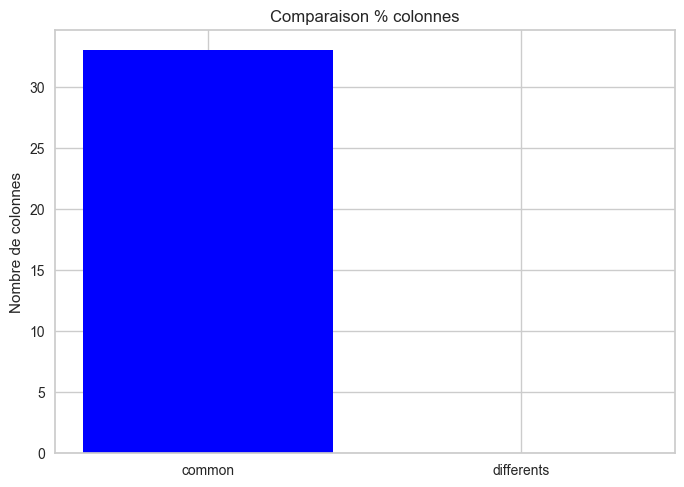

Number of different columns: 0
Different columns: set()
####################################################################################################


In [144]:
diff_cate = dataframe_compare(application_test, application_train)

## Ecriture du dataframe agregé avec les nouvelles features

In [122]:
application_train.to_csv('application_train_prepro.csv', index=False)
application_test.to_csv('input/application_test_prepro.csv', index=False)

In [123]:
# Vérifiez s'ils ont été supprimés
dataframes = [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]
dataframes

['___',
 '_11',
 '_13',
 'application_train',
 'application_test',
 'categorical_columns',
 '_24',
 'missing_data',
 '_27',
 'bureau',
 '_43',
 '_44',
 'bureau_balance',
 '_47',
 'credit_card_balance',
 '_49',
 'installments_payments',
 '_51',
 'POS_CASH_balance',
 '_53',
 'previous_application',
 '_55',
 '_74',
 '_77',
 'agg_bureau',
 '_85',
 '_96',
 'result_numerical',
 'result_categorical',
 'agg_previous_application',
 '_109']

In [124]:
# Supprimez les DataFrames en utilisant leurs noms
for dataframe_name in dataframes:
    del globals()[dataframe_name]